In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math 
import sklearn.preprocessing 
import random
import yaml
import h5py
import logging
import datetime
import os
import time

import pprint
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SequentialSampler, BatchSampler
import torch.nn.functional as F


from load_matlab_timedata import get_data_from
from src.TSGenerator import f_Y, f_X, get_func_timeseries
from src.DataLoader import TimeSeriesDataset
from src.model_utils import init_logger, plot_shared_scale, plot_multiscale
from src.Model import LSTM
from src.Losses import myLoss, prognose_dy

from torch.optim.lr_scheduler import ReduceLROnPlateau  


## Loading config files, setup execution parameters, init objects

In [2]:
plt.rcParams['figure.figsize'] = 20, 7.
CONFIG_FILENAME = "model_params_tune.yaml"
# ! ls DC_motor_simulation
with open(CONFIG_FILENAME, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
   
pprint.pprint(config)


p_net = config['network_params']

p_train = config['train_params']

p_gen = config['generator_params']

p_data = config['data_params']
need_normalize = p_data['need_normalize']

{'data_params': {'integration_step': 0.01,
                 'leave_nth': 13,
                 'mat_file': 'DC_motor_simulation/res.mat',
                 'need_normalize': True,
                 'test_size': 0.3,
                 'use_part_of_data': 1.0},
 'exp_path': 'only_batches',
 'generator_params': {'a': 0.5, 'b': 1.0, 'f_X': 'math.sin', 'f_Y': 'math.cos'},
 'is_debug': False,
 'network_params': {'dtype': 'torch.float',
                    'hidden_size': 16,
                    'input_size': 64,
                    'num_layers': 1,
                    'output_dim': 3,
                    'per_element': True,
                    'retrospective_steps': 128},
 'to_generate_data': False,
 'train_params': {'auto_loss': True,
                  'aux_loss': {'part_of_max_for_const': 0.5,
                               'scaling_order': 5,
                               'steady_state_threshold': 0.001},
                  'batch_size': 1024,
                  'core_loss': {'part_of_max_for_

# Set parameters

In [3]:

# # If `per_element` is True, then LSTM reads in one timestep at a time.
if  p_net['per_element']:
    lstm_input_size = 1
else:
    lstm_input_size = p_net['input_size']
    
# if is_debug:
#     x, y = get_func_timeseries(f_Y = f_Y, f_X = f_X, a=p_generate['a'], b=p_generate['b'])
to_generate_data = config['to_generate_data'] 
if to_generate_data:
    p_gen = config['generator_params']
    print("Data generator params:")
    pprint.pprint(p_gen)
    a = p_gen['a']
    b = p_gen['b']
is_debug = config['is_debug']


init_logger(config)

logging.info("Experiment started with params")
logging.info(f"data_par: {p_data}")
logging.info(f"net_par: {p_net}")
logging.info(f"train_par: {p_train}") 

logger inited to file [only_batcheslogs/exp_2019-05-05_04:49:35.log]


## Init data loader and get appropriate part of data

using 1.0 of data
X normalized, norms: [14.99712541]
x shape (76924, 1)
x_normalized shaoe (76924, 1)


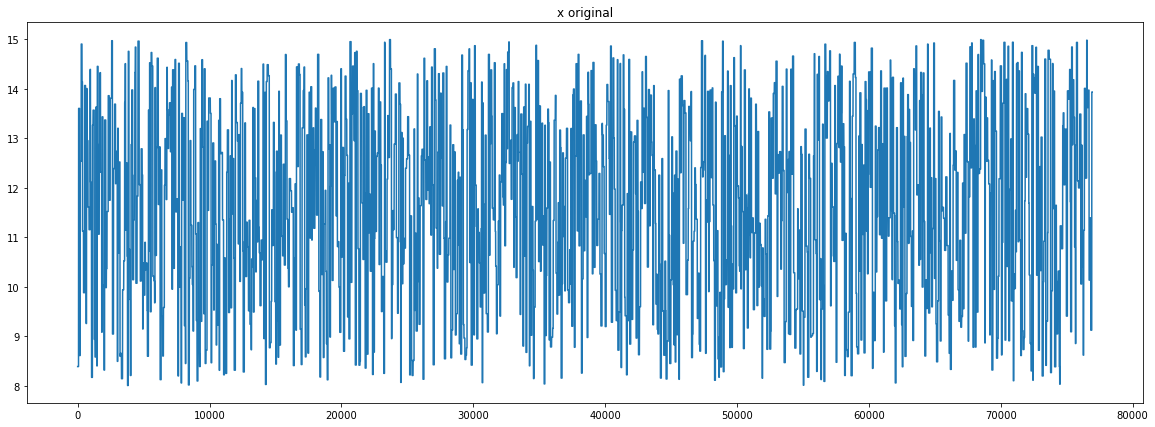

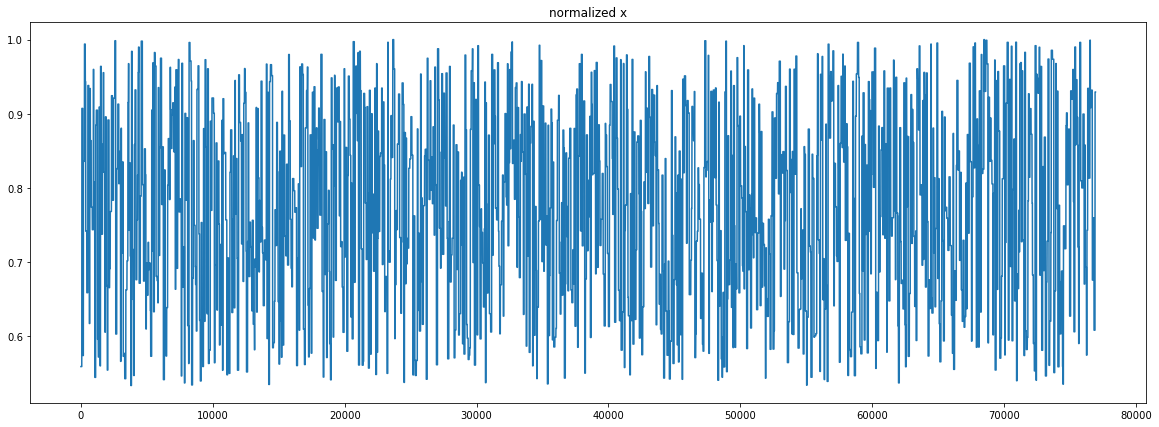

Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (23078, 1)
output partition shape (23078, 1)
stacked Y shape  (22951, 1)
Y_tensor torch.Size([22951, 1])
X_tensor torch.Size([128, 22949, 1])
X normalized, norms: [14.99712541]
x shape (76924, 1)
x_normalized shaoe (76924, 1)


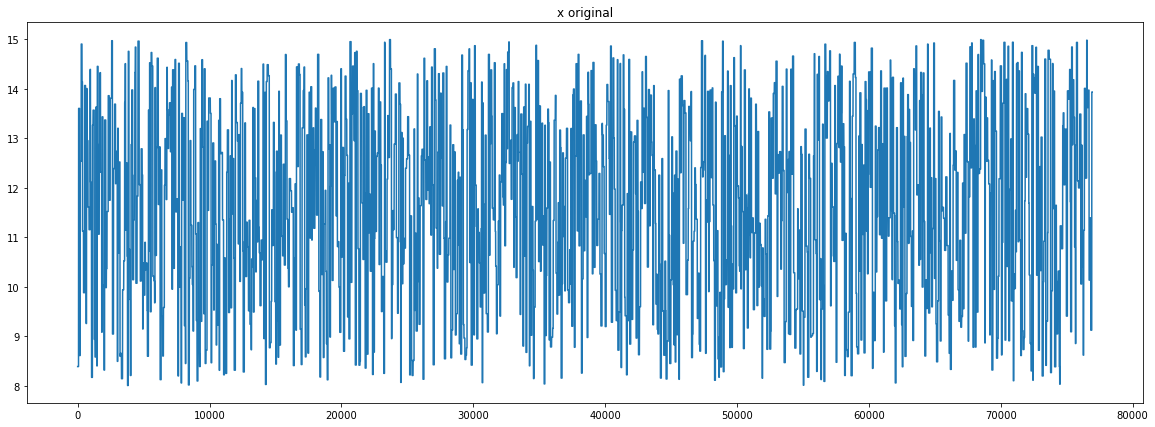

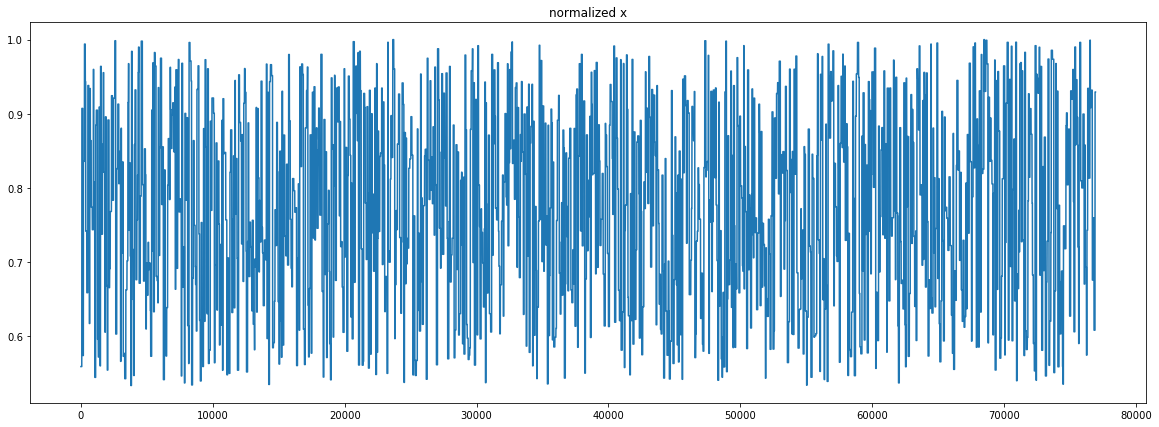

Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (53846, 1)
output partition shape (53846, 1)
stacked Y shape  (53719, 1)
Y_tensor torch.Size([53719, 1])
X_tensor torch.Size([128, 53717, 1])
train set: [53719] batches
test set: [22951] batches
data_loading time 32.32155990600586 secs


In [4]:
# todo add time tracking for this cell
use_part = p_data['use_part_of_data']
print(f"using {use_part} of data")

t_tick = time.time()

test_ts_ds = TimeSeriesDataset(config=config,
                               partition=(use_part - use_part*p_data['test_size'], use_part),                        
                               logging=logging)

train_ts_ds = TimeSeriesDataset(config=config,
                                partition=(0, use_part - use_part*p_data['test_size']),
                                logging=logging)

print(f"train set: [{len(train_ts_ds)}] batches")
print(f"test set: [{len(test_ts_ds)}] batches")

if need_normalize:
    config['x_norm'] = train_ts_ds.x_norms[0]
    config['y_norm'] = train_ts_ds.y_norms[0]
    config['x_norm']
else:
    config['x_norm'] = 1
    config['y_norm'] = 1
    config['x_norm']

train_dl = DataLoader(dataset = train_ts_ds,
                      batch_sampler = BatchSampler(
                          sampler = SequentialSampler(train_ts_ds), 
                          batch_size = p_train['batch_size'],
                          drop_last = True)
                     )
test_dl = DataLoader(dataset = test_ts_ds,
                     batch_sampler = BatchSampler(
                     sampler = SequentialSampler(test_ts_ds), 
                     batch_size = p_train['batch_size'], 
                     drop_last = True)
                    )    
    
t_tock = time.time()
dataload_time = t_tock - t_tick
print(f"data_loading time {dataload_time} secs")

## Inspecting data we have, get several batches and look inside on pretty large scale to see individual iterations:

x [batch_size, retrospective_steps, channels] :torch.Size([1024, 128, 1])
y [batch_size, channels]: torch.Size([1024, 1])
y_last [slice_size]: (150,)


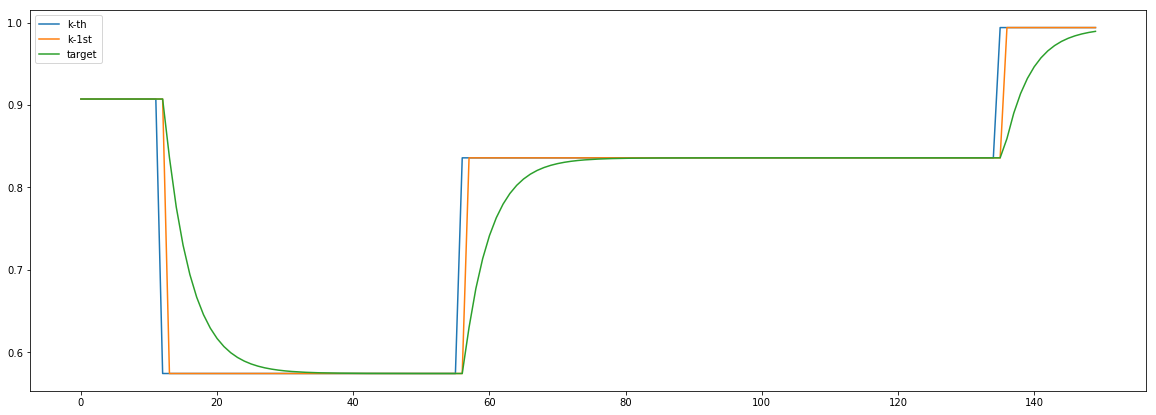

x [batch_size, retrospective_steps, channels] :torch.Size([1024, 128, 1])
y [batch_size, channels]: torch.Size([1024, 1])
y_last [slice_size]: (150,)


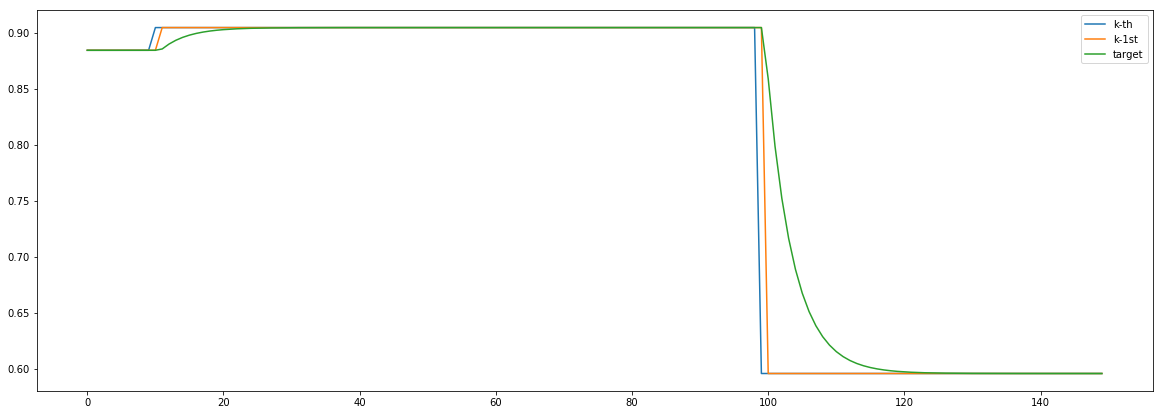

In [5]:
f, t = 0, 150
for i, batch in enumerate(train_dl):
    x, y, ind = batch
    print(f"x [batch_size, retrospective_steps, channels] :{x.shape}")
    print(f"y [batch_size, channels]: {y.shape}")
    y_kth = y.detach().numpy()[f:t, 0]
    print(f"y_last [slice_size]: {y_kth.shape}")
    x = x.transpose(0,1)
    plt.plot(x.detach().numpy()[-1][f:t], label='k-th')
    plt.plot(x.detach().numpy()[-2][f:t], label='k-1st')
    plt.plot(y_kth, label='target')
    plt.legend()
    plt.show()
    if i == 1:
        break

## Creating objects from imported files

In [6]:
from src.Model import LSTM
from src.Losses import myLoss, prognose_dy  # imports here for faster rerun and debug procedure

model = LSTM(lstm_input_size,
             p_net['hidden_size'],
             batch_size=p_train['batch_size'],
             output_dim=p_net['output_dim'],
             num_layers=p_net['num_layers'])

loss_fn = myLoss

# if p_train['loss_fn'] == 'mse':  
#     loss_fn = torch.nn.MSELoss(reduction=p_train['reduction'])
# elif p_train['loss_fn'] == 'l1':  
#     loss_fn = torch.nn.L1Loss(reduction=p_train['reduction'])

p_optim = p_train['optimizer']
wd = p_optim['weight_decay']
lr = p_optim['learning_rate']

if p_optim['optimizer'] == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

logging.info(f"Model n params: {model.get_num_params()}")
print(f"model has [{model.get_num_params()}] params")
num_epochs = p_train['num_epochs']
logging.info("Training process INITIALIZED")
optimizer

model has [1267.0] params


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [7]:
for name, parameter in model.named_parameters():
    print(name, '\t\t', parameter.shape)

lstm.weight_ih_l0 		 torch.Size([64, 1])
lstm.weight_hh_l0 		 torch.Size([64, 16])
lstm.bias_ih_l0 		 torch.Size([64])
lstm.bias_hh_l0 		 torch.Size([64])
linear.weight 		 torch.Size([3, 16])
linear.bias 		 torch.Size([3])


In [8]:
# #####################
# # 
# #####################
# from torch.nn import init
# for layer_p in a._all_weights:
#     for p in layer_p:
#         if 'weight' in p:
#             # print(p, a.__getattr__(p))
#             init.normal(a.__getattr__(p), 0.0, 0.02)

In [9]:
logging.info("History INITIALIZED")

hist = {
    "train":{
        "batches":{
            "main":np.zeros(len(train_dl)),
            "aux":np.zeros(len(train_dl)),
            "const":np.zeros(len(train_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "const":np.zeros(num_epochs)
        }
    },
    "eval_train":{
        "batches":{
            "main":np.zeros(len(train_dl)),
            "aux":np.zeros(len(train_dl)),
            "const":np.zeros(len(train_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "const":np.zeros(num_epochs)
        }
    },
    "eval_test":{
        "batches":{
            "main":np.zeros(len(test_dl)),
            "aux":np.zeros(len(test_dl)),
            "const":np.zeros(len(test_dl))
        },
        "epochs":{
            "main":np.zeros(num_epochs),
            "aux":np.zeros(num_epochs),
            "const":np.zeros(num_epochs)
        }
    },
    'mean_params_sample':
    {
        '1':np.zeros(num_epochs),
        '2':np.zeros(num_epochs),            
    },
    'lr': np.zeros(num_epochs),
    'loss_rate': np.zeros(num_epochs),
    'weights_sum': np.zeros(num_epochs), 
    'weights_var': np.zeros(num_epochs)
}

In [10]:
def batch_iteration(iter_index, model, optimizer, batch_data, backprop, hist_part):
    
    x_batch, y_batch, indexes = data
    x_batch.transpose_(0, 1) # todo get rid of it
    model.hidden = model.init_hidden()

    y_pred = model(x_batch)
    losses = loss_fn(y_pred, y_batch, x_batch, config)
    main_loss, aux_loss, const_loss = losses
    aux_loss *= 10*p_train['aux_loss']['scaling_order']
    main_loss -= main_loss
    
    param_decay = p_train['param_decay']
    param_decay_loss =  (y_pred[:, 1].mean() +  y_pred[:, 2].mean()) * (aux_loss * param_decay)
    losses = [main_loss * 0, aux_loss, const_loss, param_decay_loss]
#         print(f"losses before scaling: m[{main_loss.item()}] a[{aux_loss.item()}] c[{const_loss.item()}]")
    
    
    if backprop:
        max_loss = max(losses)
        combined_loss = sum(losses)

        optimizer.zero_grad()

        combined_loss.backward()
    # TODO or manually add weight decay here when grad is ready
    #         print(f"losses after scaling: m[{main_loss.item()}] a[{aux_loss.item()}] c[{const_loss.item()}]")

        optimizer.step()
    
    hist_part["main"][iter_index] = main_loss.item()
    hist_part["aux"][iter_index] = aux_loss.item()
    hist_part["const"][iter_index] = const_loss.item()
    
    return y_pred

In [11]:
def update_long_term_hist(batches_hist, long_term_hist):
    mean_main = np.average(batches_hist["main"])
    mean_aux = np.average(batches_hist["aux"])
    mean_const = np.average(batches_hist["const"])
    long_term_hist["main"][t] = mean_main
    long_term_hist["aux"][t] = mean_aux
    long_term_hist["const"][t] = mean_const
    return mean_main, mean_aux, mean_const

In [12]:
def slice_loss_sum(losses_dict, index):
    return sum([val[index] for val in losses_dict.values()])

In [13]:
p_sched = p_train['lr_scheduler']
scheduler = ReduceLROnPlateau(optimizer=optimizer,
                              mode='min',
                              patience=p_sched['patience'],
                              cooldown=p_sched['cooldown'],
                              threshold=p_sched['threshold'],
                              threshold_mode='rel',
                            factor=p_sched['lr_drop'],
                             min_lr=10**p_sched['early_stop_order'],
                             verbose=True)
print("LR scheduler set_uped")
scheduler.state_dict()

LR scheduler set_uped


{'factor': 0.3,
 'min_lrs': [1e-07],
 'patience': 2,
 'verbose': True,
 'cooldown': 3,
 'cooldown_counter': 0,
 'mode': 'min',
 'threshold': 0.01,
 'threshold_mode': 'rel',
 'best': inf,
 'num_bad_epochs': 0,
 'mode_worse': inf,
 'eps': 1e-08,
 'last_epoch': -1}

## Train model


aux preds: 0.13436883687973022 -0.033483054488897324
main loss 0.0
aux loss 232.95233212024547
const loss 0.046696819472484864
combined loss 232.99902893971796 


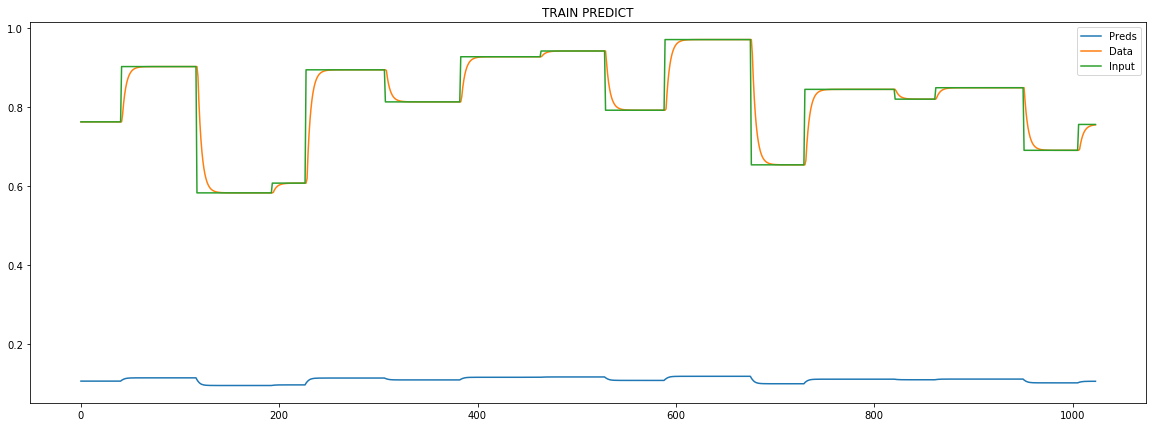

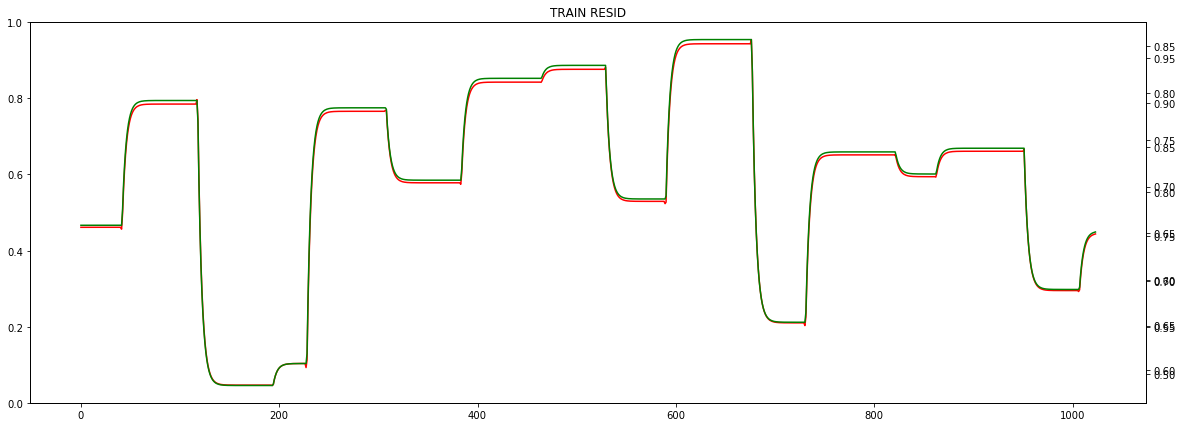

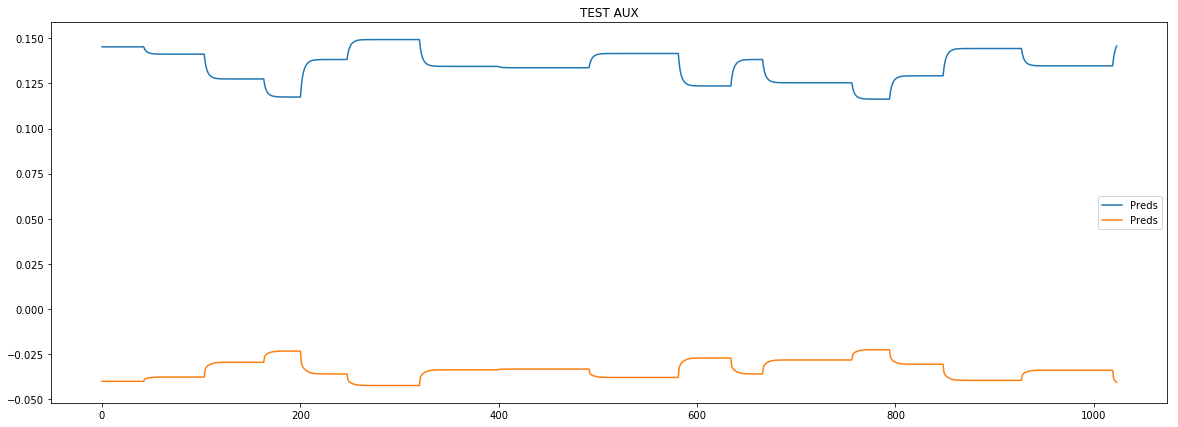

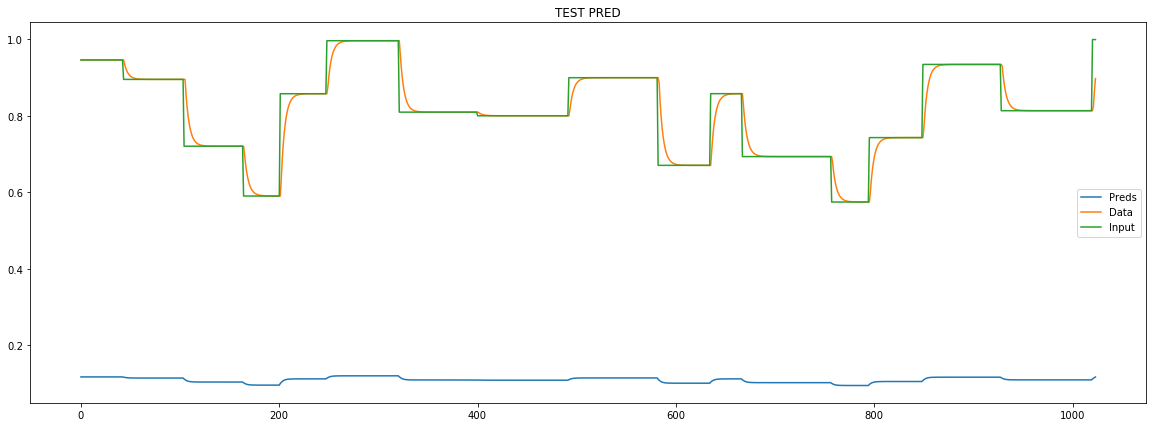

Epoch [0] 
     train_loss[232.99902893971796] 
     eval_train[2.2380185943956556] 
     eval_test[2.2660401795398104]



aux preds: 0.1440809965133667 -0.037949442863464355
main loss 0.0
aux loss 2.3537812049572286
const loss 0.1416923479678539
combined loss 2.4954735529250827 


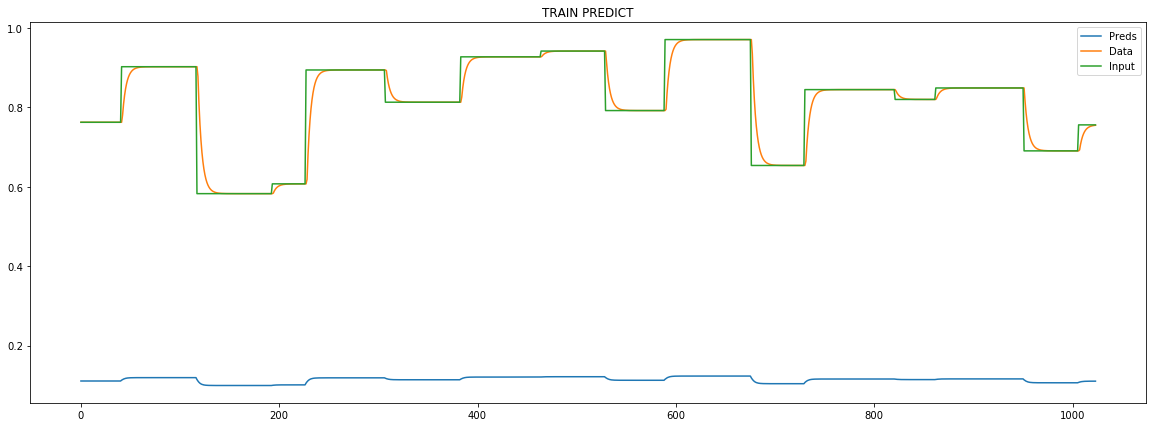

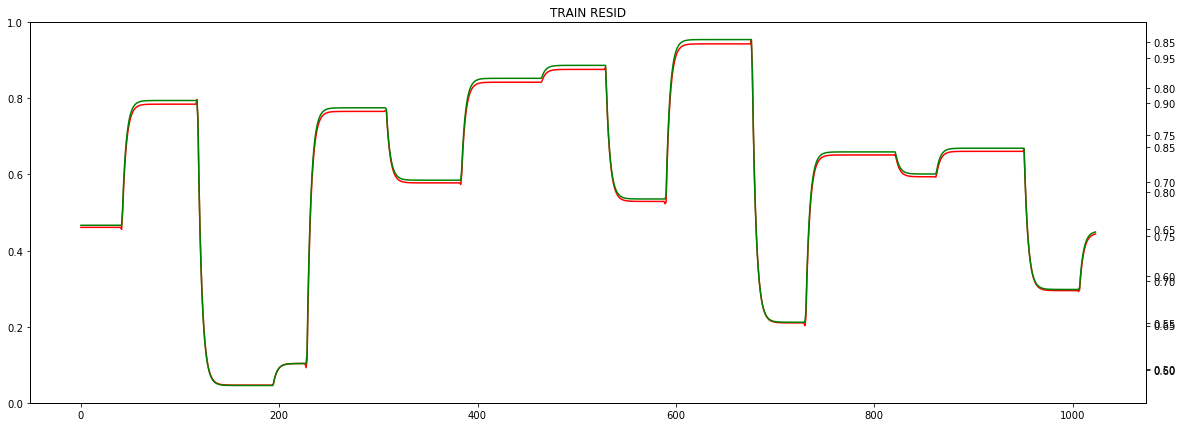

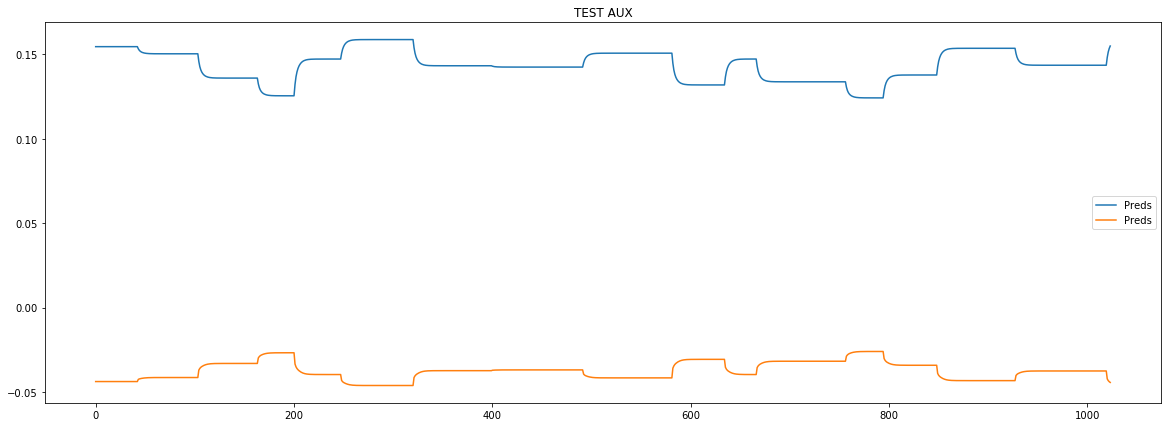

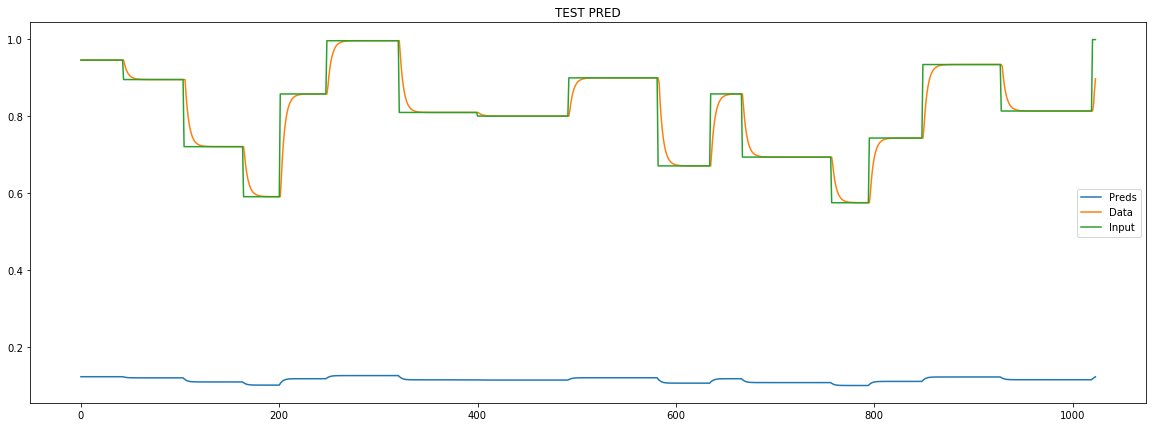

Epoch [1] 
     train_loss[2.4954735529250827] 
     eval_train[2.415251306616343] 
     eval_test[2.444659972055392]



aux preds: 0.1424851268529892 -0.028901943936944008
main loss 0.0
aux loss 2.064963242182365
const loss 0.13833720752826104
combined loss 2.203300449710626 


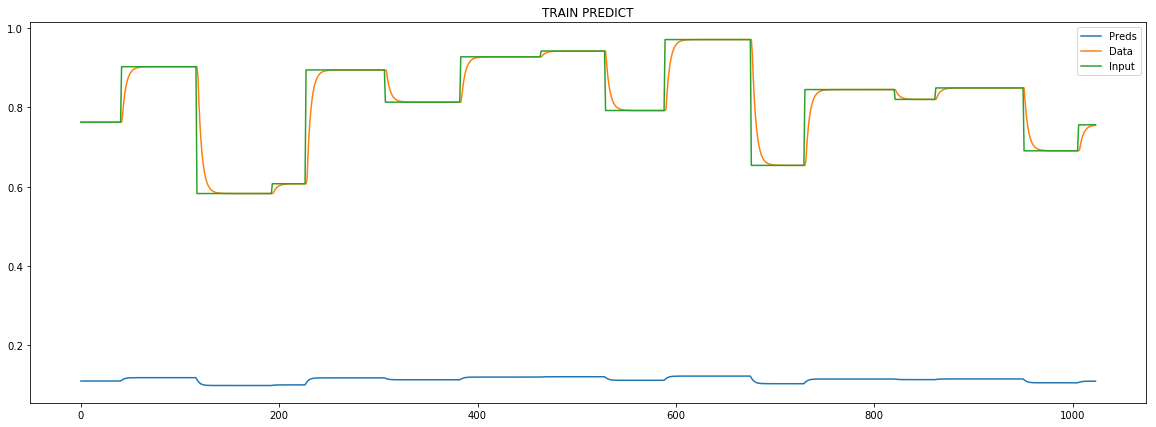

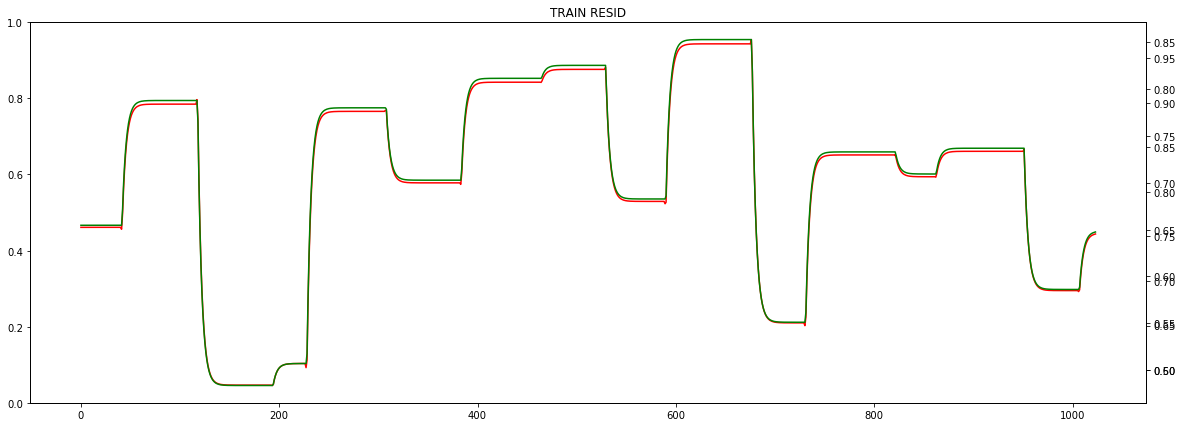

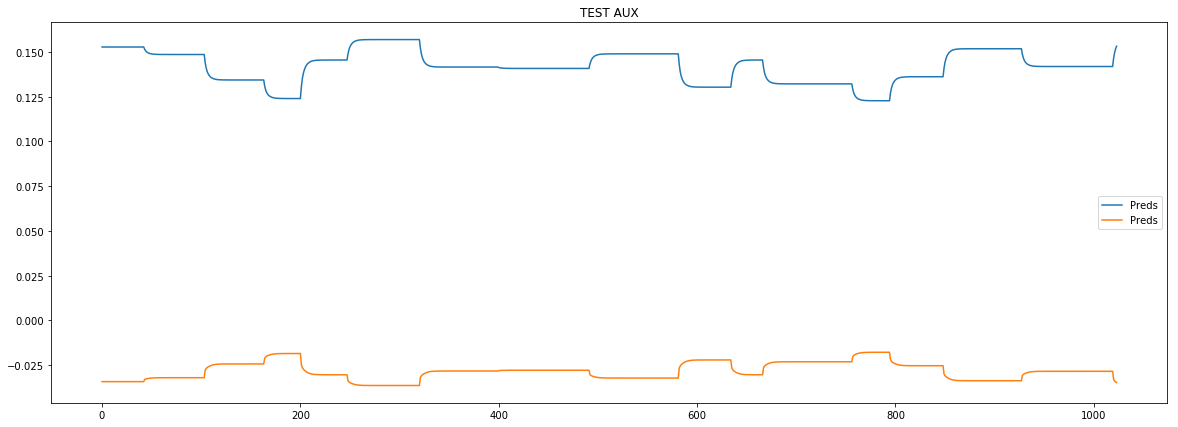

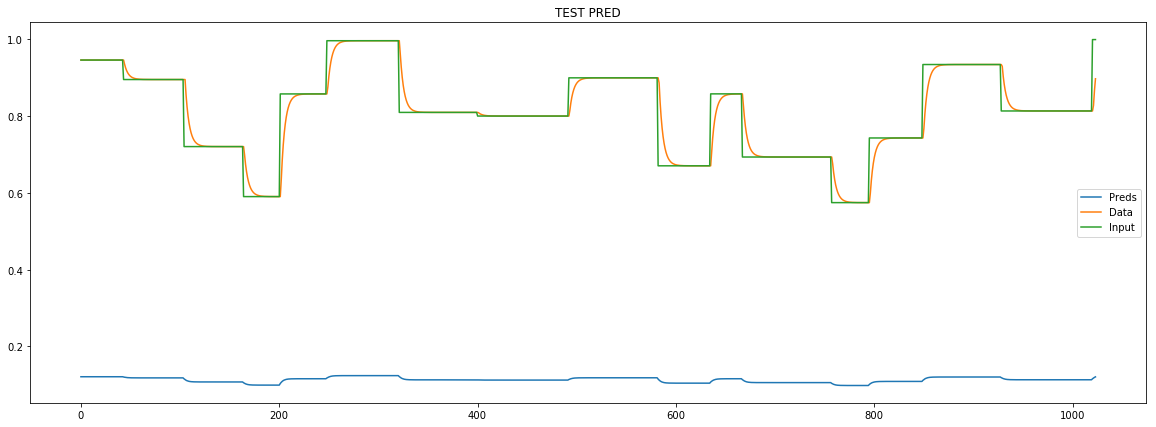

Epoch [2] 
     train_loss[2.203300449710626] 
     eval_train[1.9620950881105204] 
     eval_test[1.989733229306611]



aux preds: 0.1407555490732193 -0.017622096464037895
main loss 0.0
aux loss 1.5646892006580646
const loss 0.13051532337871882
combined loss 1.6952045240367835 


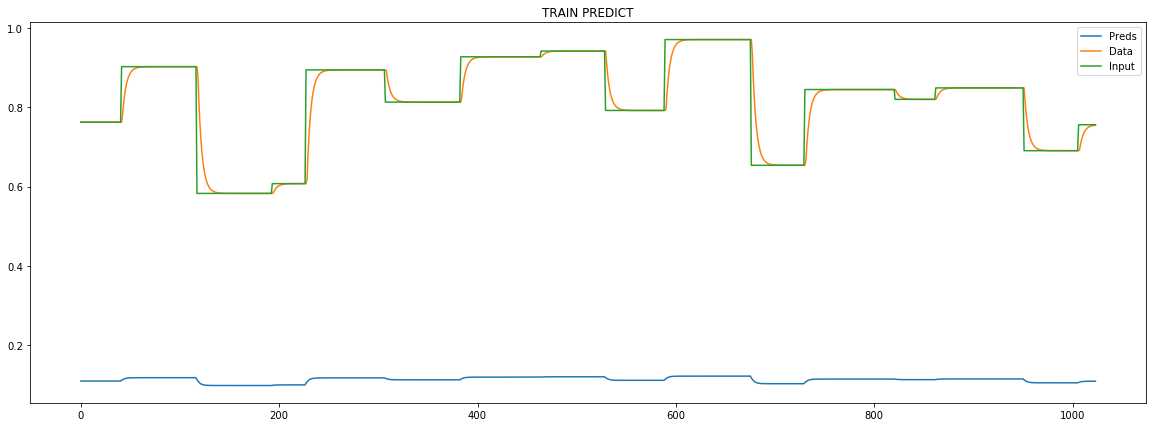

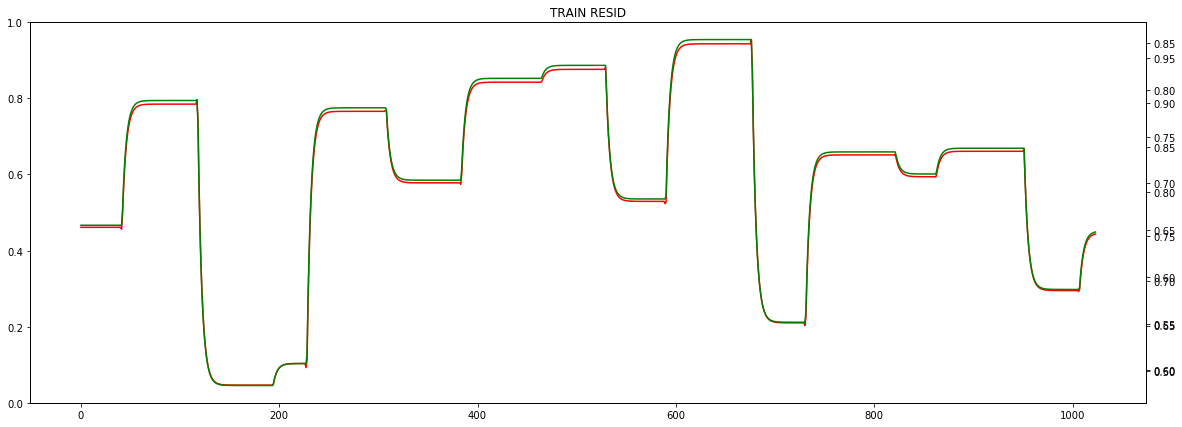

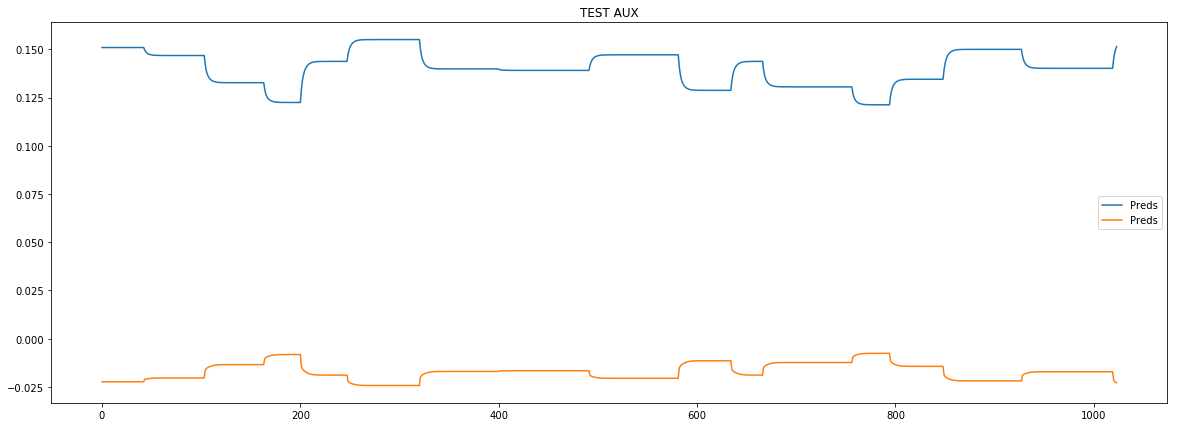

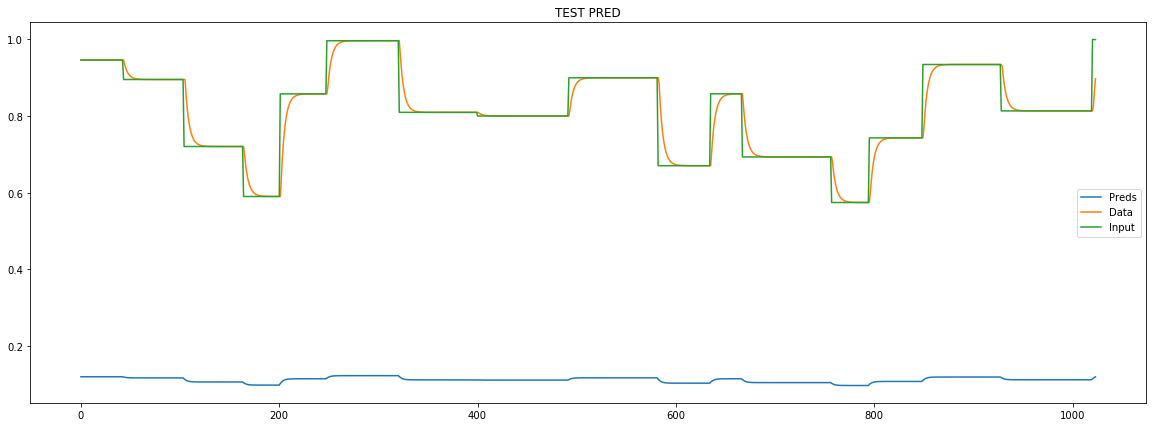

Epoch [3] 
     train_loss[1.6952045240367835] 
     eval_train[1.3989392885795007] 
     eval_test[1.4245500639081001]



aux preds: 0.13912492990493774 -0.0041081467643380165
main loss 0.0
aux loss 0.9563516653501071
const loss 0.12239126517222478
combined loss 1.078742930522332 


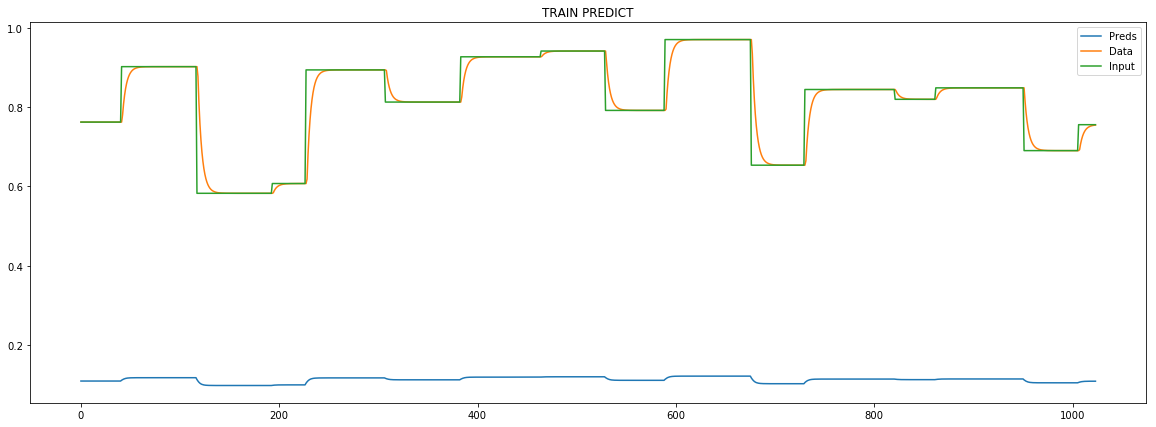

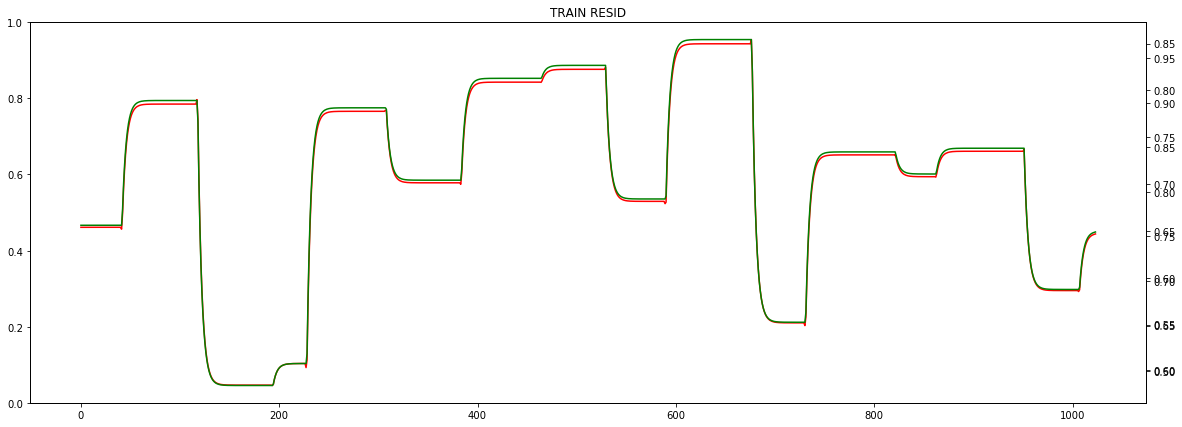

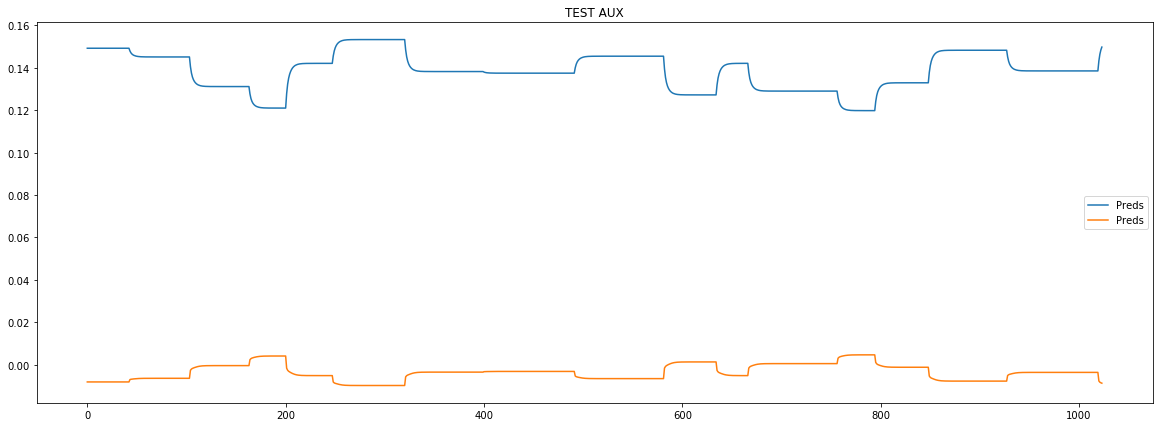

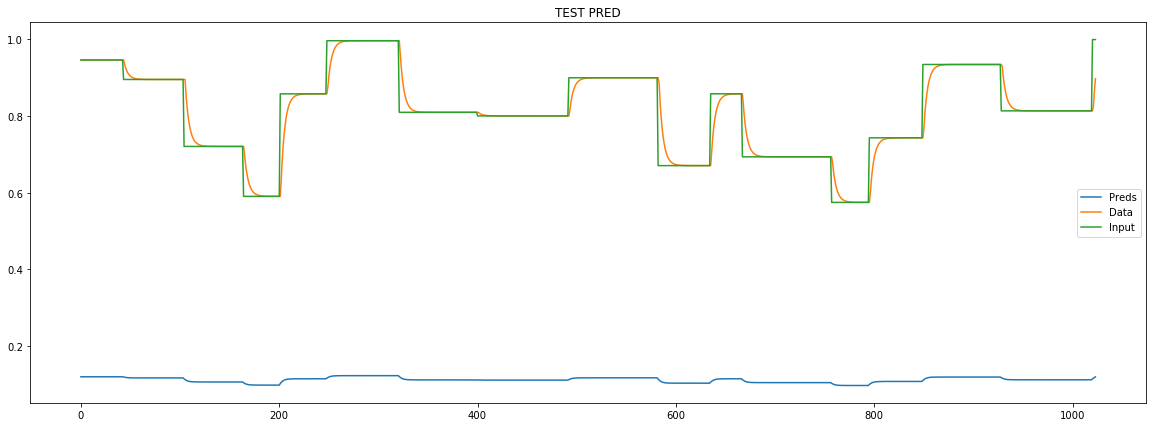

loss rate [0.6163493092657804]
Epoch [4] 
     train_loss[1.078742930522332] 
     eval_train[0.725839432902061] 
     eval_test[0.7492625435644931]



aux preds: 0.14076893031597137 0.003063303418457508
main loss 0.0
aux loss 9.794509258980934
const loss 0.1152054130171354
combined loss 9.909714671998069 


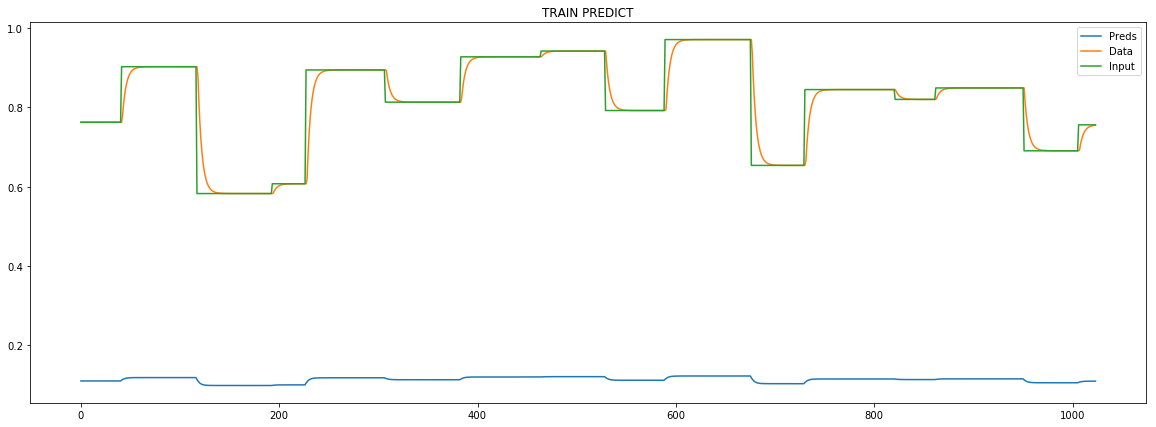

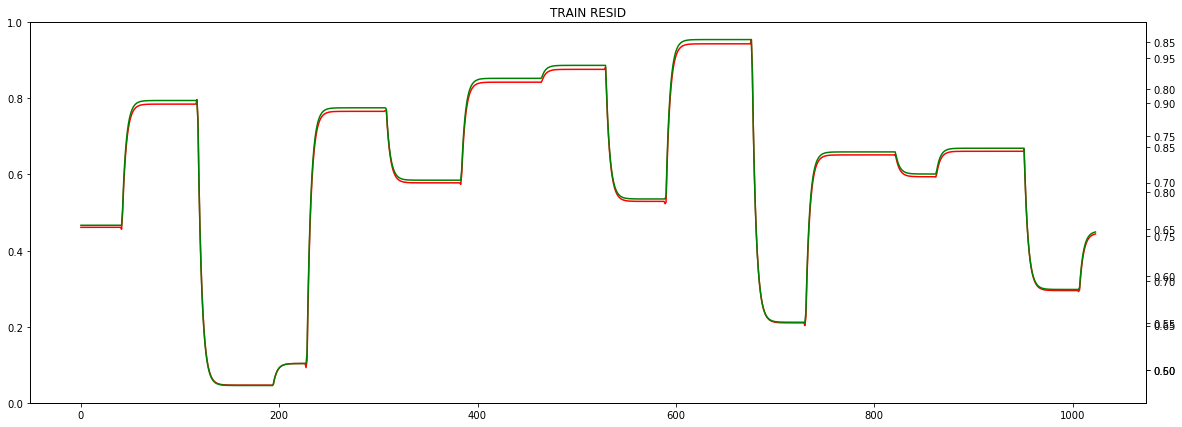

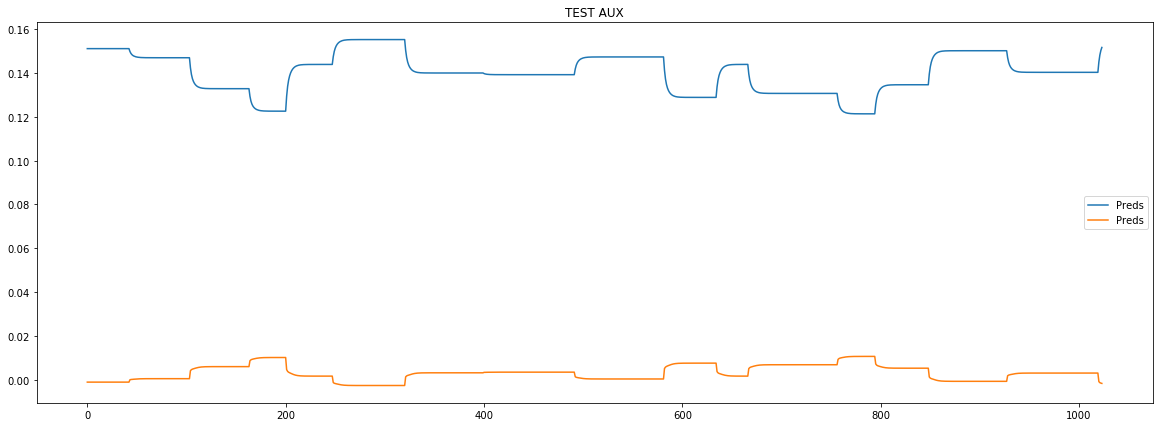

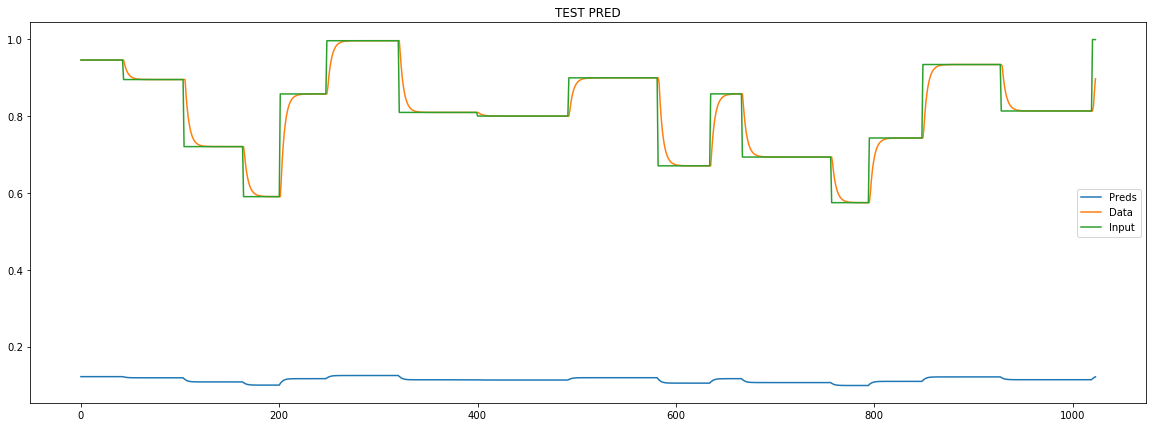

loss rate [0.6973398376533196]
Epoch [5] 
     train_loss[9.909714671998069] 
     eval_train[0.39728716760873795] 
     eval_test[0.4200464862991463]



aux preds: 0.14495308697223663 0.005116551648825407
main loss 0.0
aux loss 9.267812319529744
const loss 0.11853155637016663
combined loss 9.386343875899911 


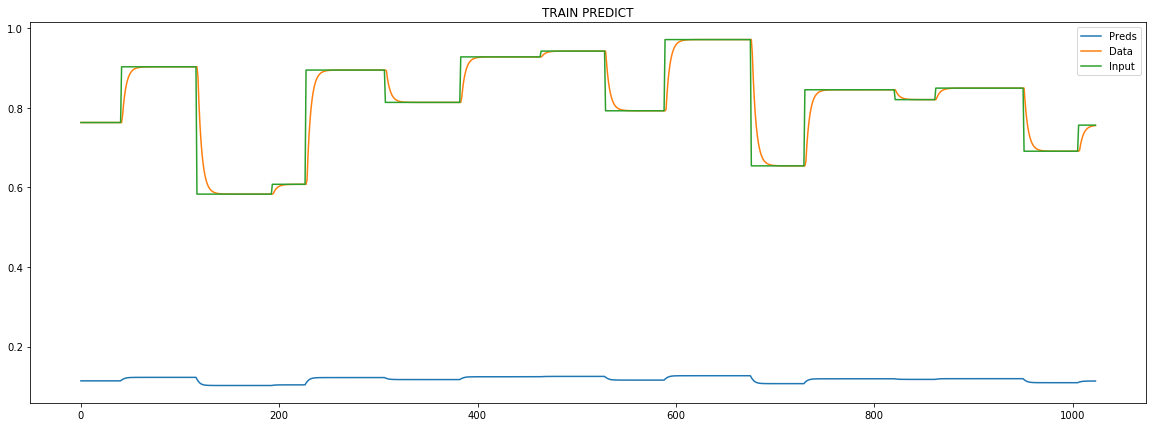

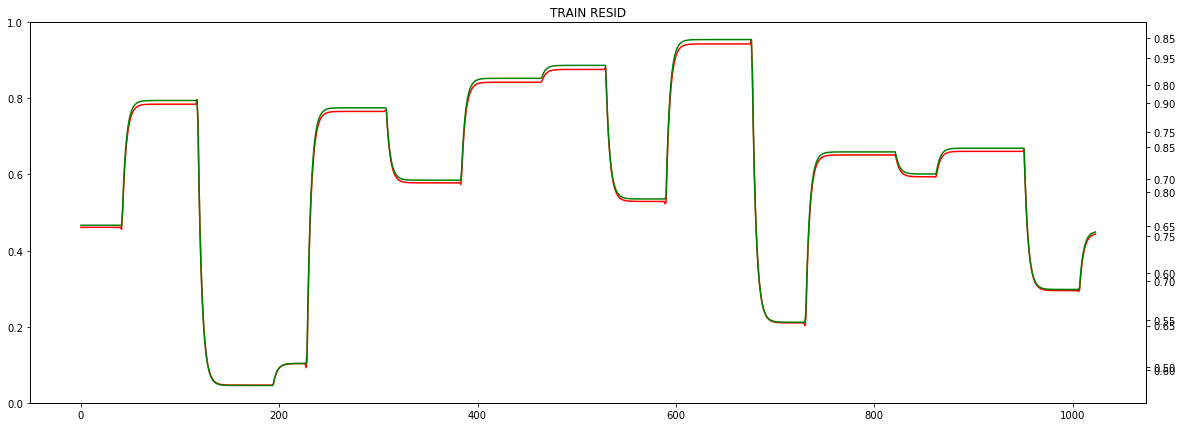

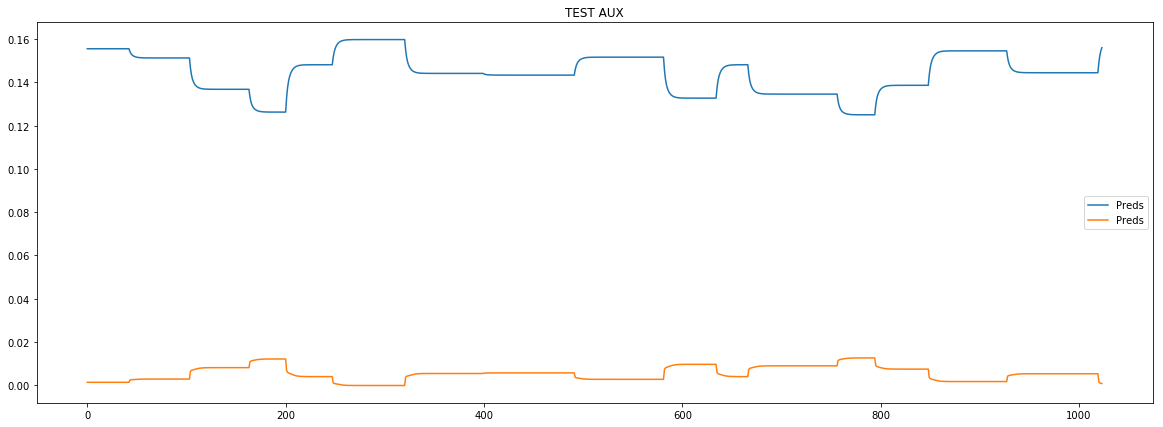

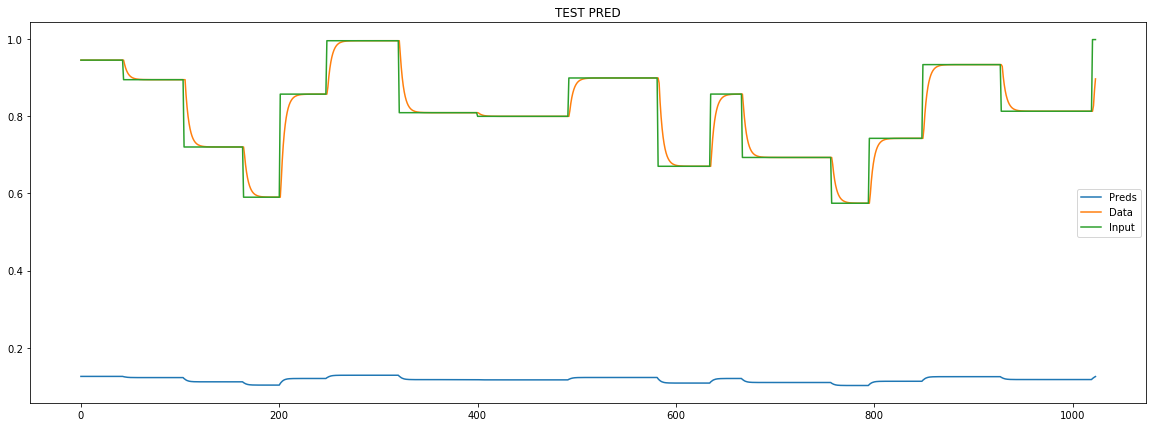

loss rate [0.6356394032193433]
Epoch [6] 
     train_loss[9.386343875899911] 
     eval_train[0.29201869000322545] 
     eval_test[0.31503334912386805]



aux preds: 0.1519211232662201 0.0008574347011744976
main loss 0.0
aux loss 13.81677175879192
const loss 0.12472923128650738
combined loss 13.941500990078426 


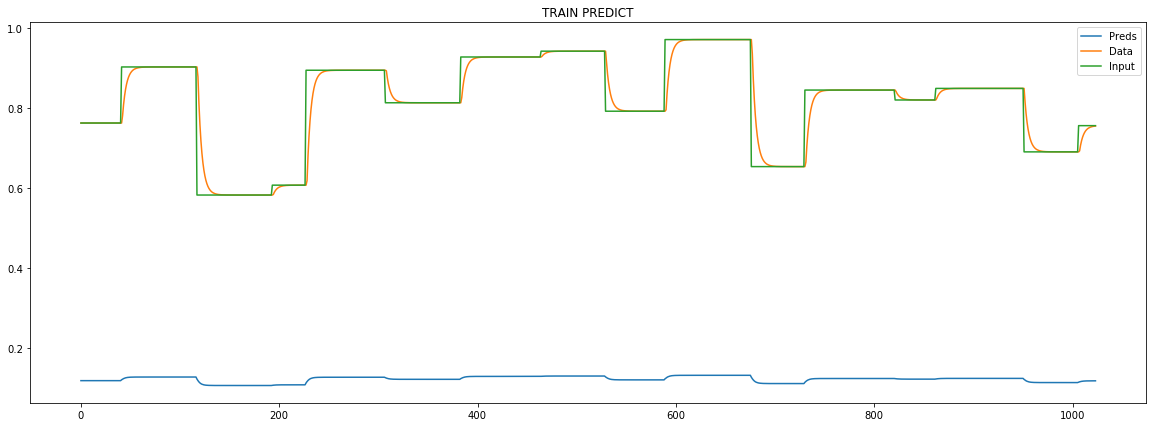

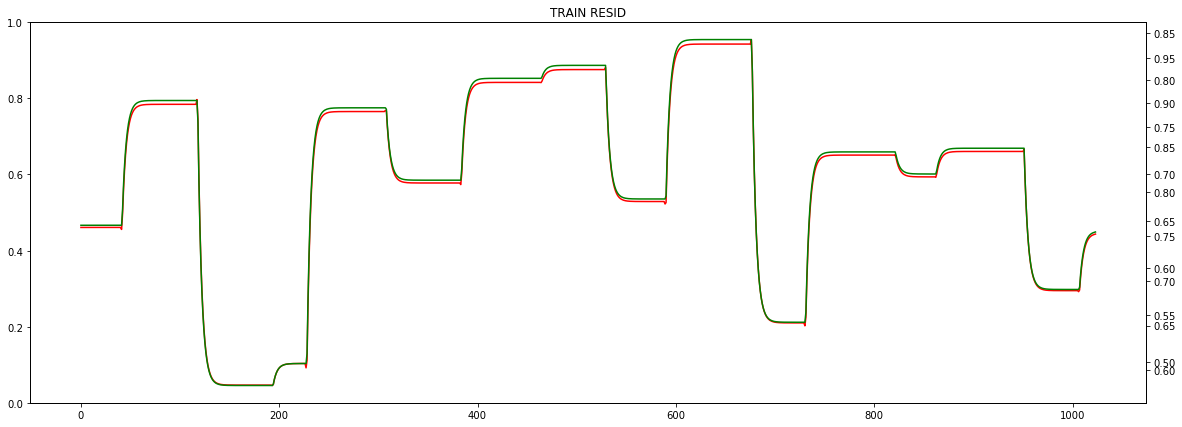

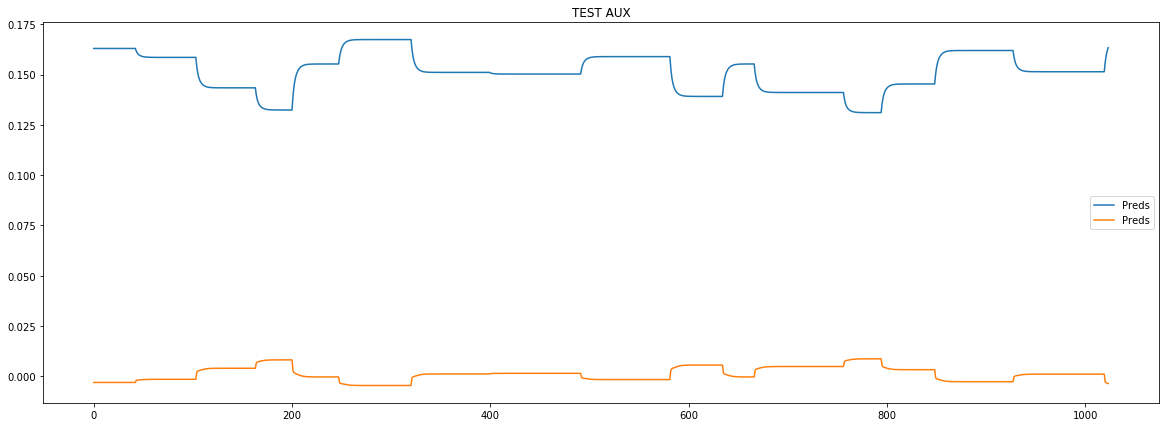

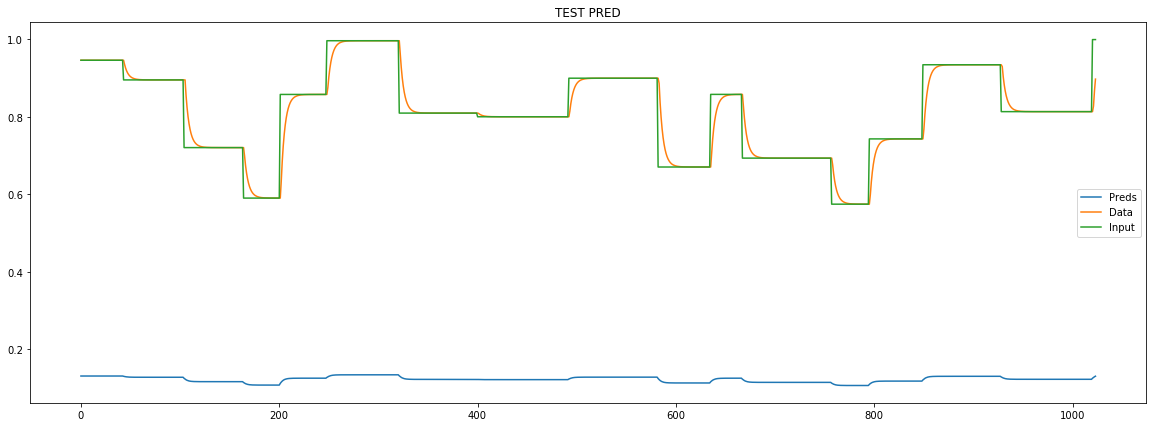

loss rate [-0.07556444939117313]
Epoch [7] 
     train_loss[13.941500990078426] 
     eval_train[0.5075116925514661] 
     eval_test[0.5321686311878941]



aux preds: 0.1564599722623825 0.005280173383653164
main loss 0.0
aux loss 8.832324019418312
const loss 0.13330925786151335
combined loss 8.965633277279826 


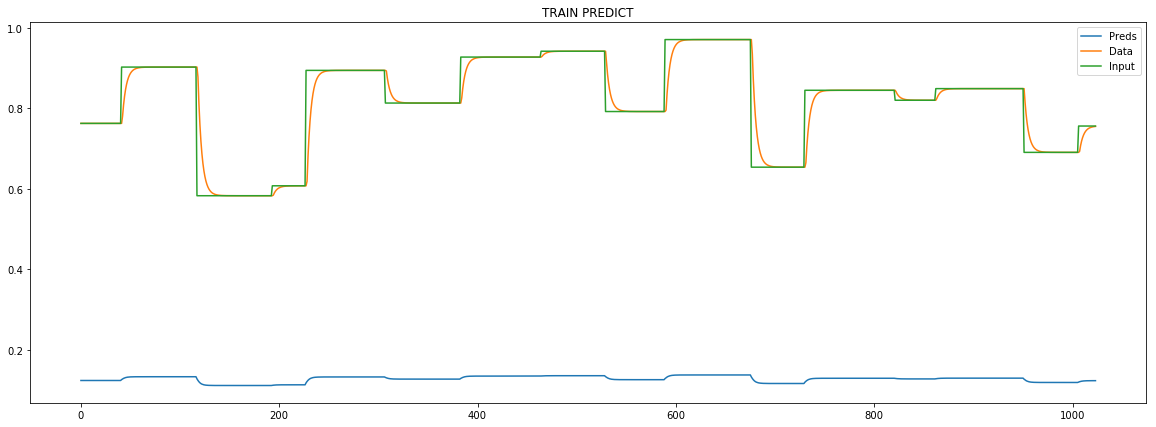

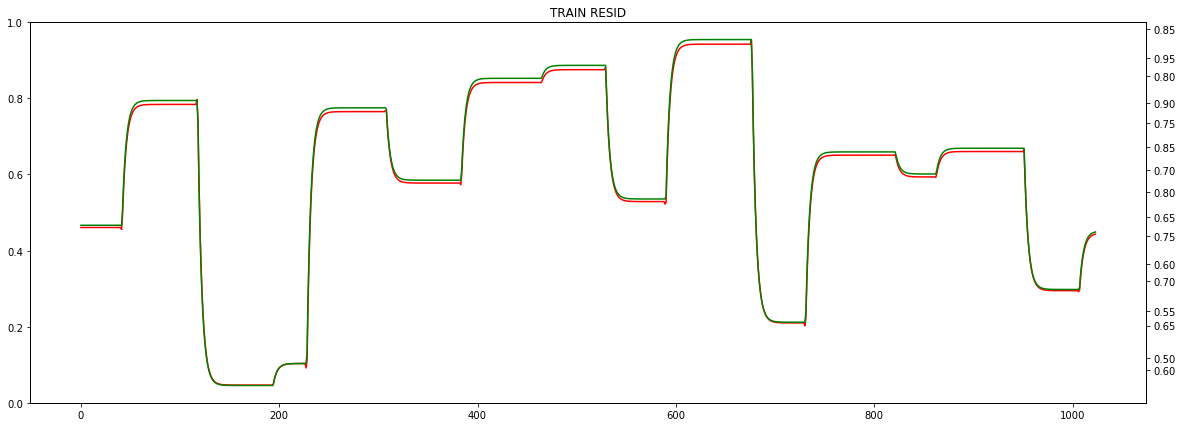

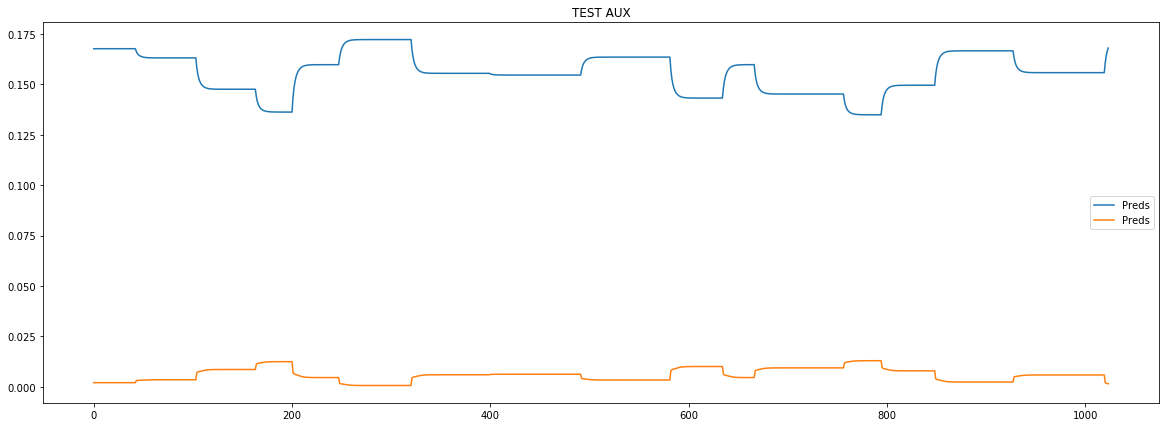

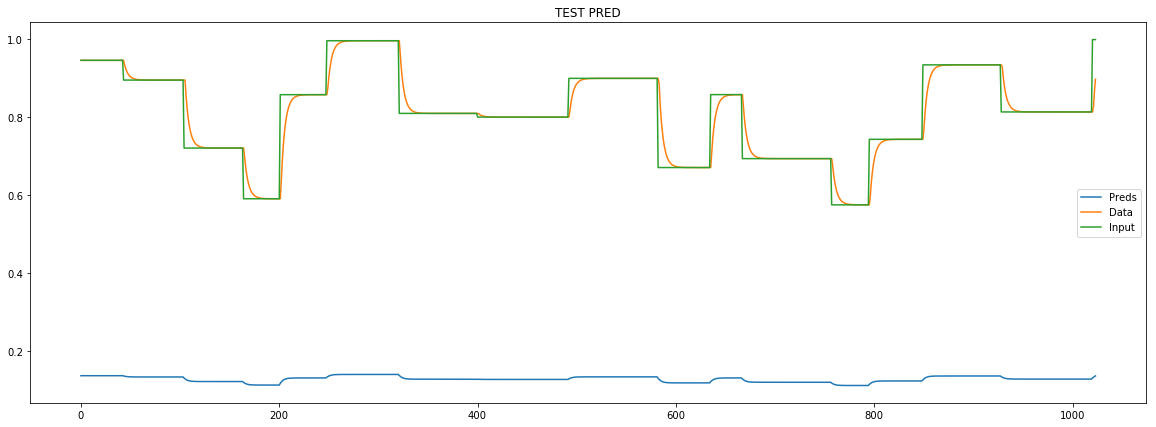

loss rate [0.268722733740265]
Epoch [8] 
     train_loss[8.965633277279826] 
     eval_train[0.28413398445655524] 
     eval_test[0.3089033314450221]



aux preds: 0.1638735979795456 0.0038660415448248386
main loss 0.0
aux loss 16.580493711472418
const loss 0.14166831053220308
combined loss 16.72216202200462 


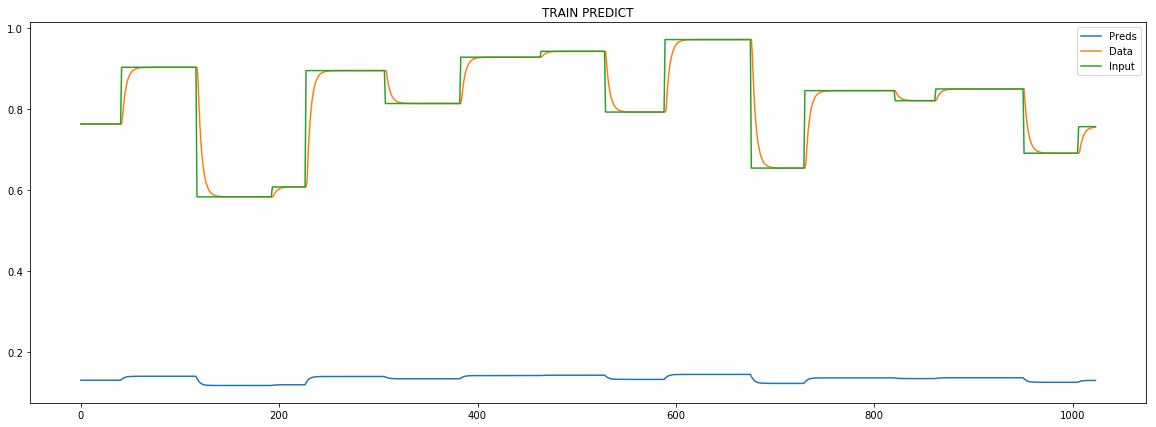

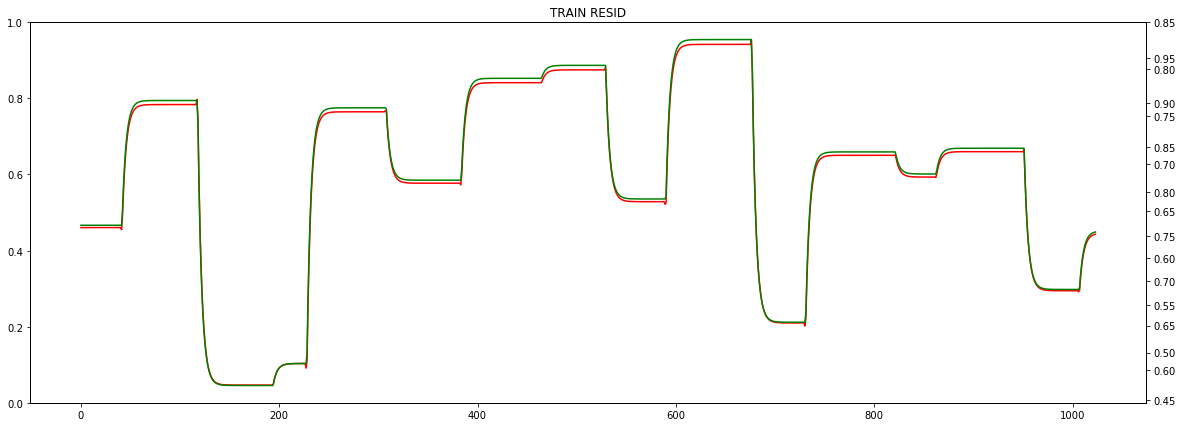

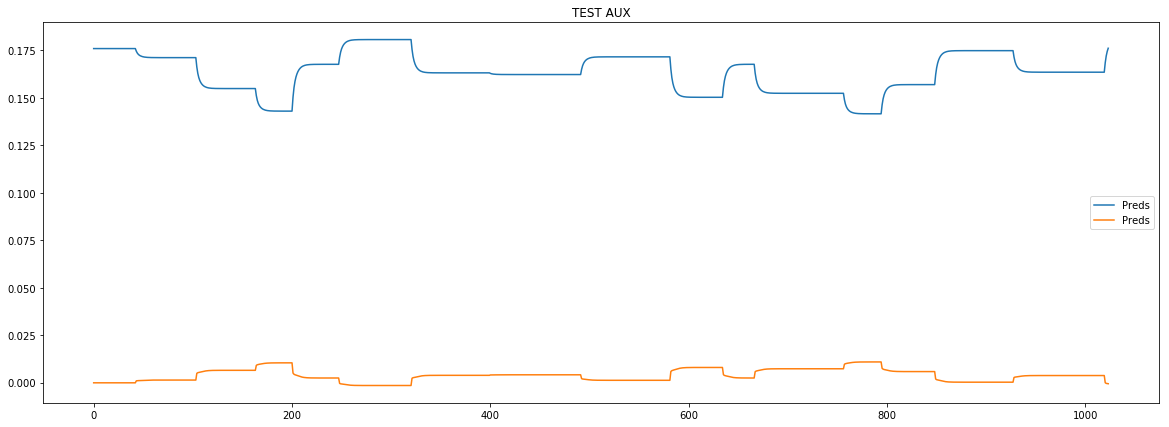

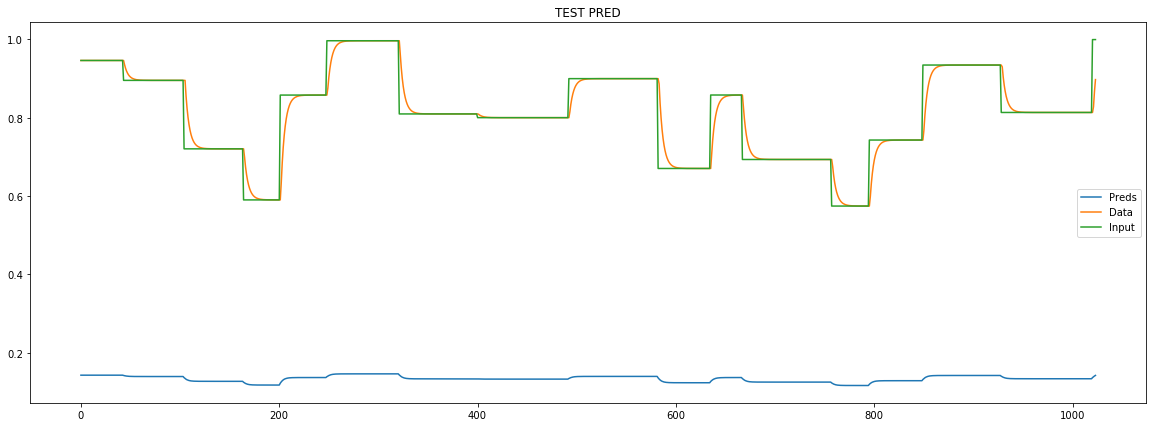

loss rate [-0.10507880418184201]
Epoch [9] 
     train_loss[16.72216202200462] 
     eval_train[0.39945563416068375] 
     eval_test[0.42586249180815433]



aux preds: 0.170506551861763 0.0074610598385334015
main loss 0.0
aux loss 8.076179912098898
const loss 0.1528698859306482
combined loss 8.229049798029546 


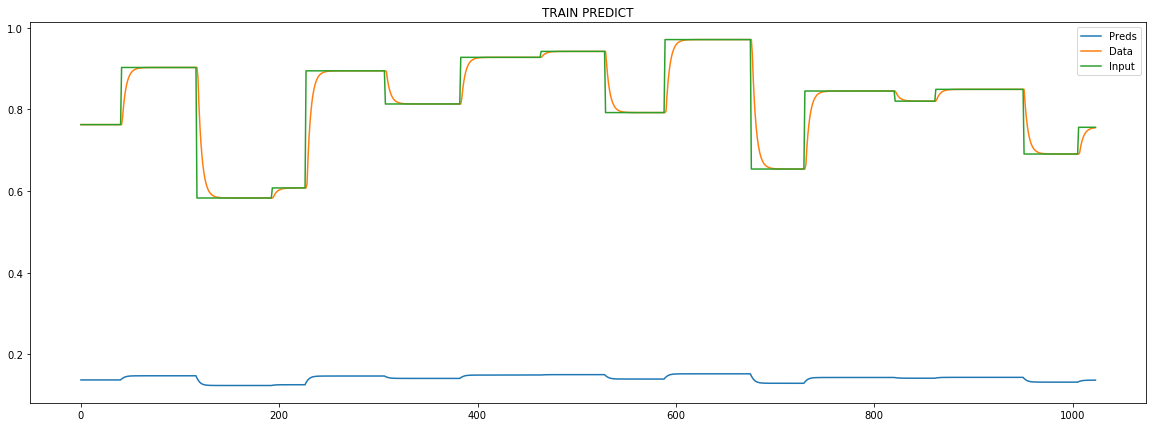

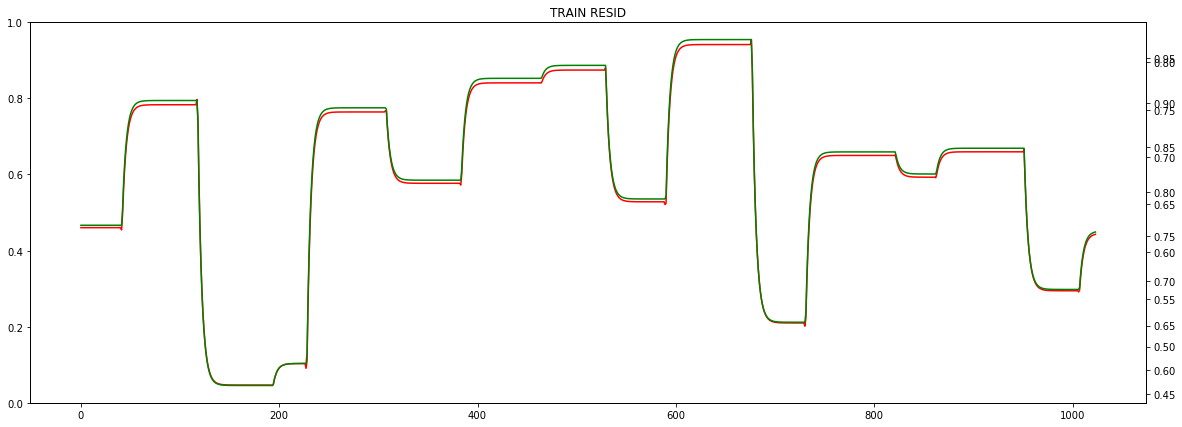

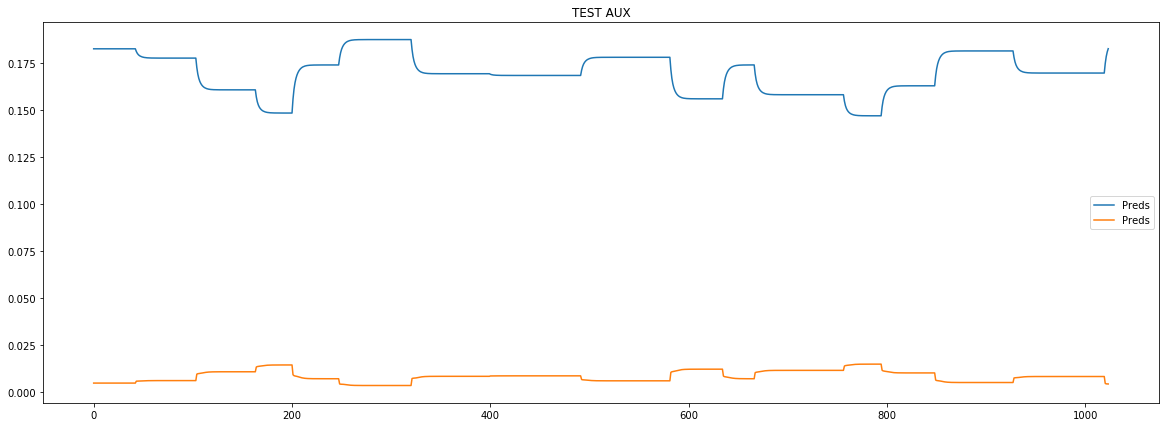

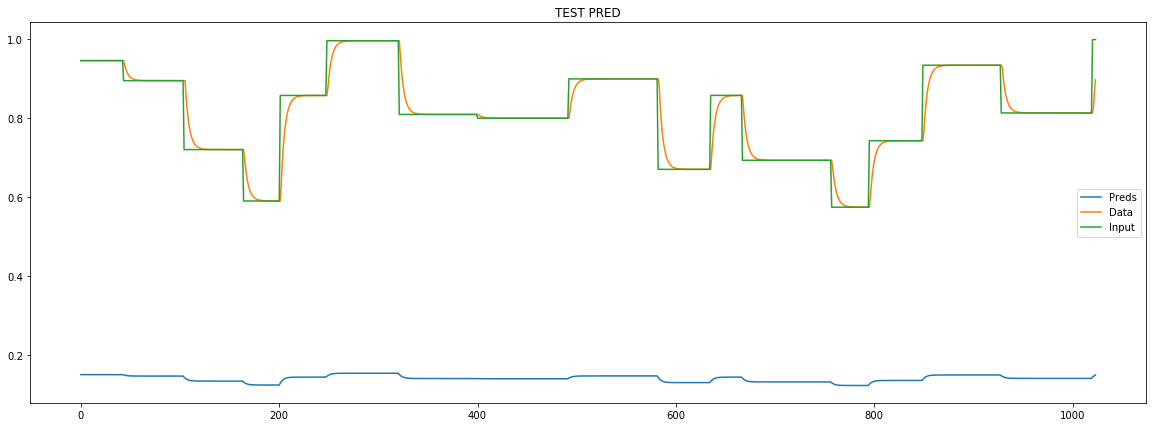

loss rate [-130.02875517831183]
Epoch [10] 
     train_loss[8.229049798029546] 
     eval_train[54.52167333884595] 
     eval_test[55.33494815264236]



aux preds: 0.18076050281524658 0.0038745077326893806
main loss 0.0
aux loss 15.645458939843452
const loss 0.16705669835209846
combined loss 15.812515638195551 


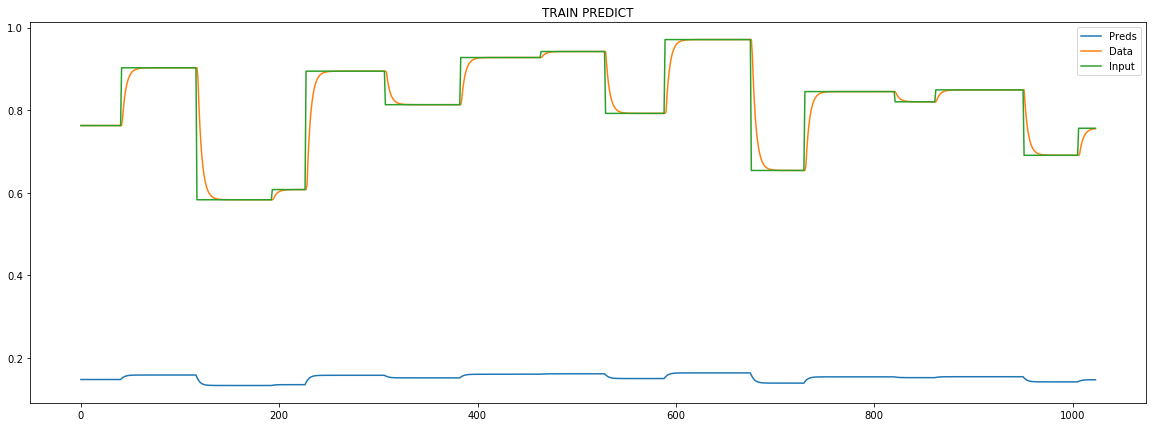

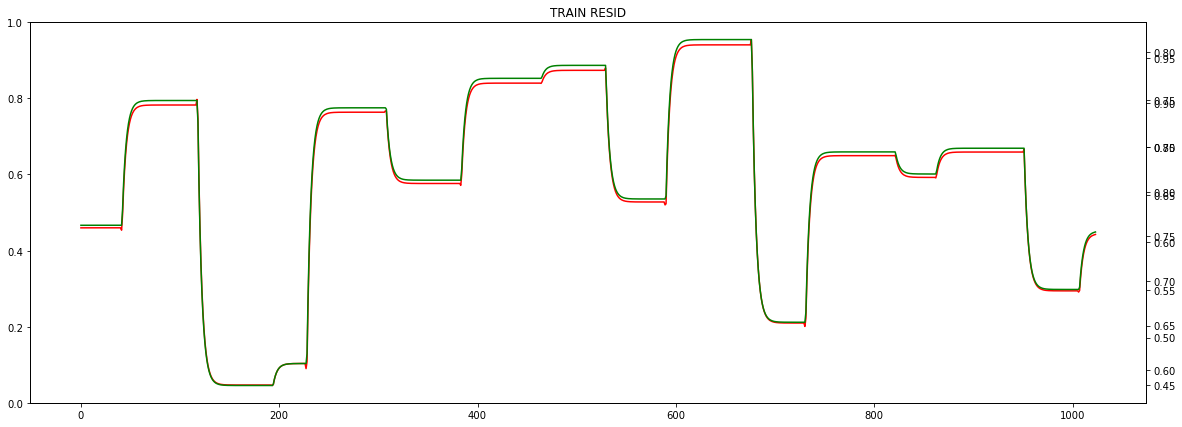

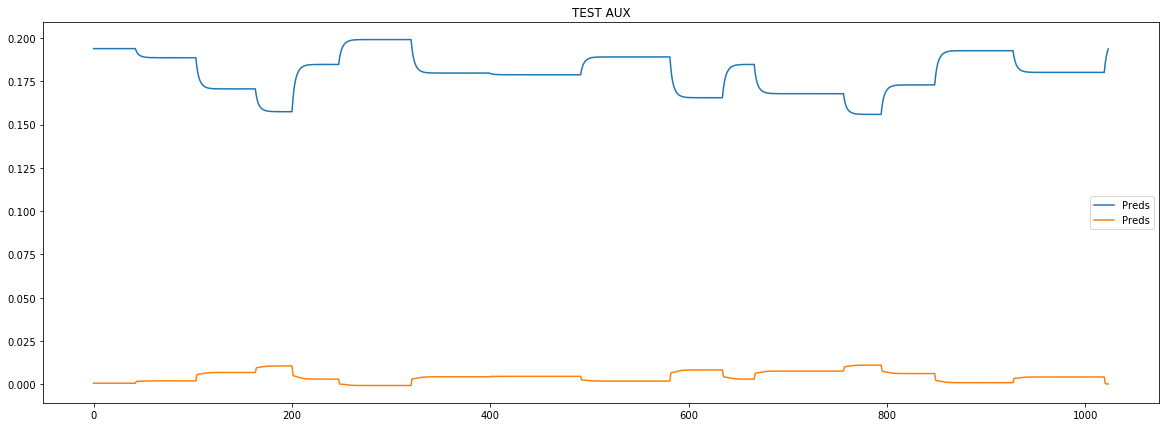

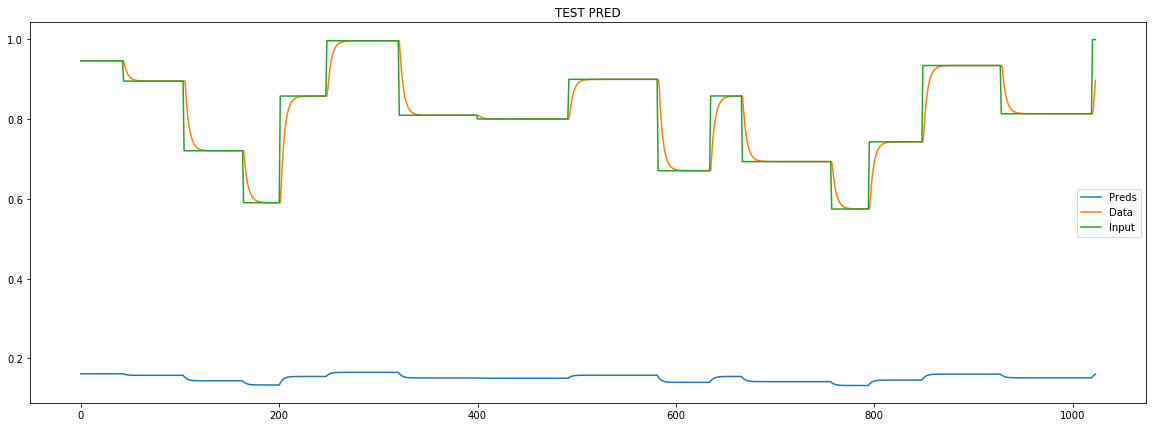

Epoch    11: reducing learning rate of group 0 to 3.0000e-04.
loss rate [0.9770150888734217]
Epoch [11] 
     train_loss[15.812515638195551] 
     eval_train[0.3998185225690787] 
     eval_test[0.42958579754287546]



aux preds: 0.183244526386261 0.005816204007714987
main loss 0.0
aux loss 14.393096670866585
const loss 0.17717213527514383
combined loss 14.57026880614173 


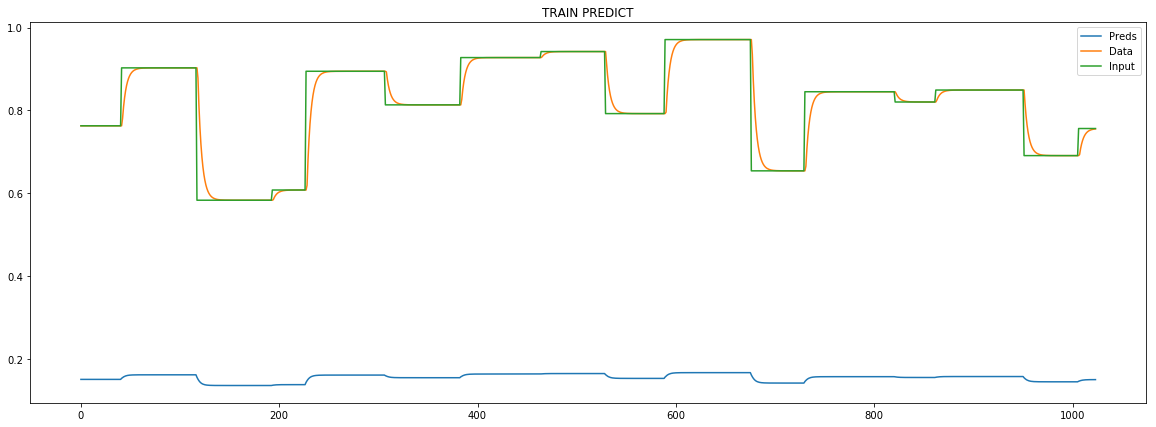

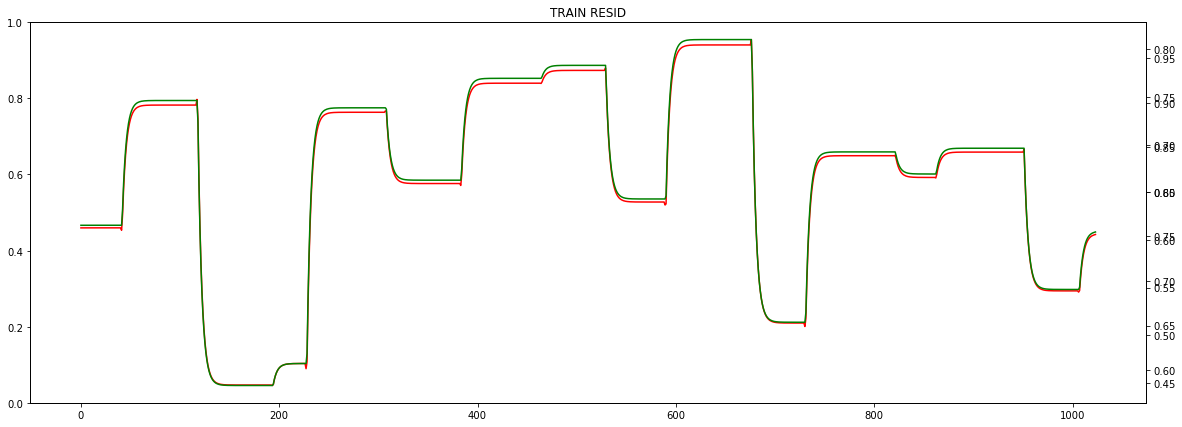

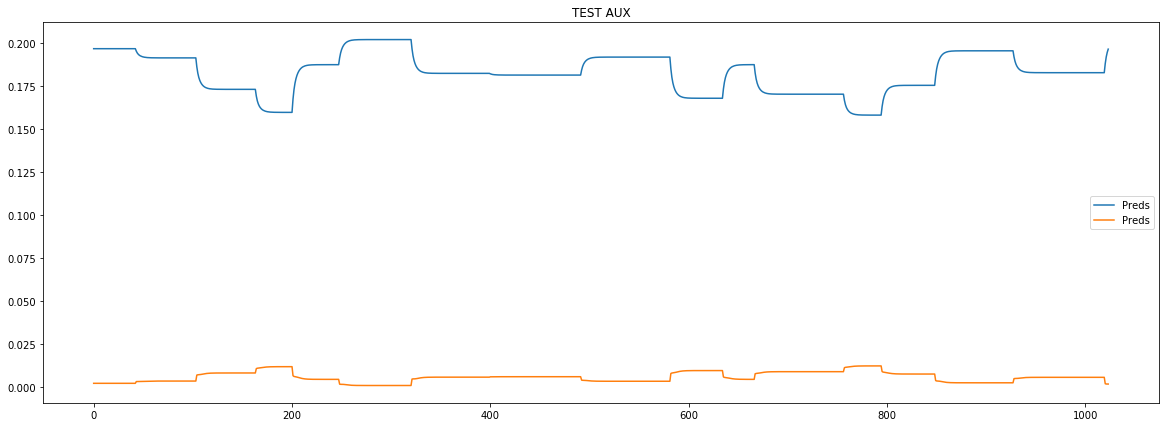

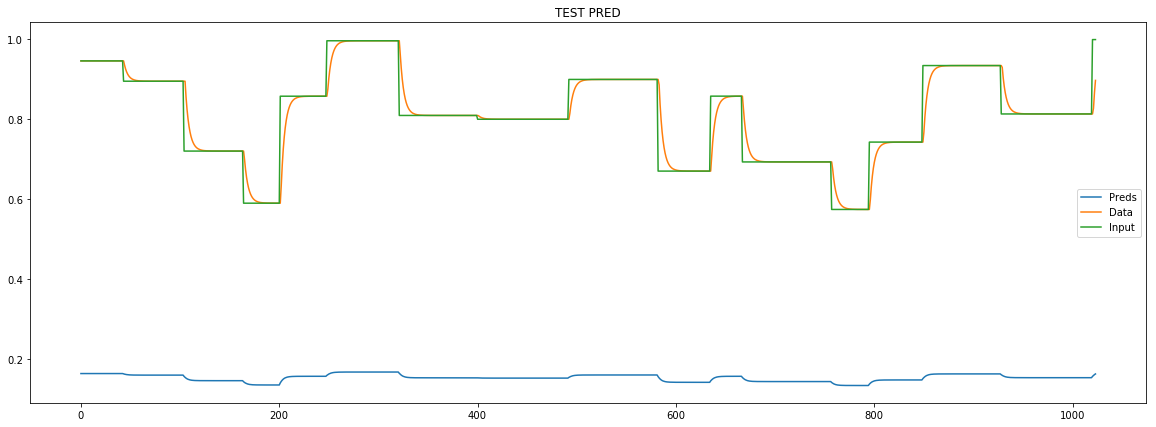

loss rate [0.9807399269182464]
Epoch [12] 
     train_loss[14.57026880614173] 
     eval_train[0.33062666532798457] 
     eval_test[0.36074371398849925]



aux preds: 0.1863124817609787 0.0066170343197882175
main loss 0.0
aux loss 10.638297685493644
const loss 0.1829664376206123
combined loss 10.821264123114256 


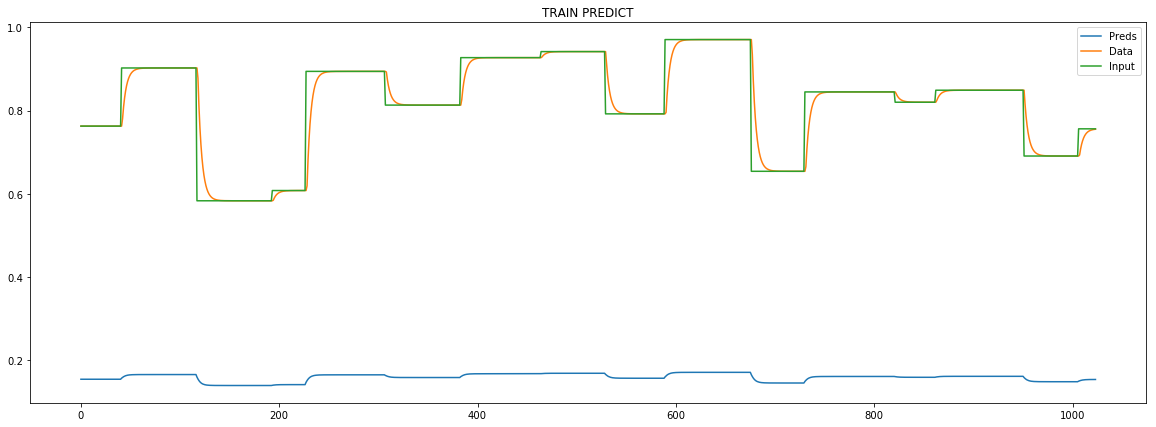

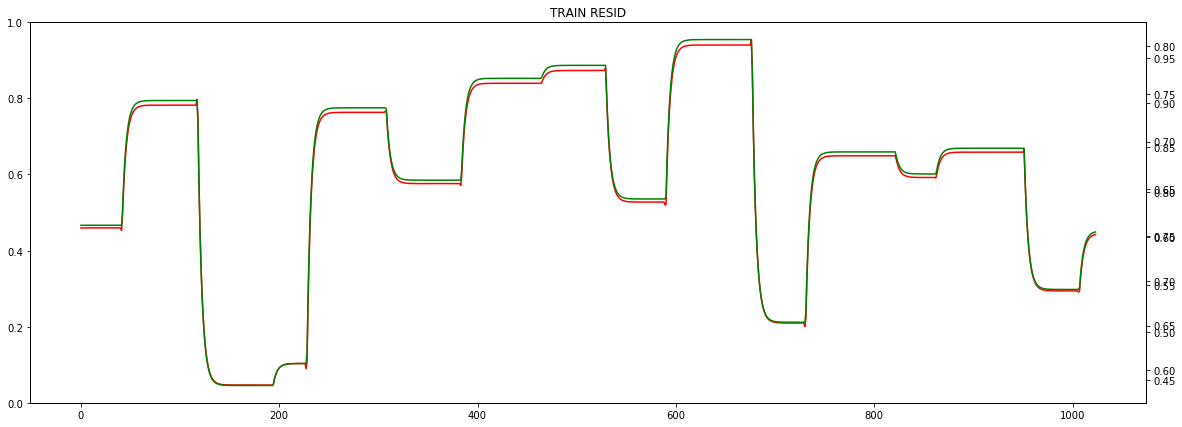

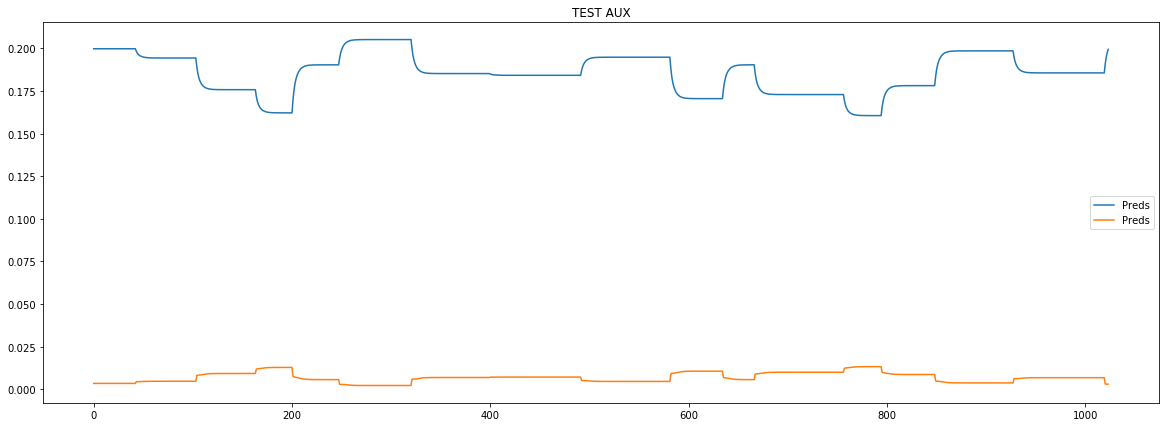

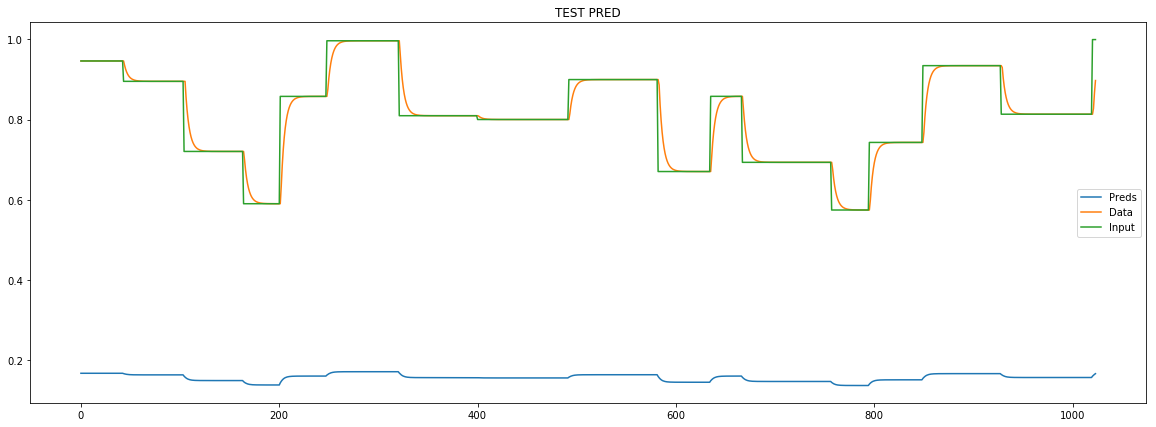

loss rate [0.9829678448322761]
Epoch [13] 
     train_loss[10.821264123114256] 
     eval_train[3.6757651642681313] 
     eval_test[0.31864481266926636]



aux preds: 0.19074489176273346 0.004710594192147255
main loss 0.0
aux loss 21.035232649793706
const loss 0.18891719943628862
combined loss 21.224149849229995 


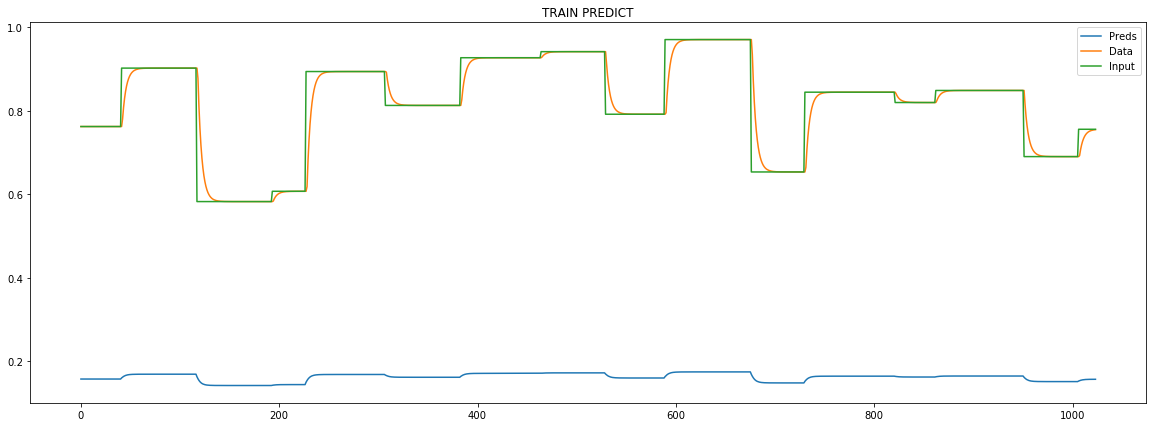

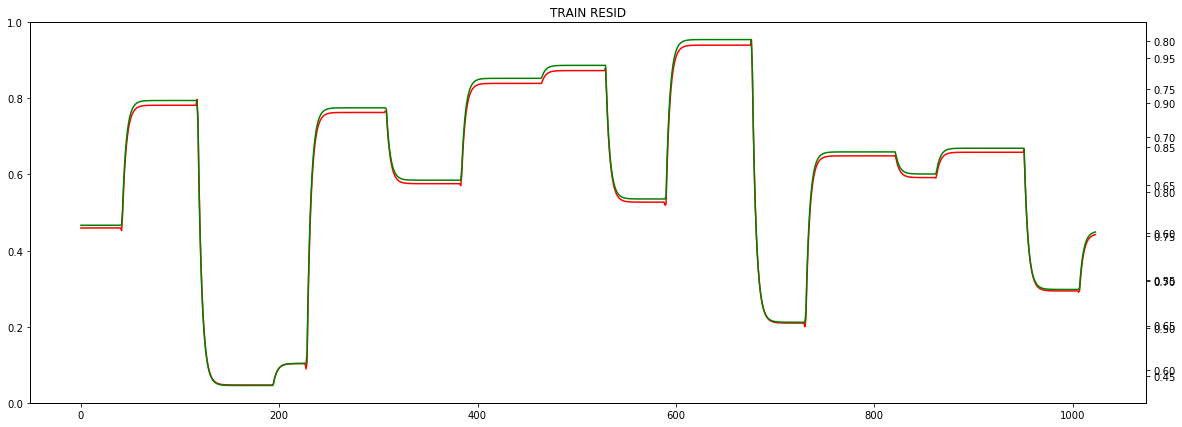

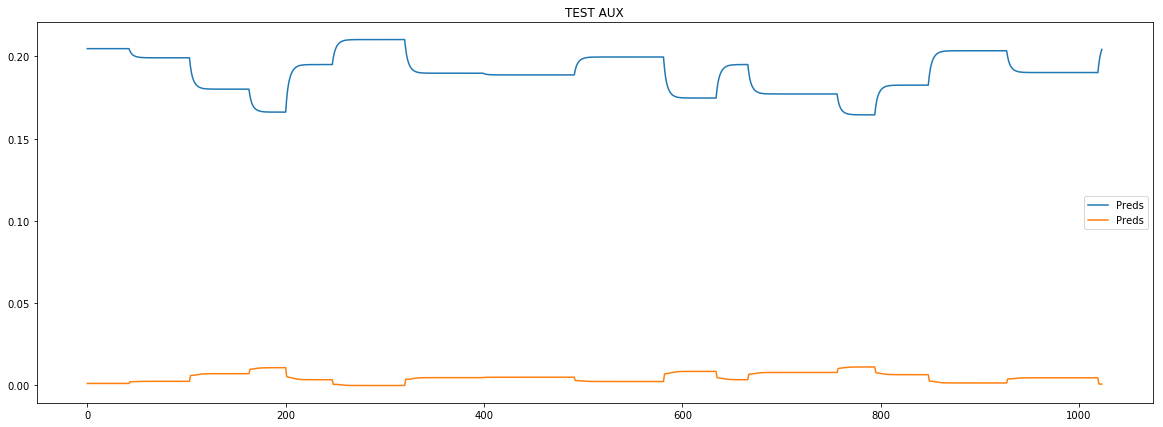

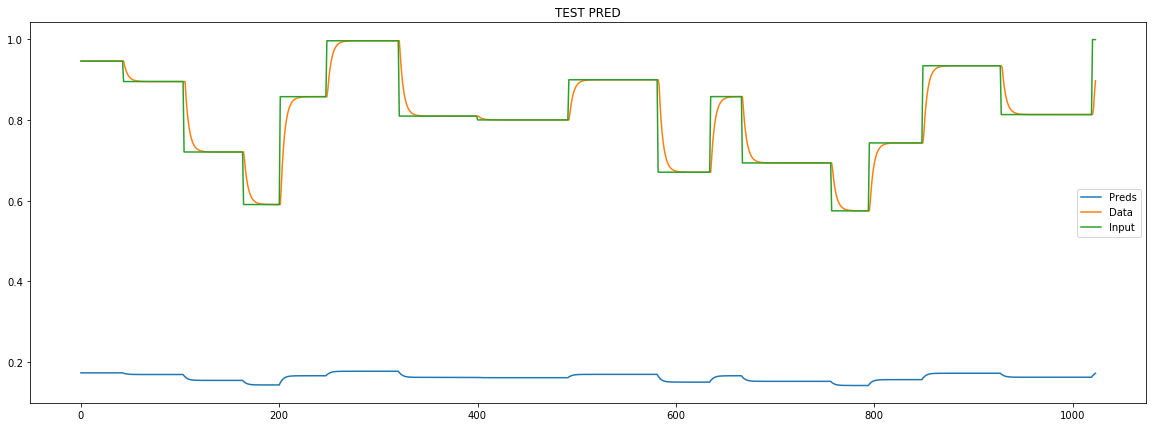

loss rate [-0.20339356456775715]
Epoch [14] 
     train_loss[21.224149849229995] 
     eval_train[0.41278975385312855] 
     eval_test[0.4448441883379763]



aux preds: 0.19457338750362396 0.005042371340095997
main loss 0.0
aux loss 13.707648225486851
const loss 0.19844416686548635
combined loss 13.906092392352338 


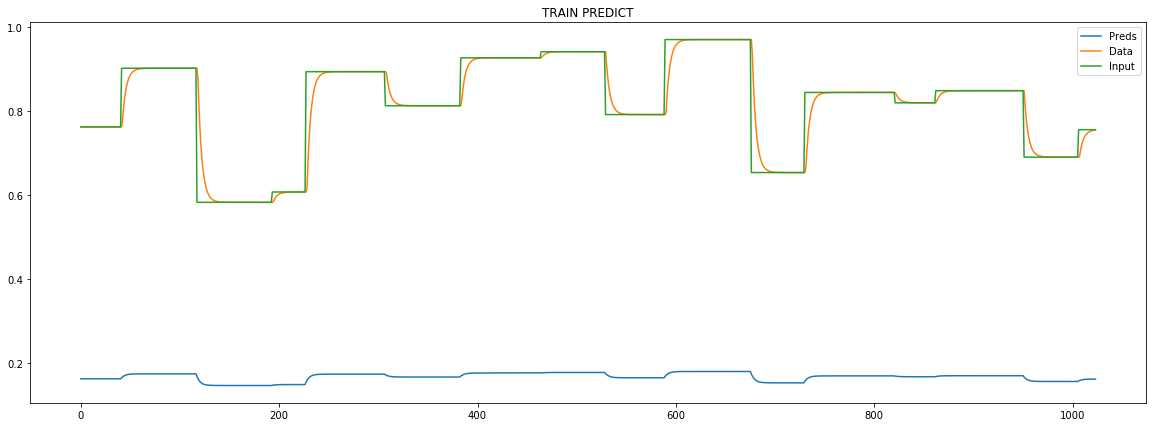

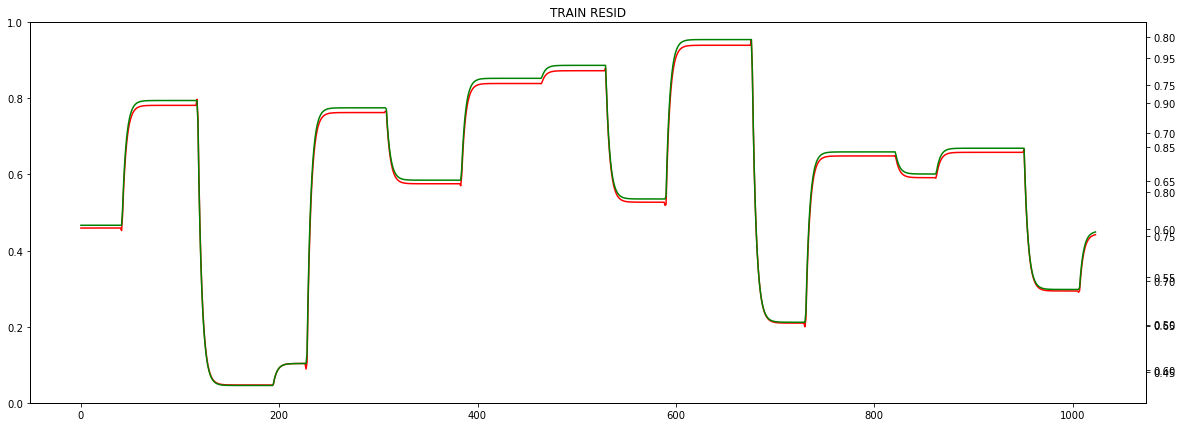

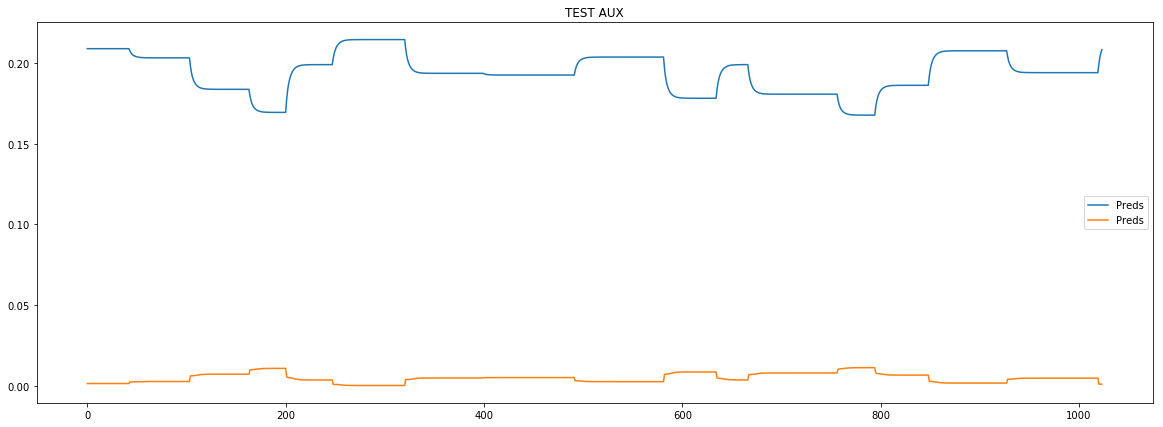

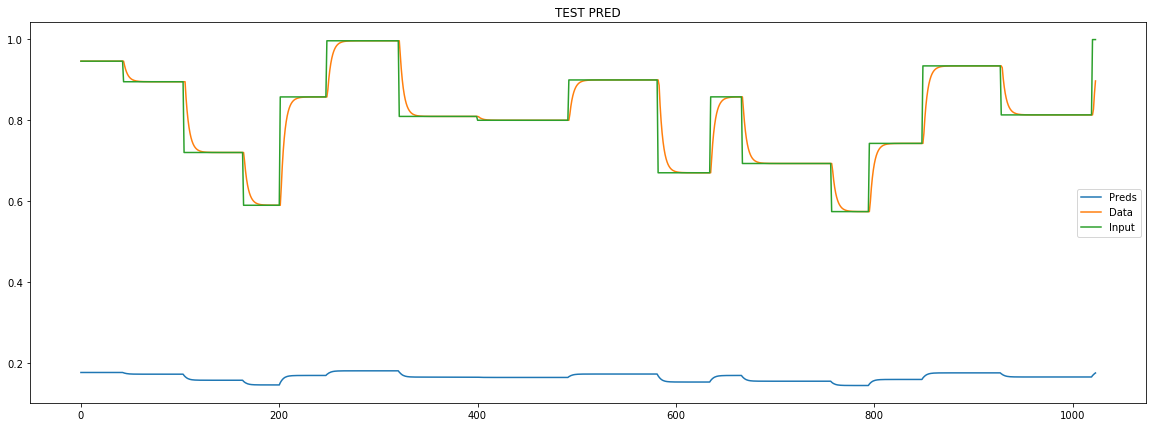

loss rate [-0.16812901180356632]
Epoch [15] 
     train_loss[13.906092392352338] 
     eval_train[0.40479849608471763] 
     eval_test[0.43774961680173874]



aux preds: 0.19874341785907745 0.005392662715166807
main loss 0.0
aux loss 10.201437253791552
const loss 0.20696229258408913
combined loss 10.408399546375641 


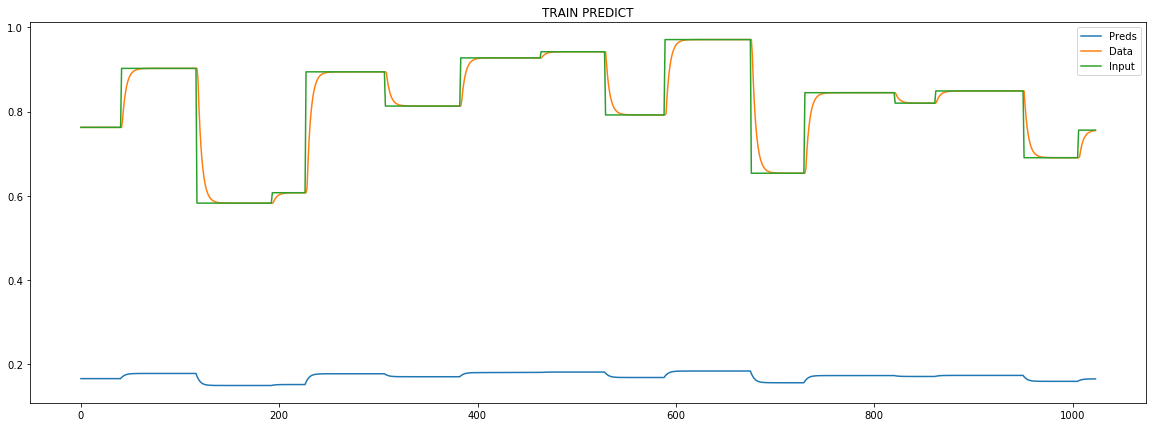

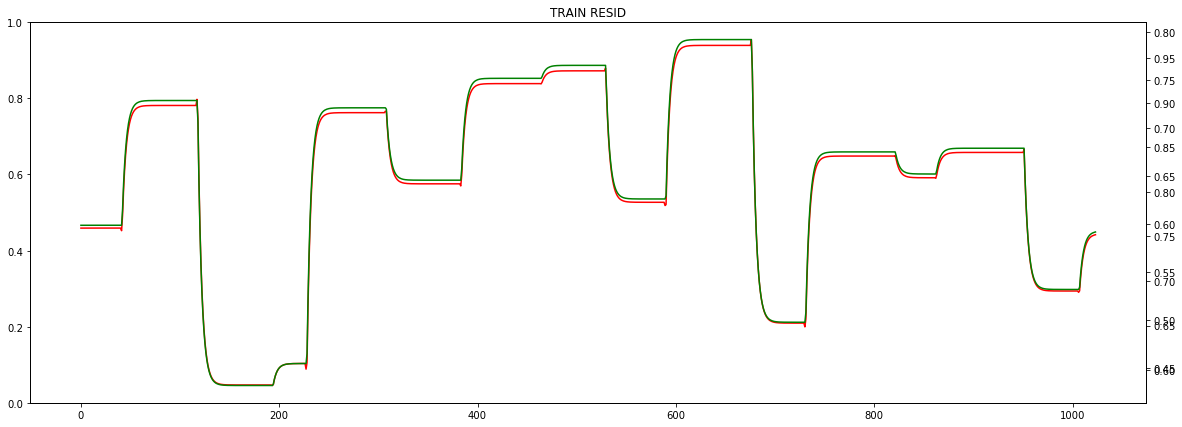

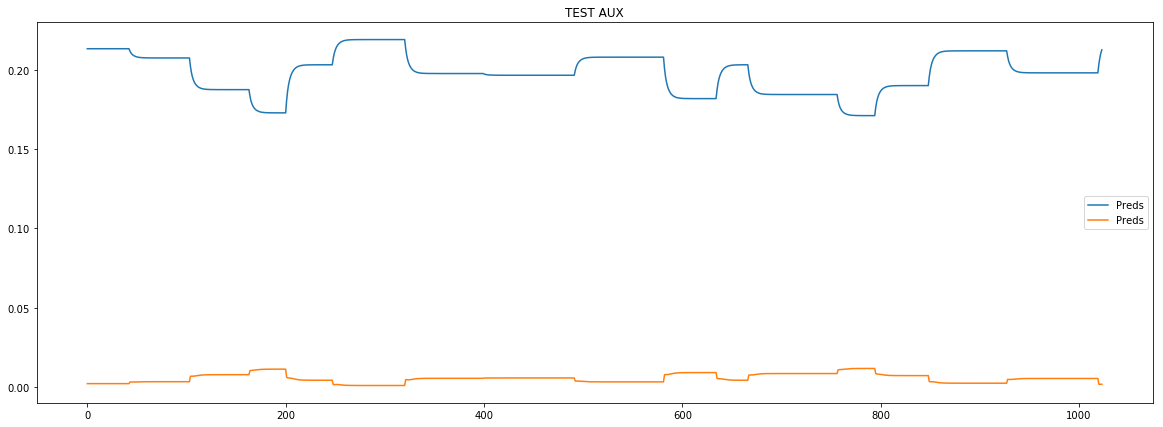

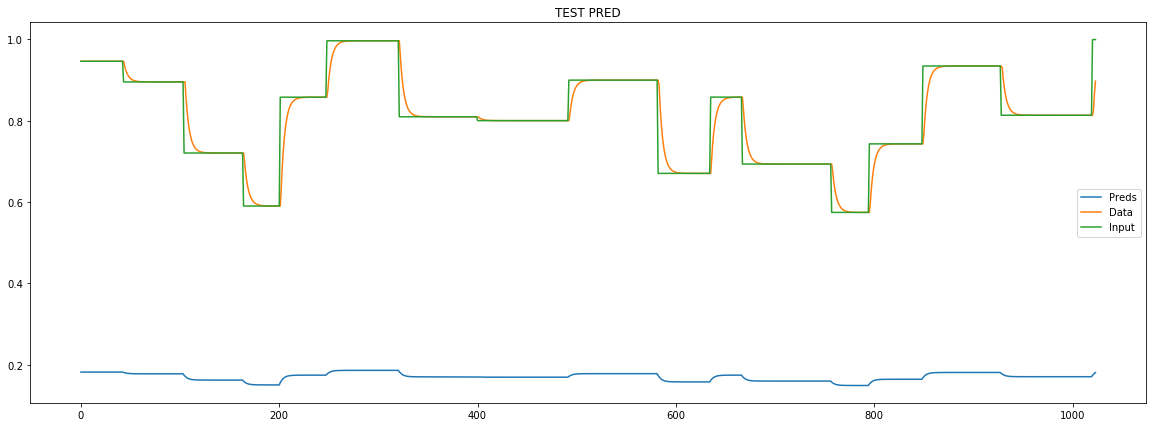

loss rate [-0.03065663406563801]
Epoch [16] 
     train_loss[10.408399546375641] 
     eval_train[0.3787872474640608] 
     eval_test[0.4126881835135547]



aux preds: 0.20267176628112793 0.00734055507928133
main loss 0.0
aux loss 13.509877232261575
const loss 0.2156649578649264
combined loss 13.725542190126502 


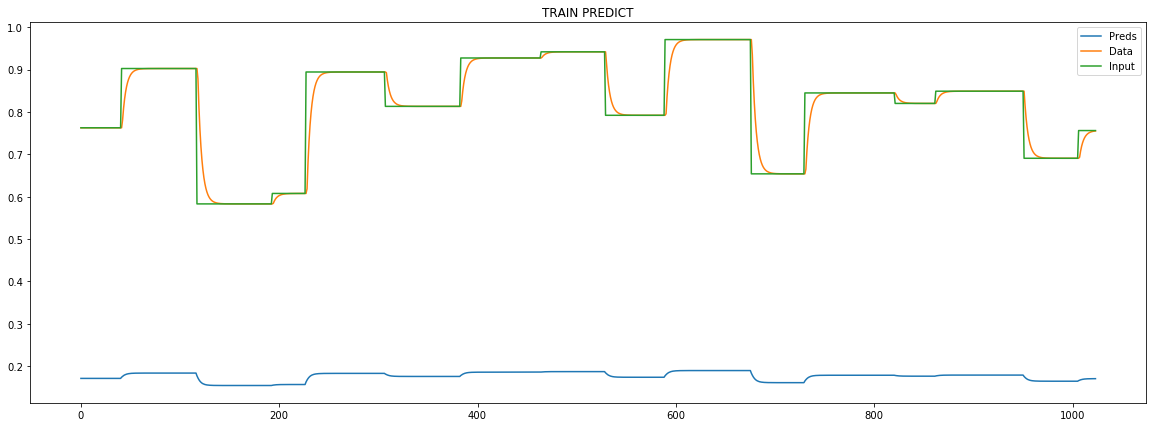

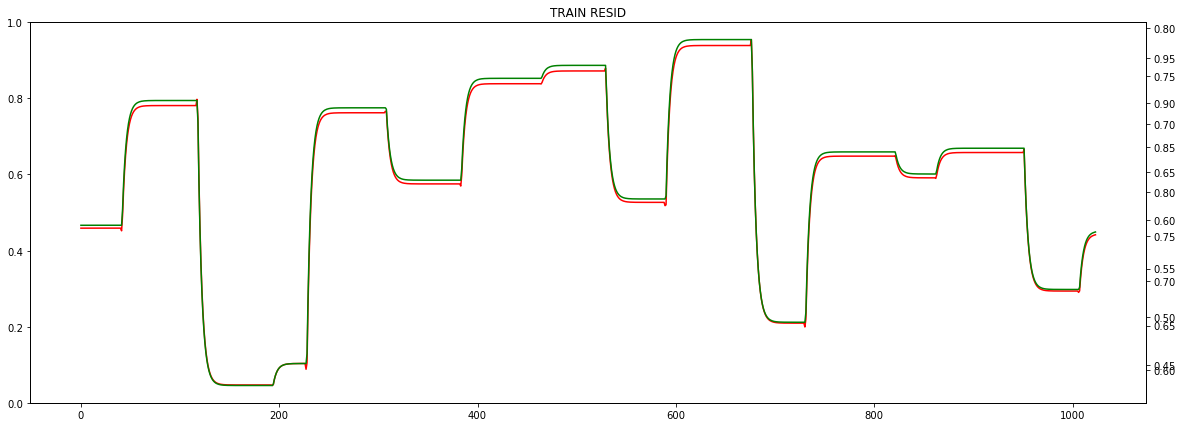

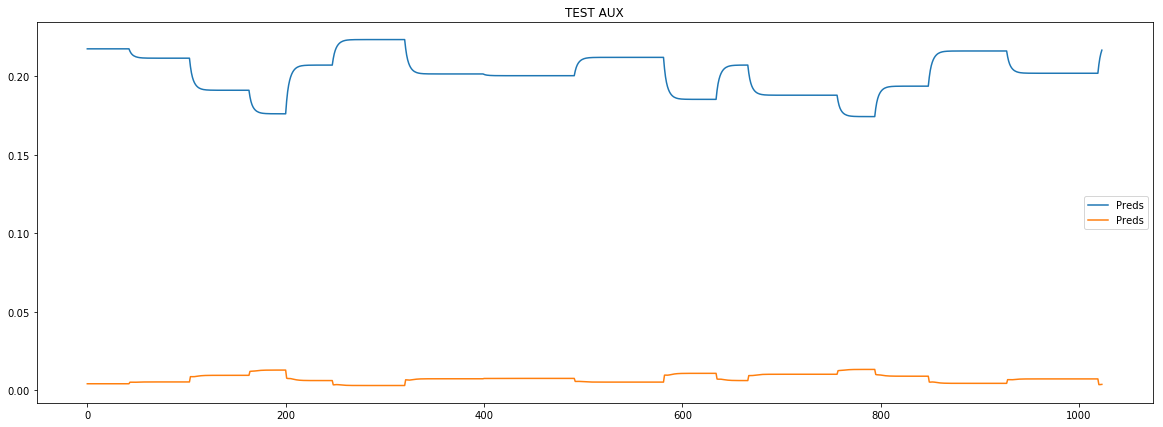

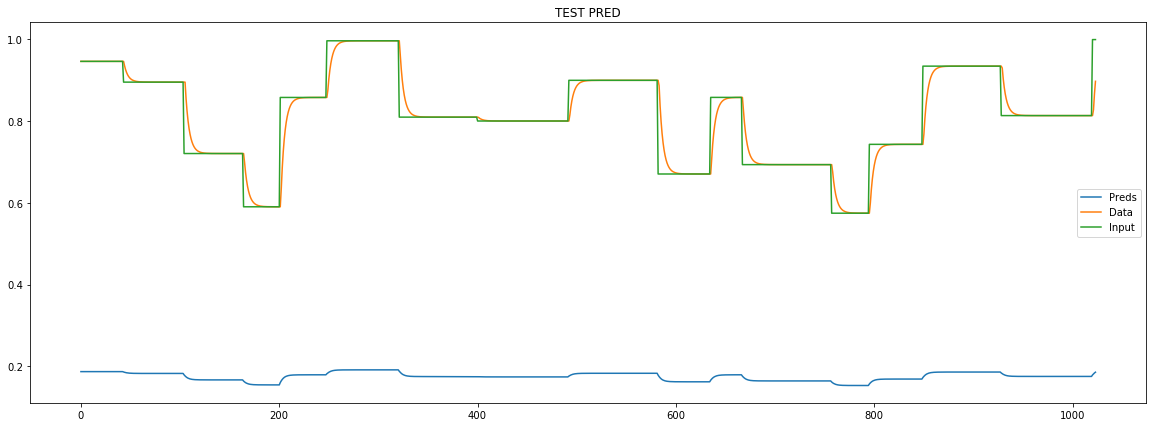

Epoch    17: reducing learning rate of group 0 to 9.0000e-05.
loss rate [0.23219220948149877]
Epoch [17] 
     train_loss[13.725542190126502] 
     eval_train[6.618289752755888] 
     eval_test[0.3315092006020925]



aux preds: 0.20440854132175446 0.007093635853379965
main loss 0.0
aux loss 16.07728402864618
const loss 0.22198770582102811
combined loss 16.299271734467208 


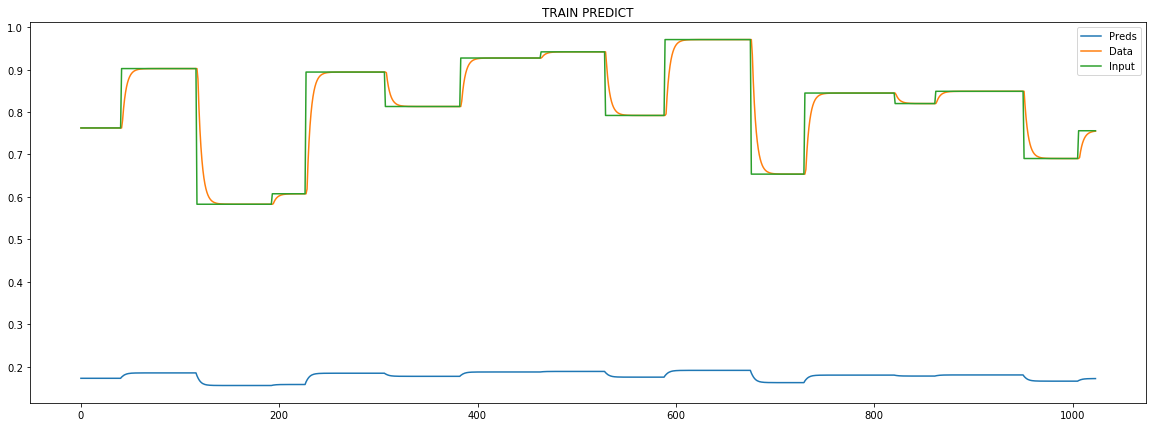

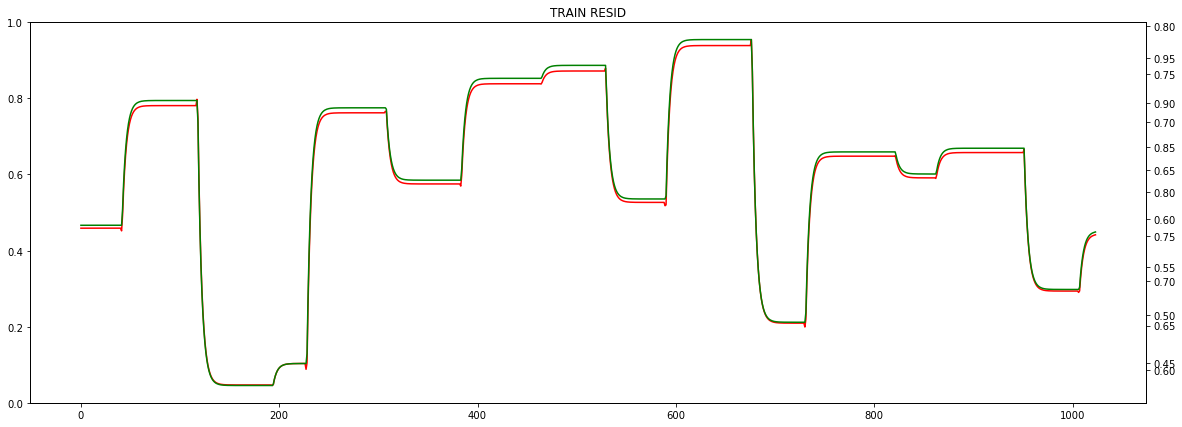

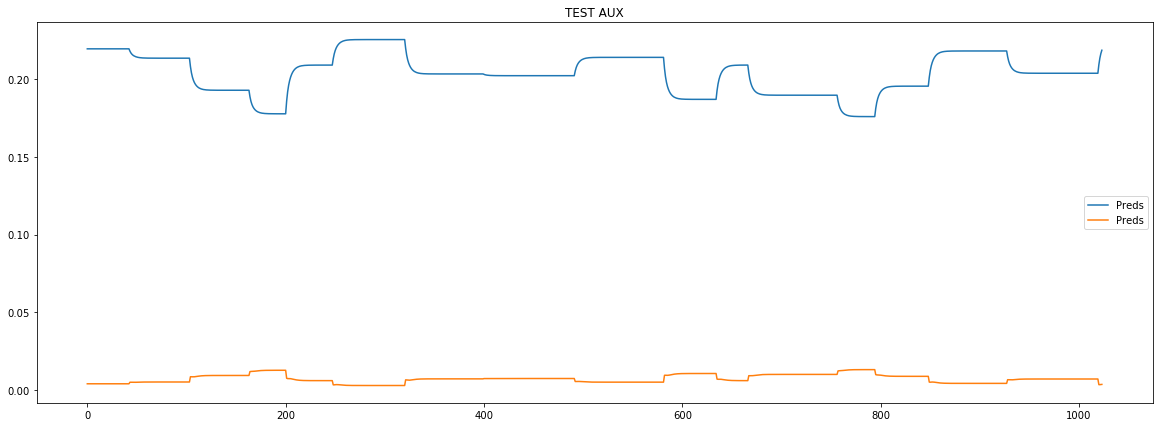

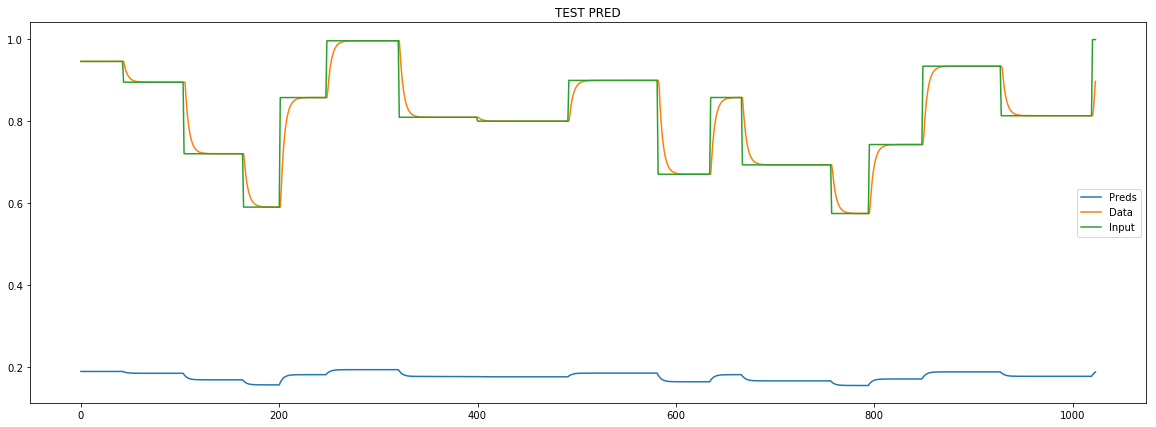

loss rate [0.11925517036225142]
Epoch [18] 
     train_loss[16.299271734467208] 
     eval_train[6.5823484962232985] 
     eval_test[0.346997903321277]



aux preds: 0.2061883956193924 0.00684196874499321
main loss 0.0
aux loss 16.026299018914308
const loss 0.2257182033589253
combined loss 16.252017222273235 


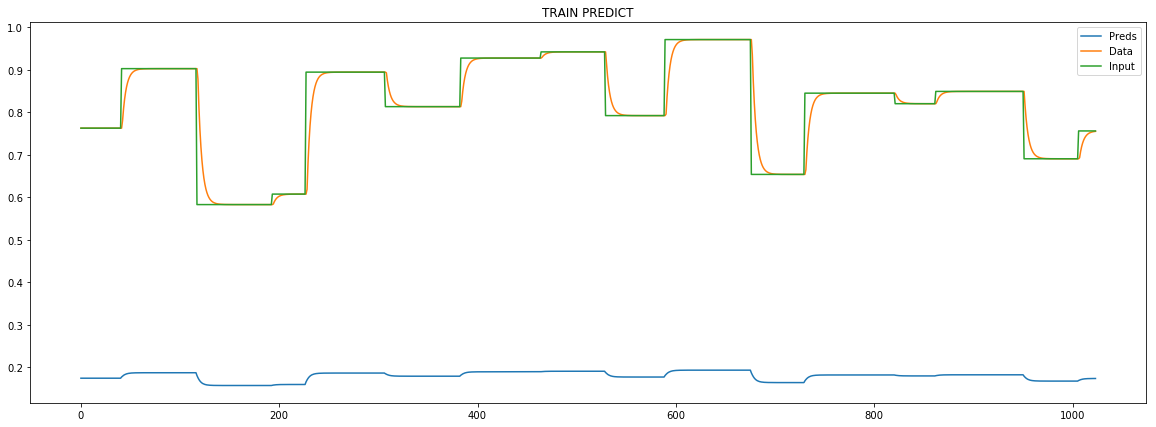

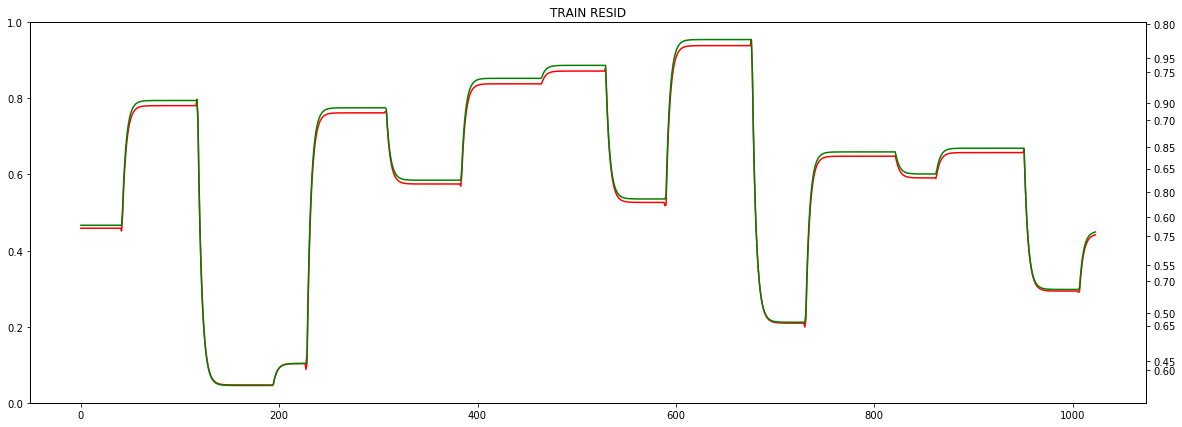

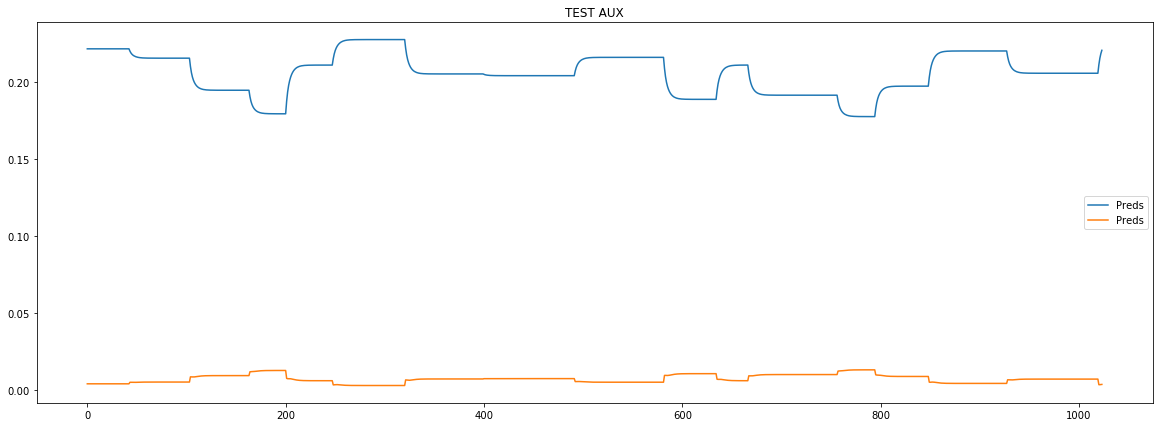

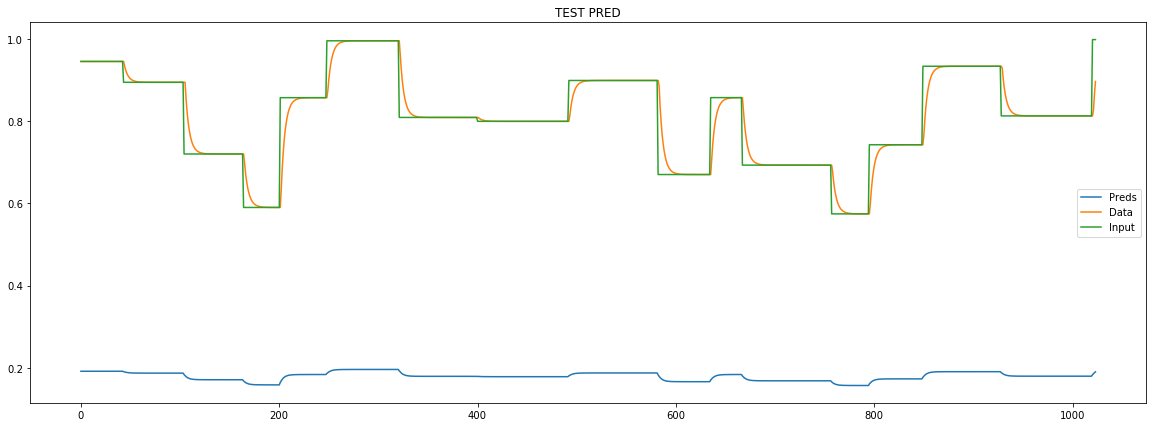

loss rate [-0.0032137792573154744]
Epoch [19] 
     train_loss[16.252017222273235] 
     eval_train[3.392938888954142] 
     eval_test[0.36490071607245644]



aux preds: 0.2076934576034546 0.00746214808896184
main loss 0.0
aux loss 15.81475053824341
const loss 0.22972339305740136
combined loss 16.04447393130081 


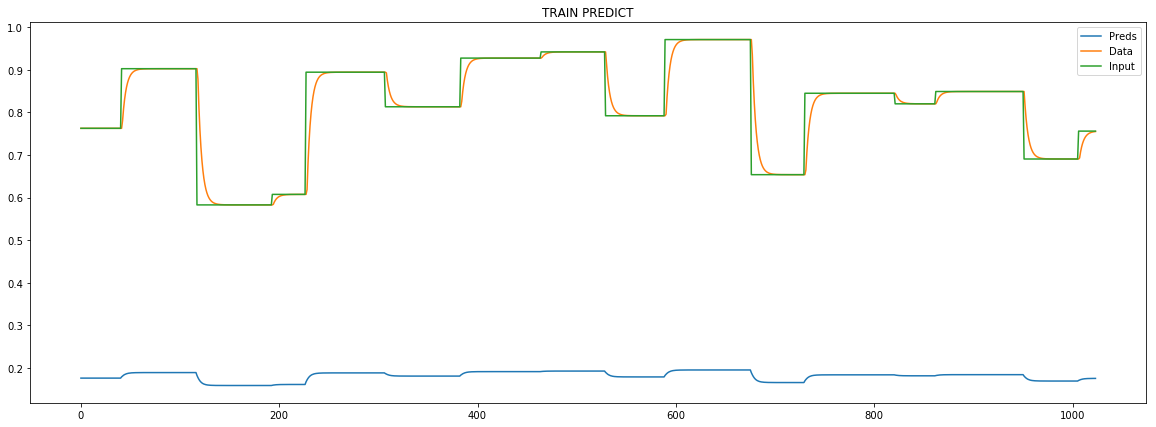

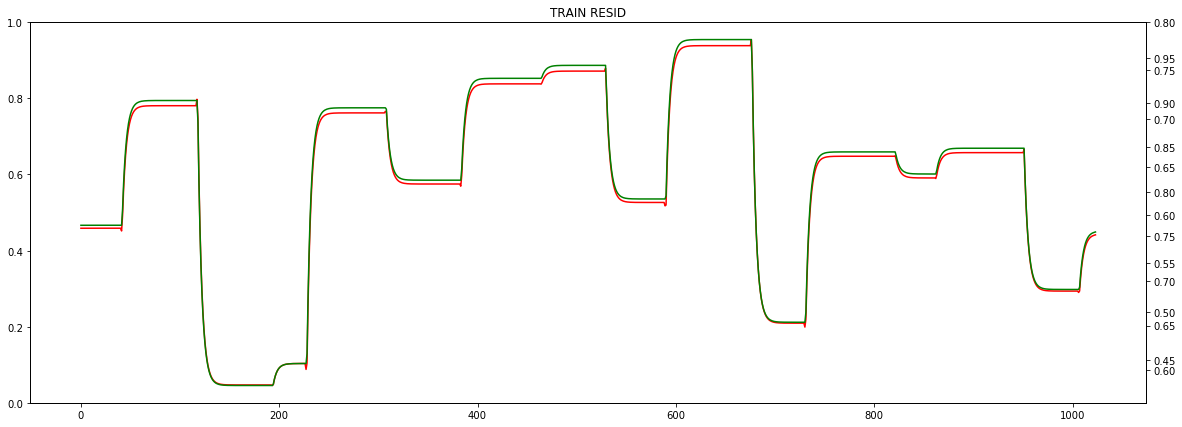

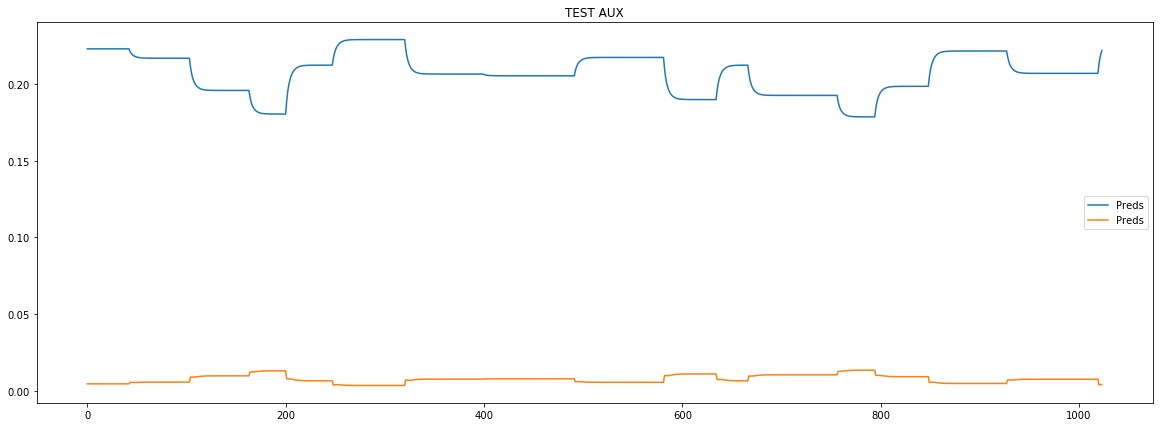

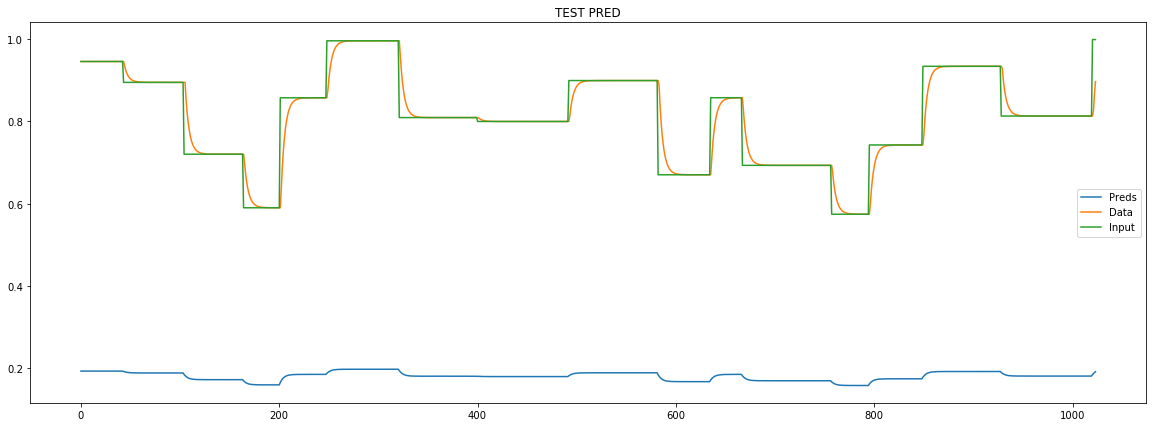

loss rate [0.013612228547958849]
Epoch [20] 
     train_loss[16.04447393130081] 
     eval_train[6.478122205616763] 
     eval_test[0.34306823809377174]



aux preds: 0.2095915973186493 0.007416962645947933
main loss 0.0
aux loss 12.502578303146247
const loss 0.2340688994870736
combined loss 12.736647202633321 


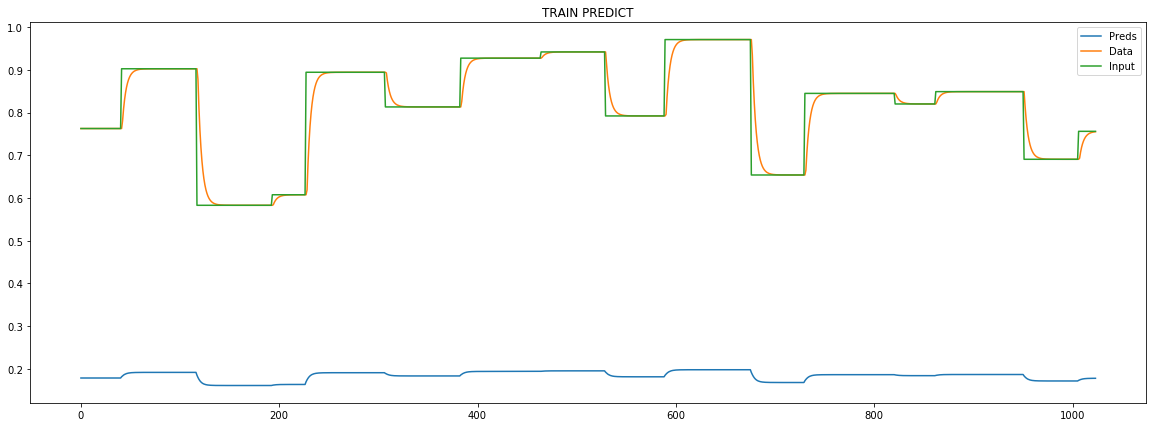

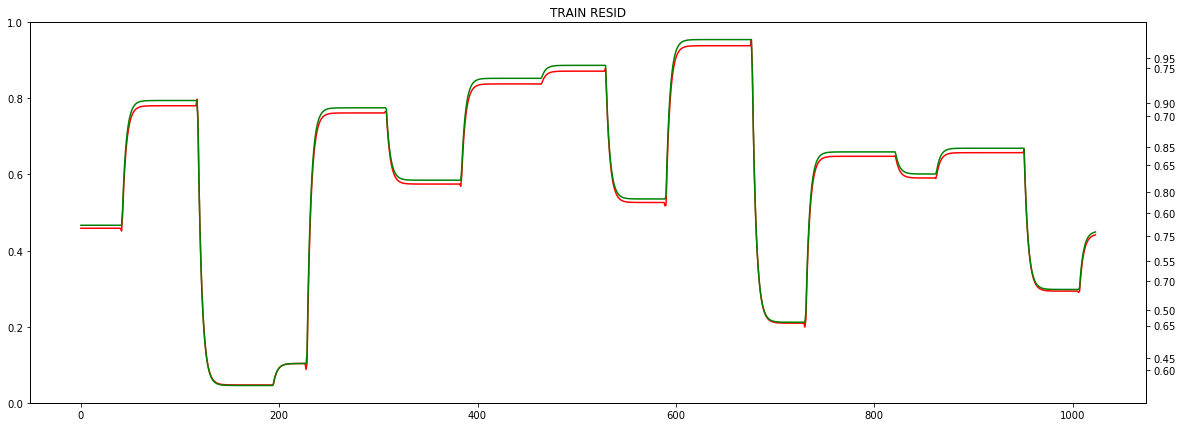

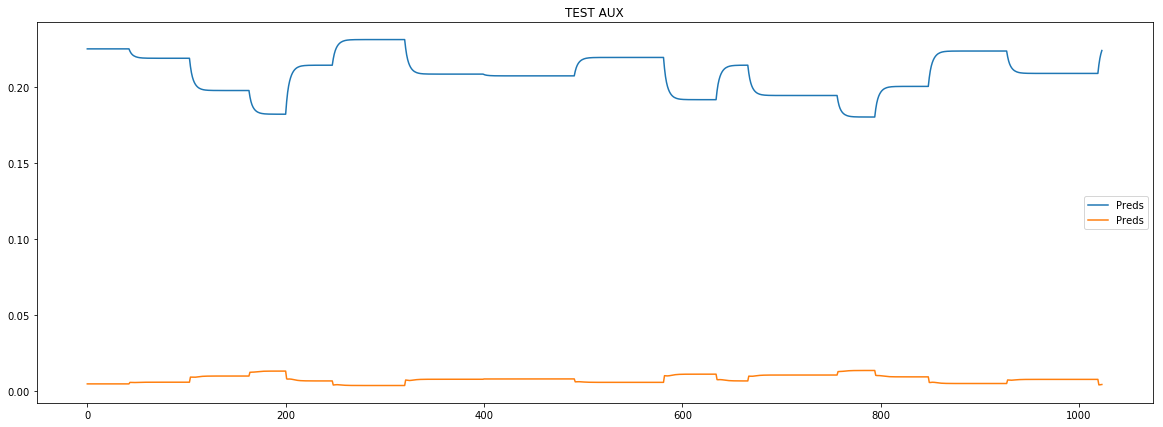

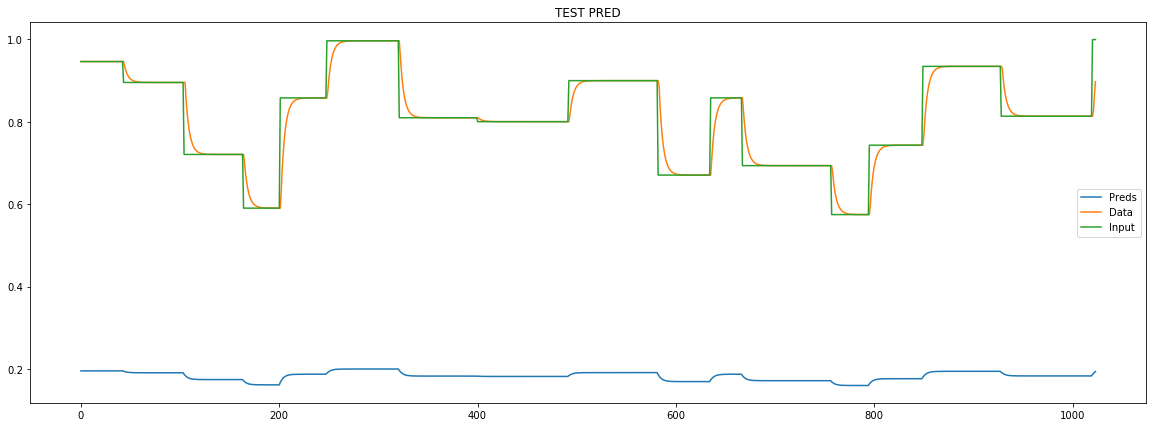

loss rate [-20.960145526323302]
Epoch [21] 
     train_loss[12.736647202633321] 
     eval_train[6.426356380554632] 
     eval_test[7.722408571957864]



aux preds: 0.21161668002605438 0.007350303698331118
main loss 0.0
aux loss 15.5396587153037
const loss 0.23842089107403389
combined loss 15.778079606377734 


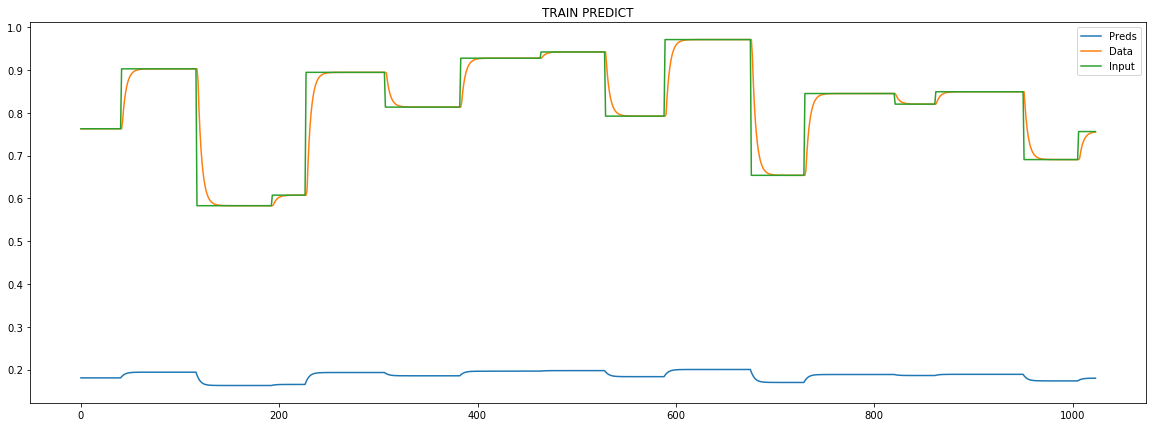

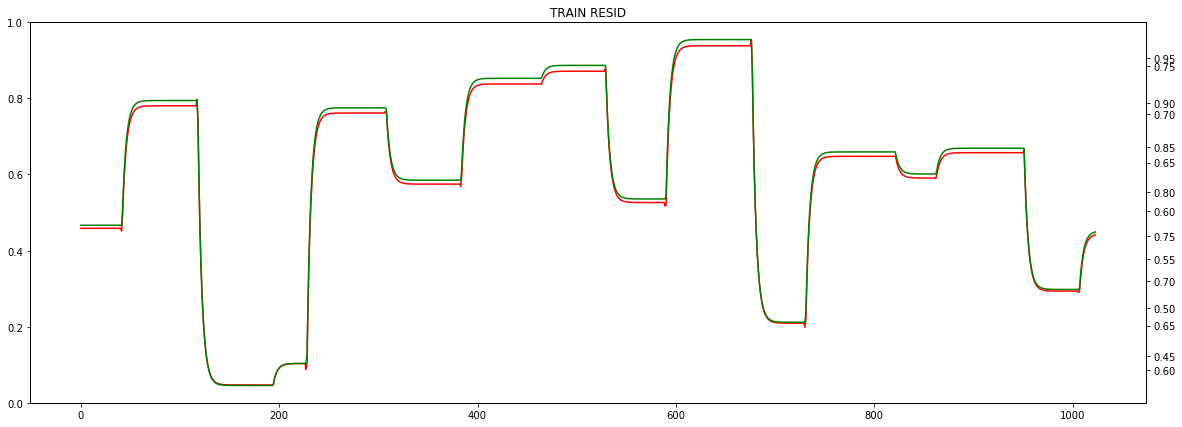

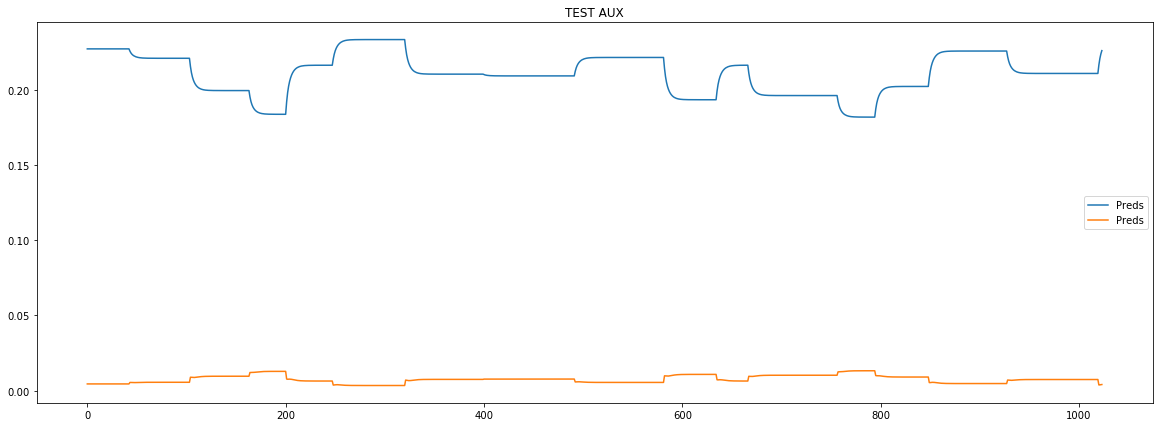

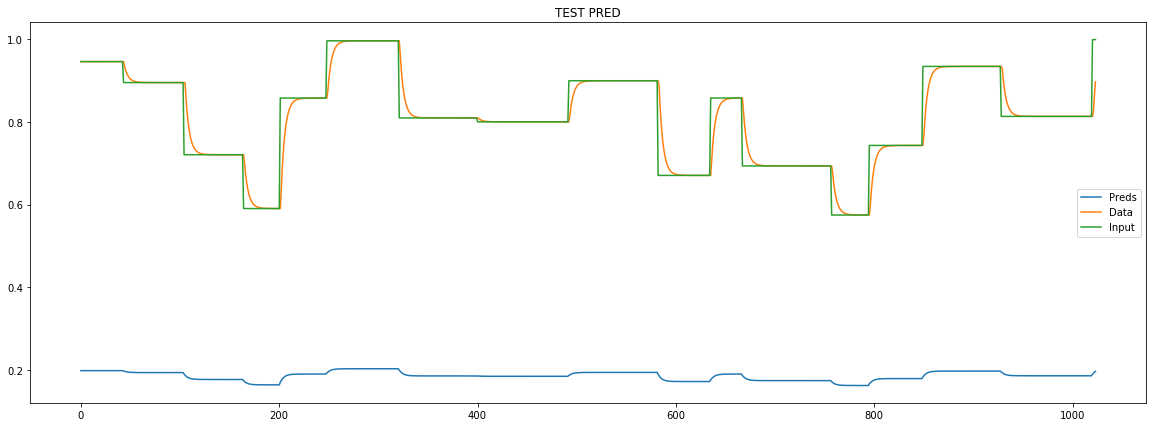

loss rate [0.873551289298742]
Epoch [22] 
     train_loss[15.778079606377734] 
     eval_train[6.377169187180698] 
     eval_test[0.35533678963441745]



aux preds: 0.21372827887535095 0.007356277201324701
main loss 0.0
aux loss 15.392285290962228
const loss 0.24348696378561166
combined loss 15.63577225474784 


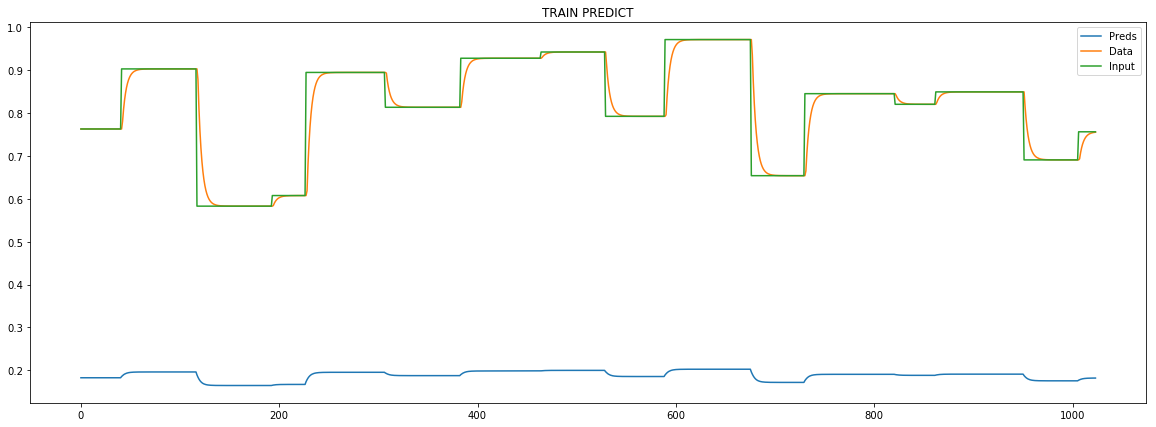

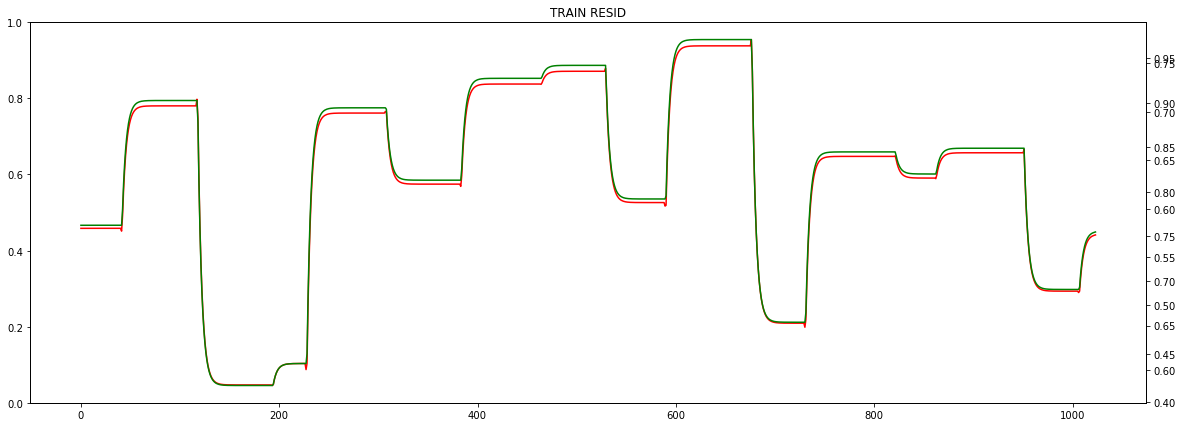

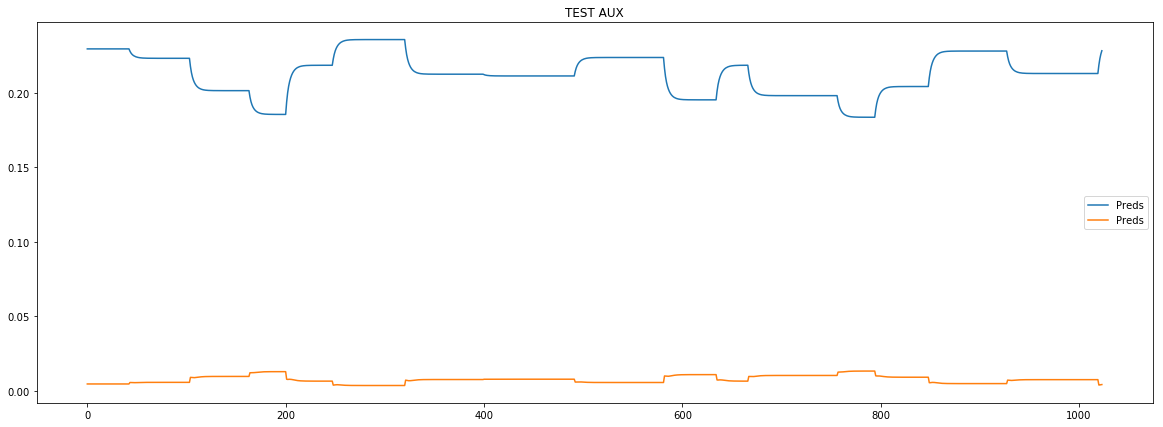

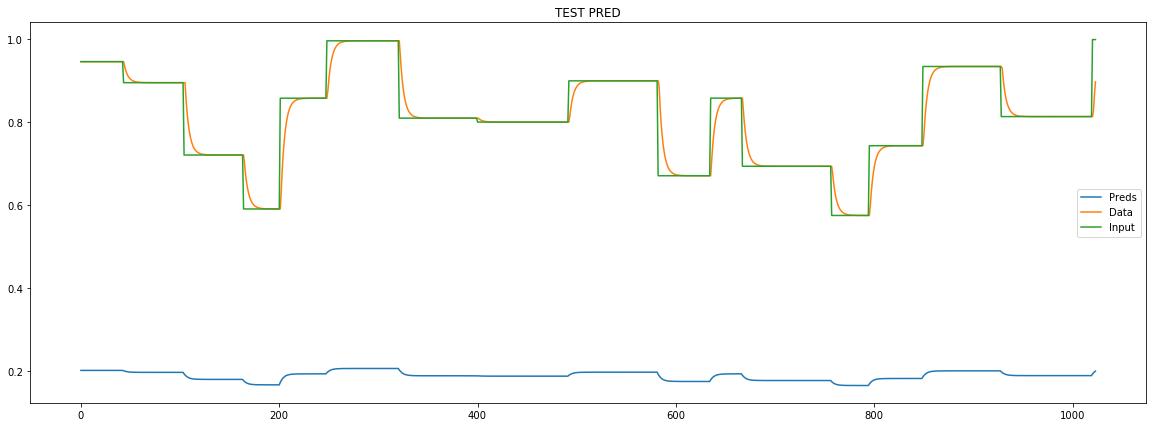

Epoch    23: reducing learning rate of group 0 to 2.7000e-05.
loss rate [0.8712363809368028]
Epoch [23] 
     train_loss[15.63577225474784] 
     eval_train[6.323413533516801] 
     eval_test[0.36143147818405524]



aux preds: 0.21428440511226654 0.007670033257454634
main loss 0.0
aux loss 15.299598590936512
const loss 0.24709093943238258
combined loss 15.546689530368894 


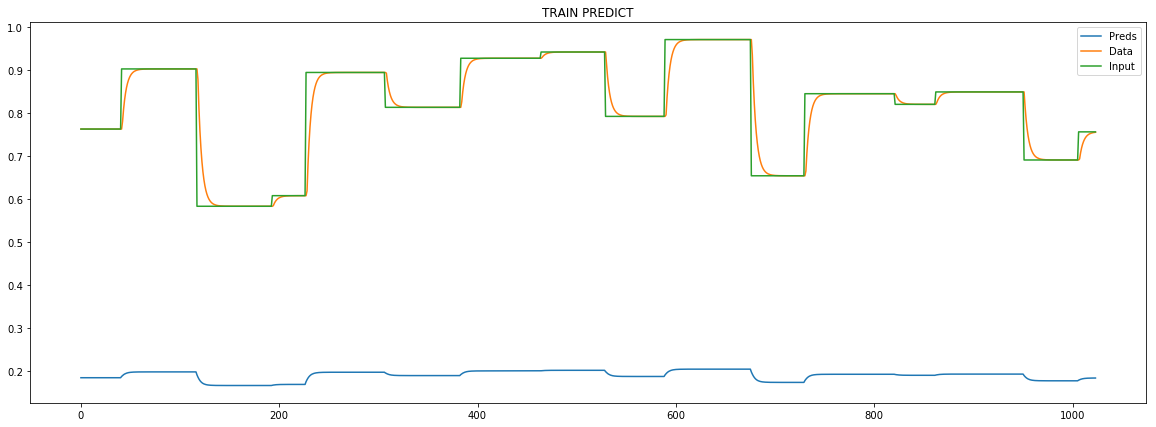

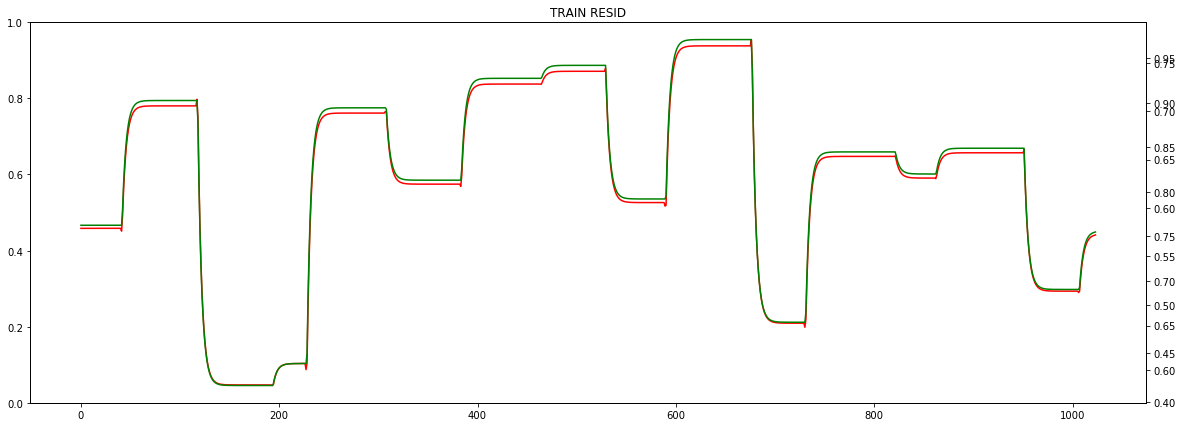

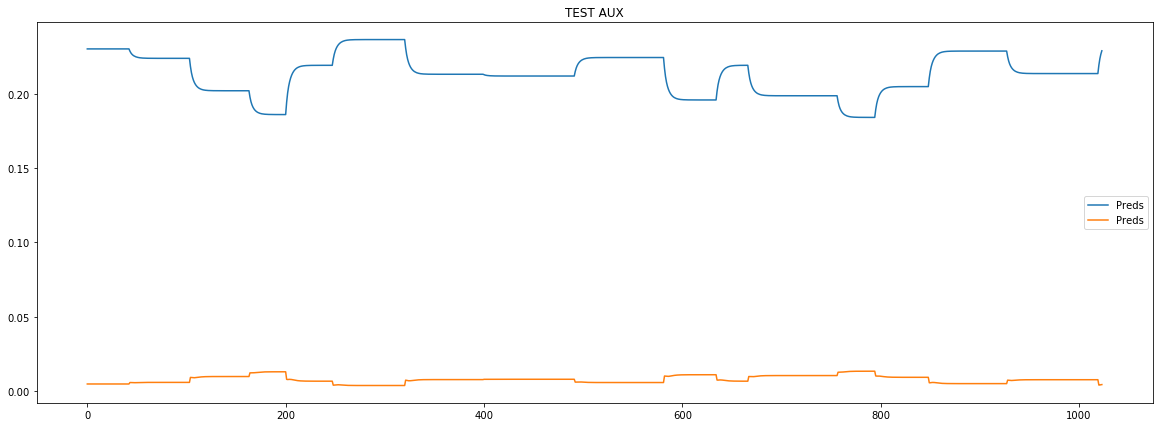

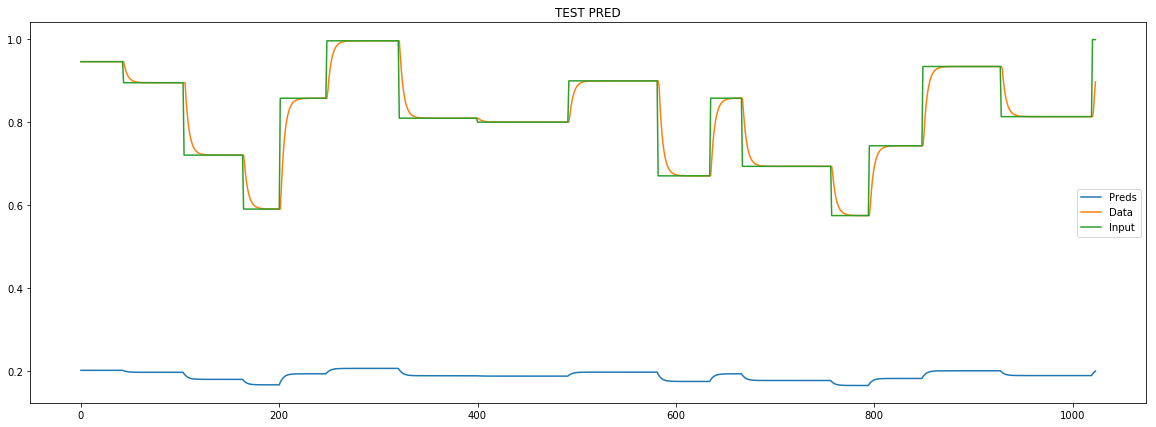

loss rate [-4.273452694505501]
Epoch [24] 
     train_loss[15.546689530368894] 
     eval_train[12.468898803712085] 
     eval_test[14.834533281708982]



aux preds: 0.2149636149406433 0.007711747661232948
main loss 0.0
aux loss 15.248594680442833
const loss 0.2486826588328068
combined loss 15.49727733927564 


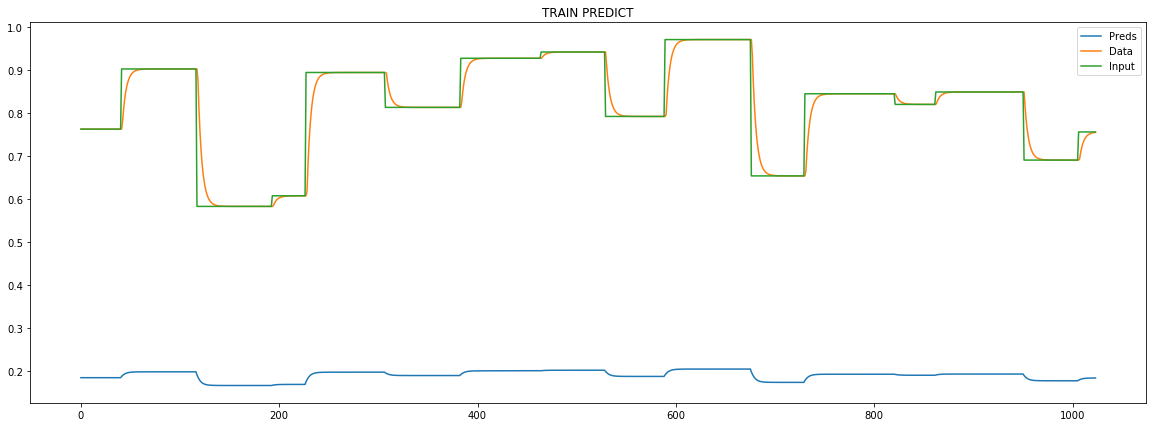

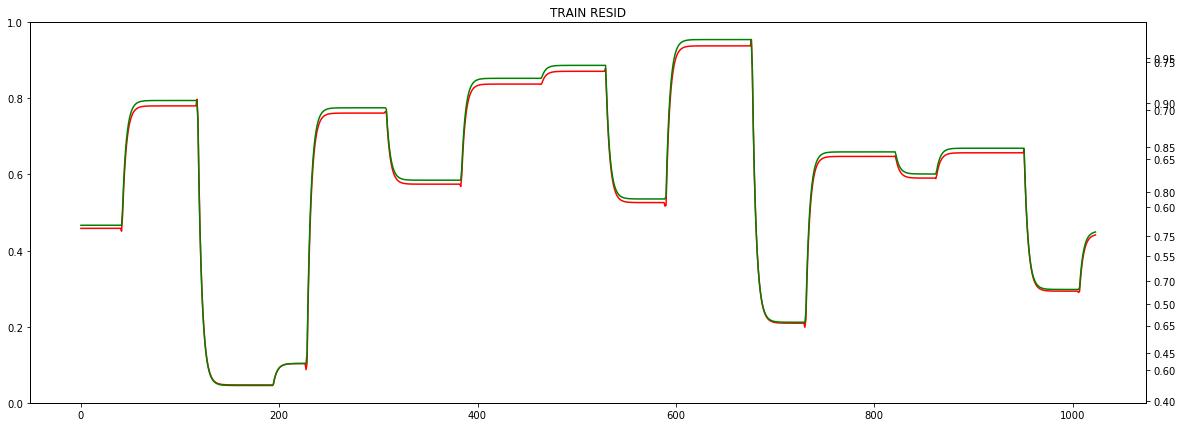

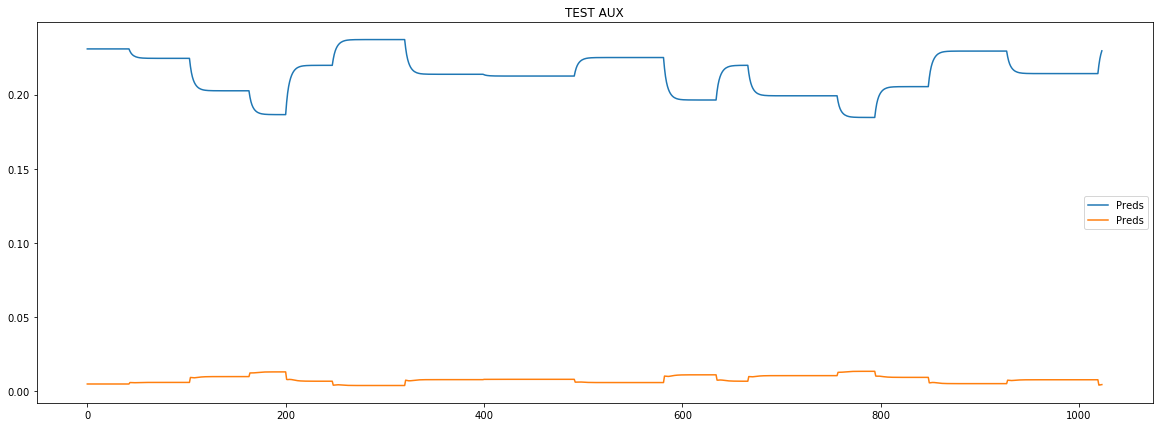

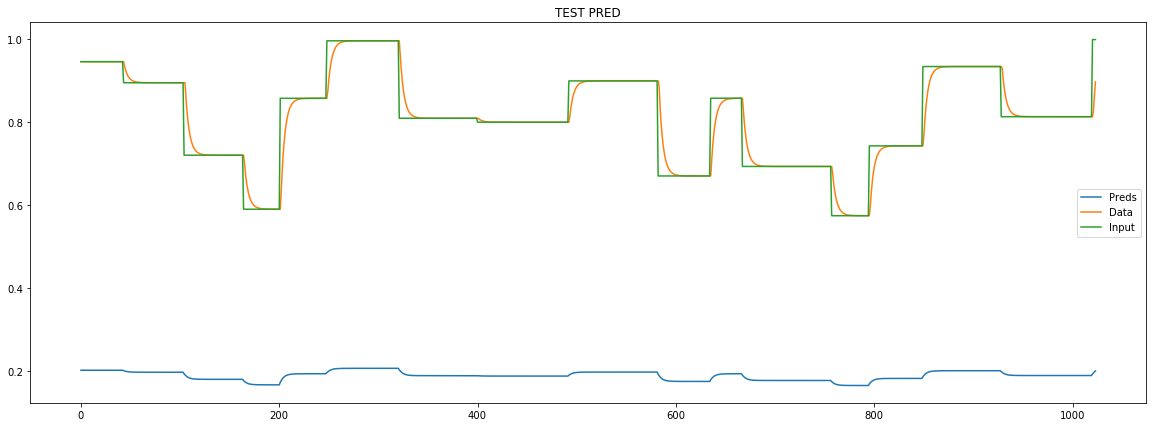

loss rate [-1.8529878980681933]
Epoch [25] 
     train_loss[15.49727733927564] 
     eval_train[15.527844412682148] 
     eval_test[14.789225040003657]



aux preds: 0.215596541762352 0.00791229959577322
main loss 0.0
aux loss 15.165564664138051
const loss 0.25049009174108505
combined loss 15.416054755879136 


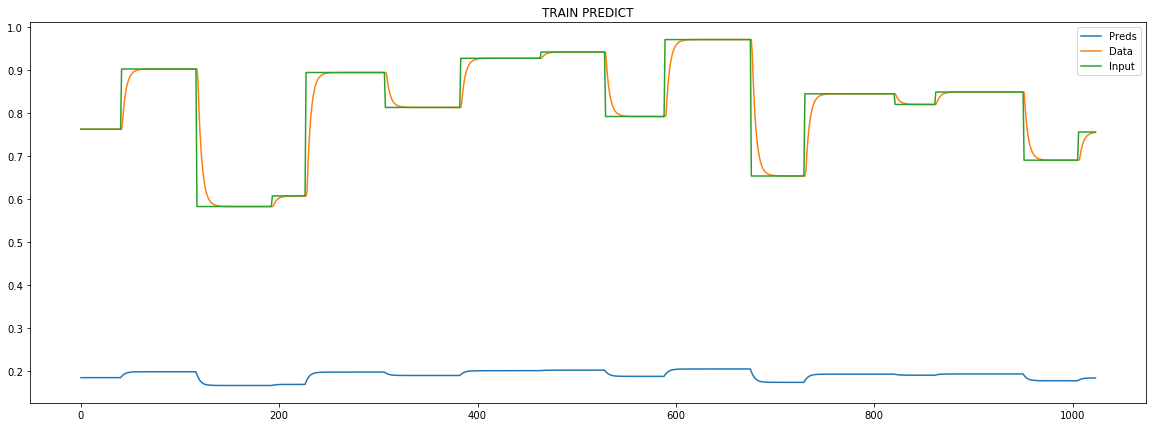

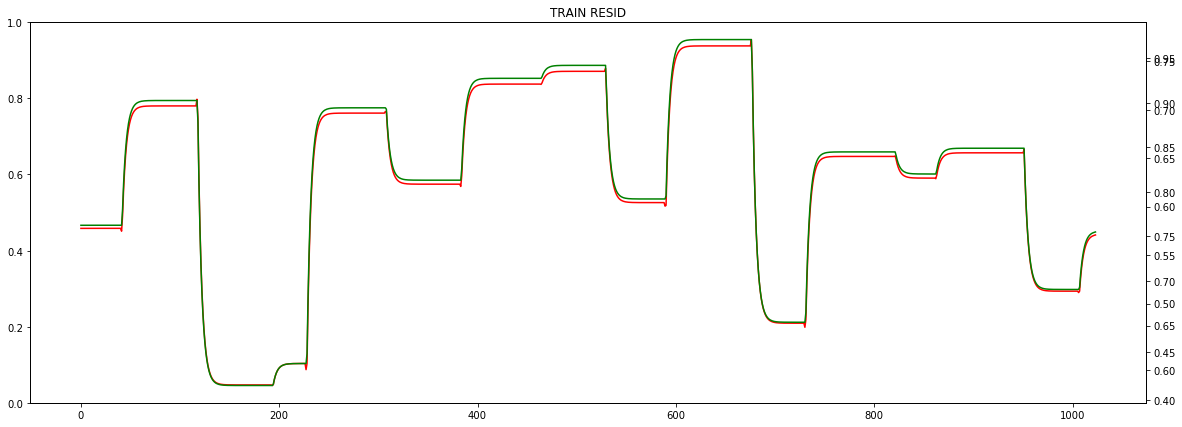

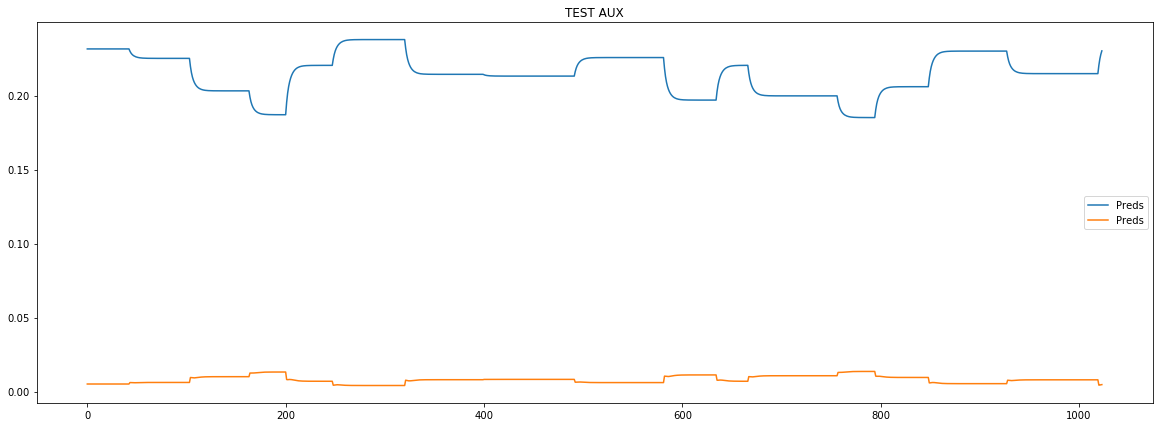

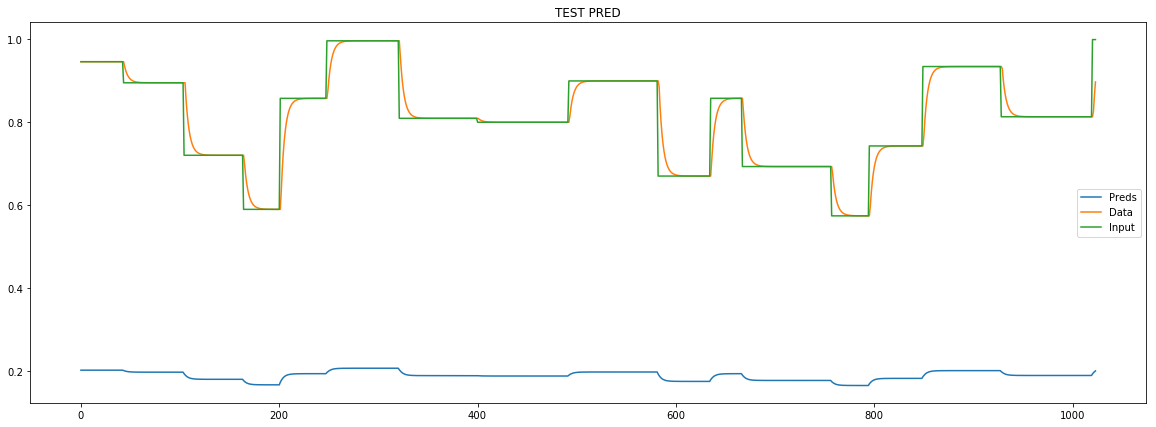

loss rate [-0.4747010291532363]
Epoch [26] 
     train_loss[15.416054755879136] 
     eval_train[21.56033048965037] 
     eval_test[14.739730085754259]



aux preds: 0.21640171110630035 0.007812945172190666
main loss 0.0
aux loss 15.197765993061834
const loss 0.25238223230609524
combined loss 15.45014822536793 


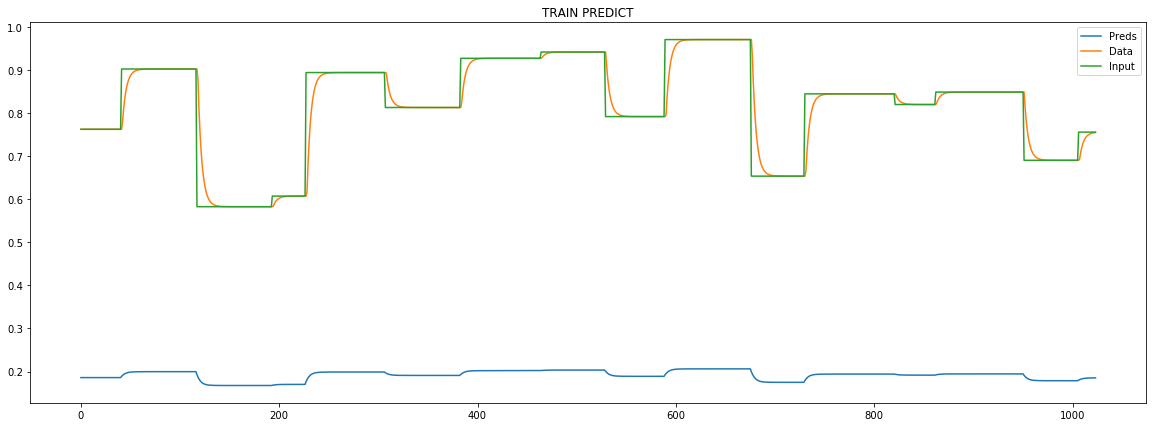

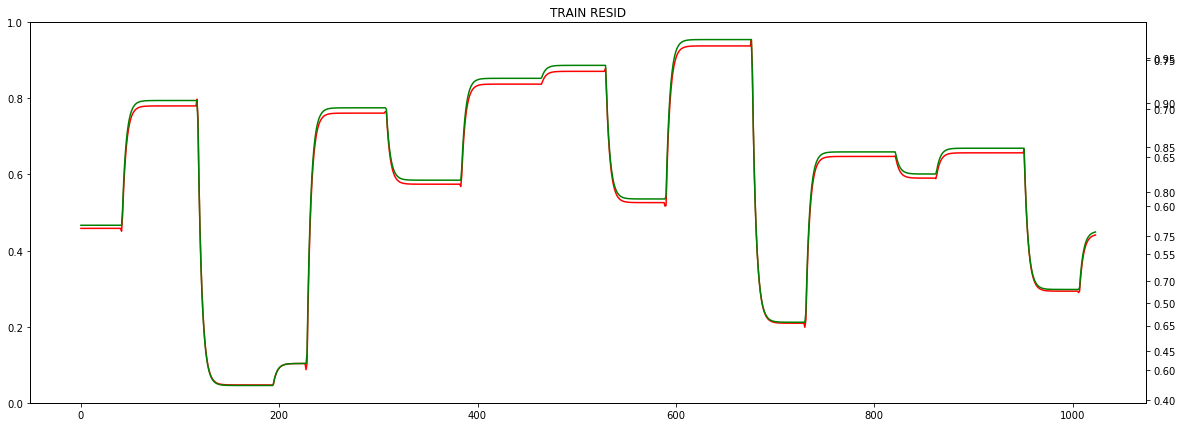

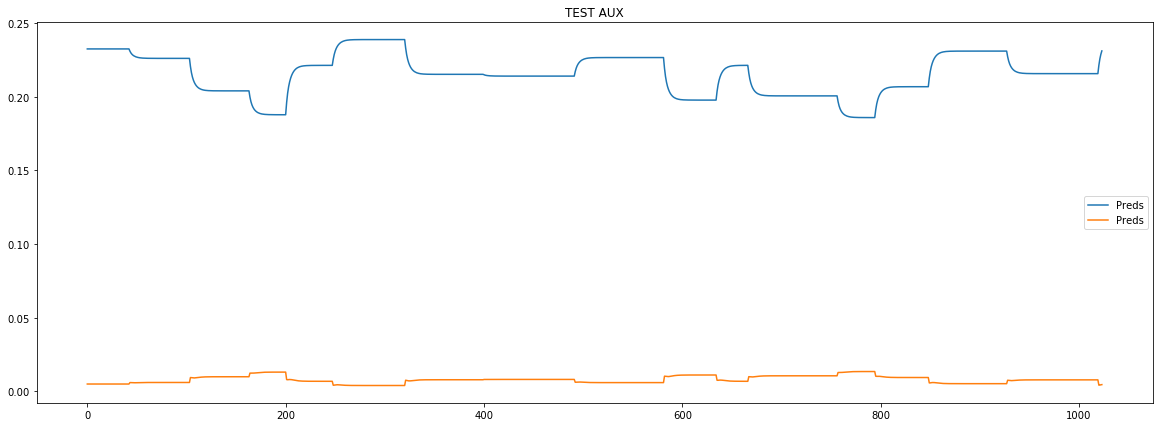

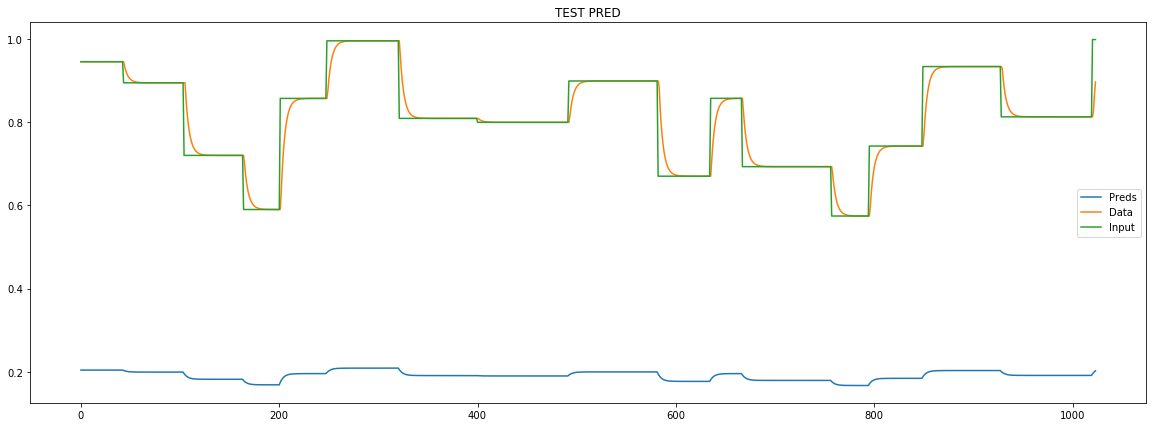

loss rate [0.006364099403660228]
Epoch [27] 
     train_loss[15.45014822536793] 
     eval_train[18.423197633479365] 
     eval_test[14.69371825244955]



aux preds: 0.21715441346168518 0.00788789615035057
main loss 0.0
aux loss 15.143931689707992
const loss 0.25430343873225725
combined loss 15.39823512844025 


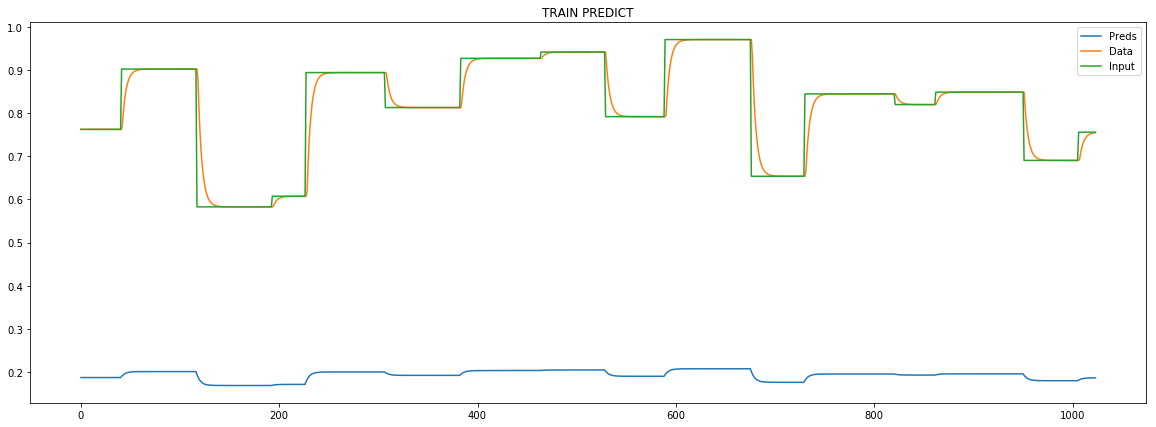

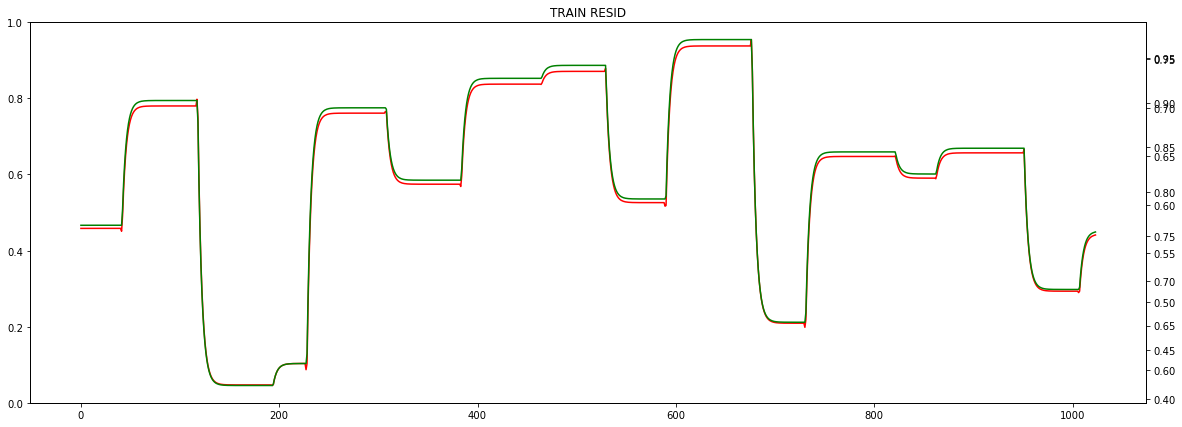

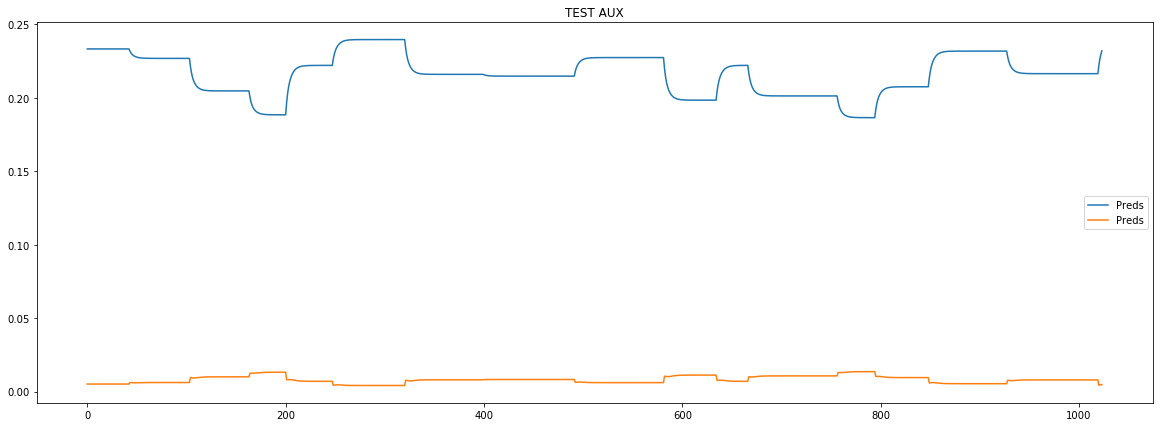

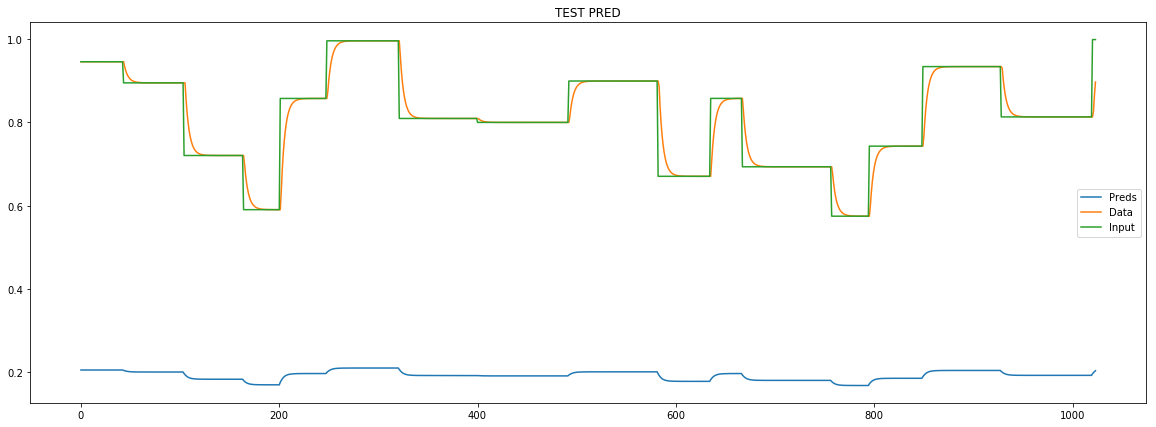

loss rate [0.00663013753644448]
Epoch [28] 
     train_loss[15.39823512844025] 
     eval_train[18.3595199173388] 
     eval_test[14.643156990493564]



aux preds: 0.21810318529605865 0.007625689264386892
main loss 0.0
aux loss 18.066800667617755
const loss 0.25643073882047945
combined loss 18.323231406438236 


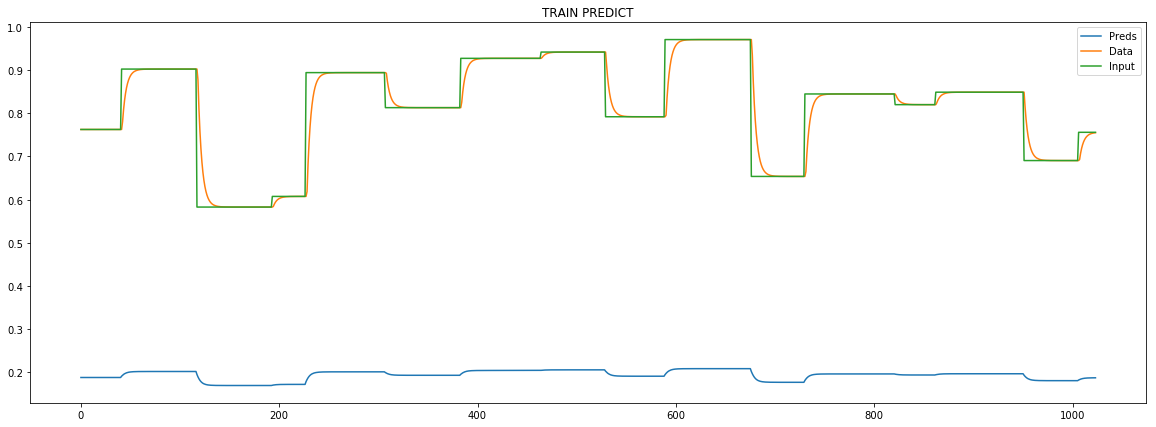

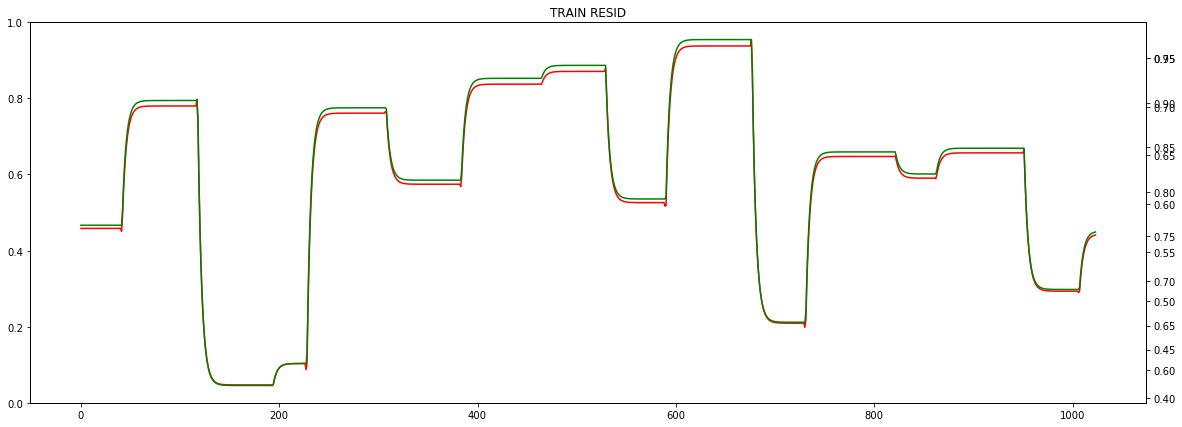

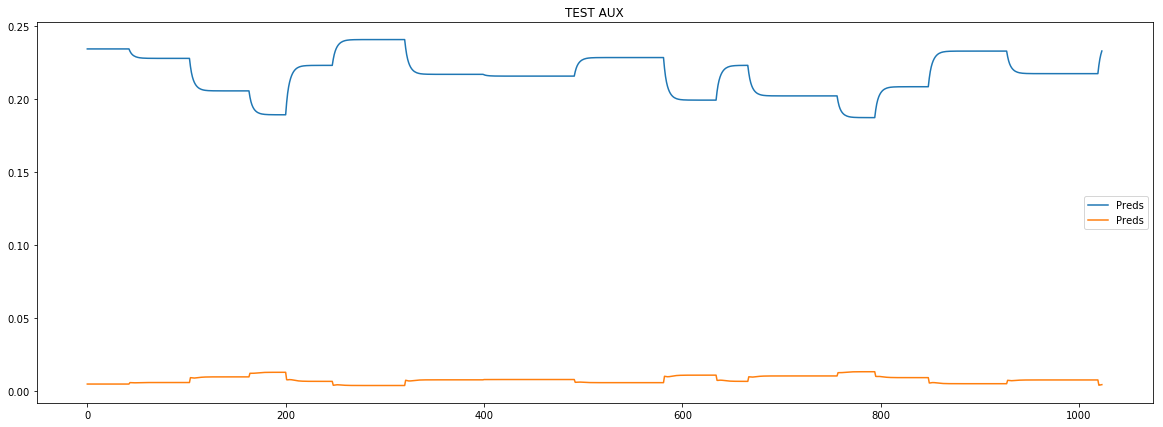

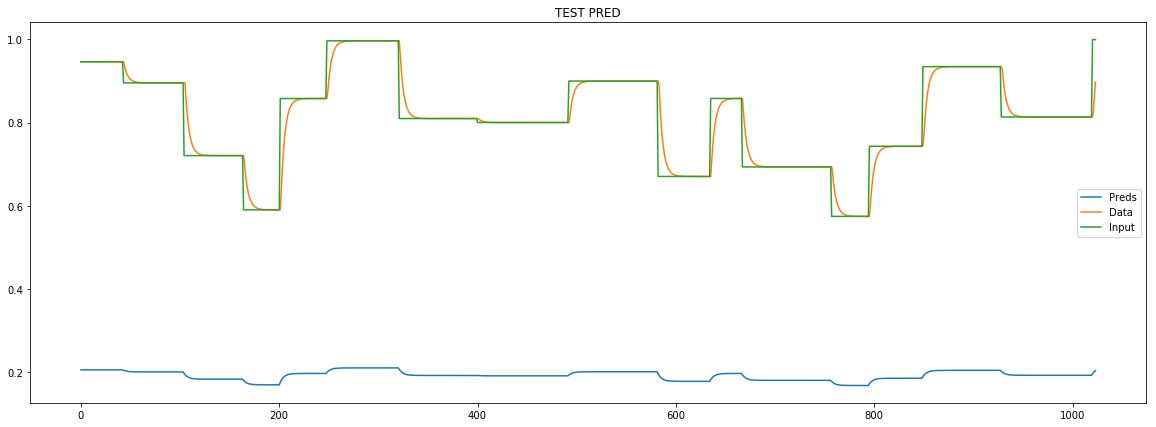

Epoch    29: reducing learning rate of group 0 to 8.1000e-06.
loss rate [0.006471860674145624]
Epoch [29] 
     train_loss[18.323231406438236] 
     eval_train[6.204876985078535] 
     eval_test[14.597115893340247]



aux preds: 0.218264639377594 0.00784185528755188
main loss 0.0
aux loss 8.985980777069926
const loss 0.25787056065522707
combined loss 9.243851337725154 


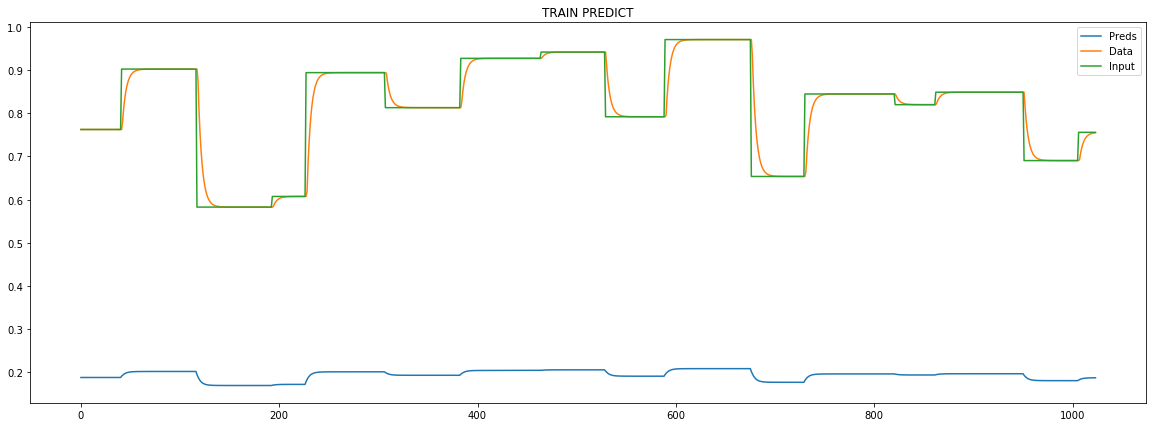

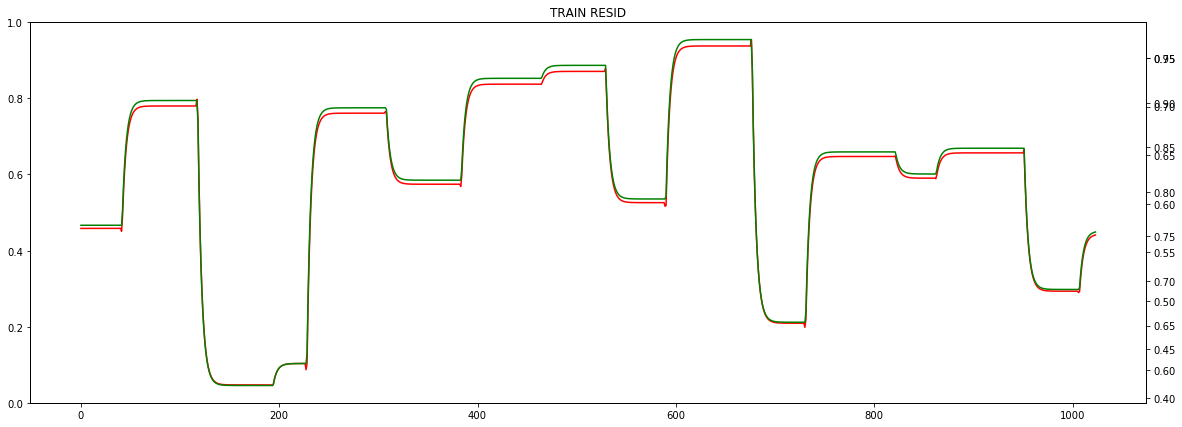

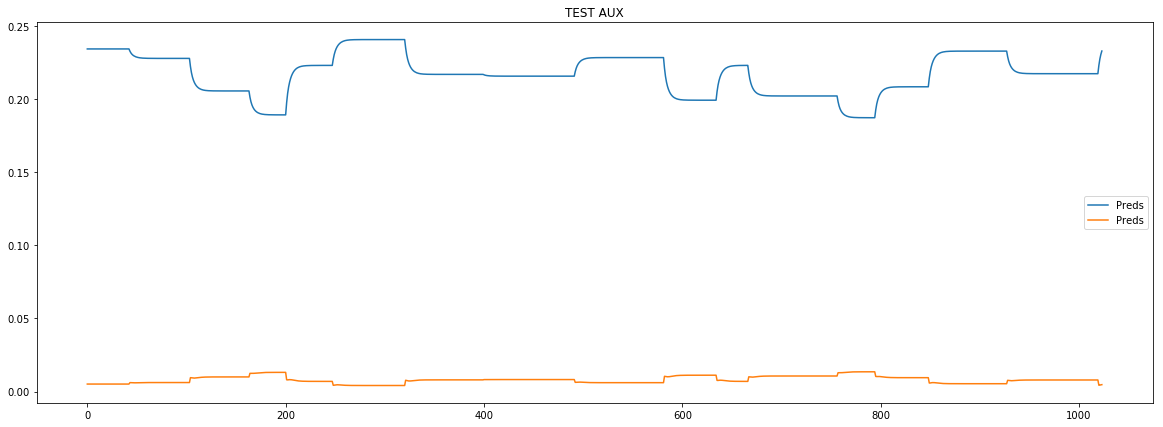

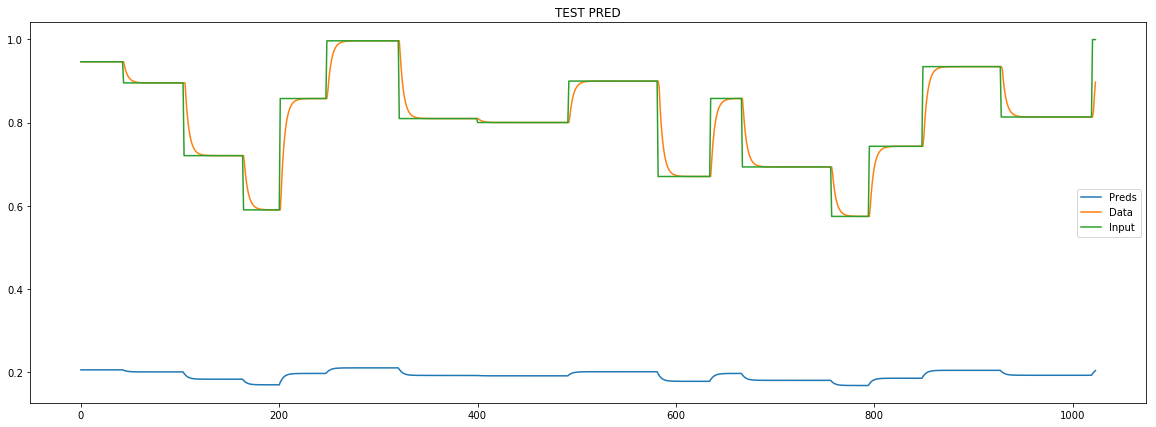

loss rate [0.004615879398283895]
Epoch [30] 
     train_loss[9.243851337725154] 
     eval_train[18.27461224131716] 
     eval_test[14.577065710571002]



aux preds: 0.21856138110160828 0.007775528822094202
main loss 0.0
aux loss 18.00452399801893
const loss 0.2583917330663938
combined loss 18.26291573108532 


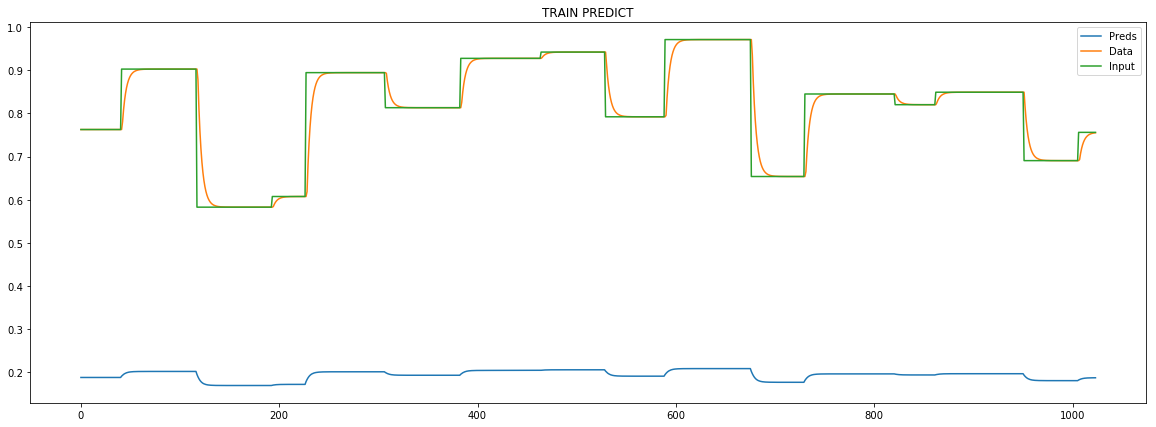

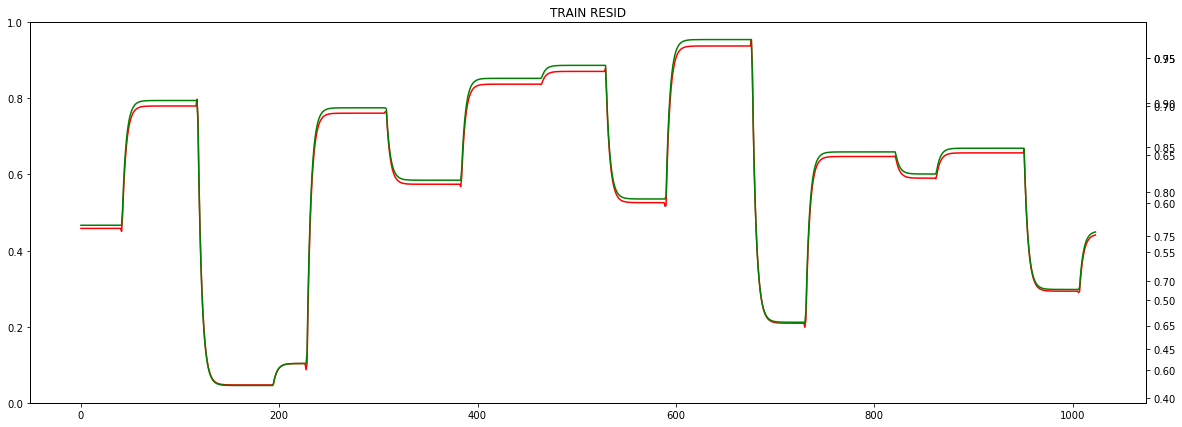

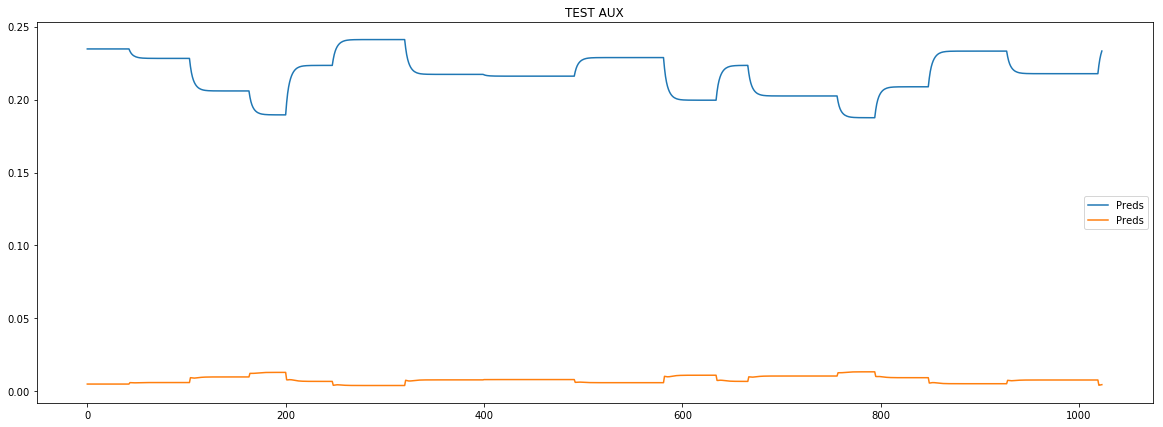

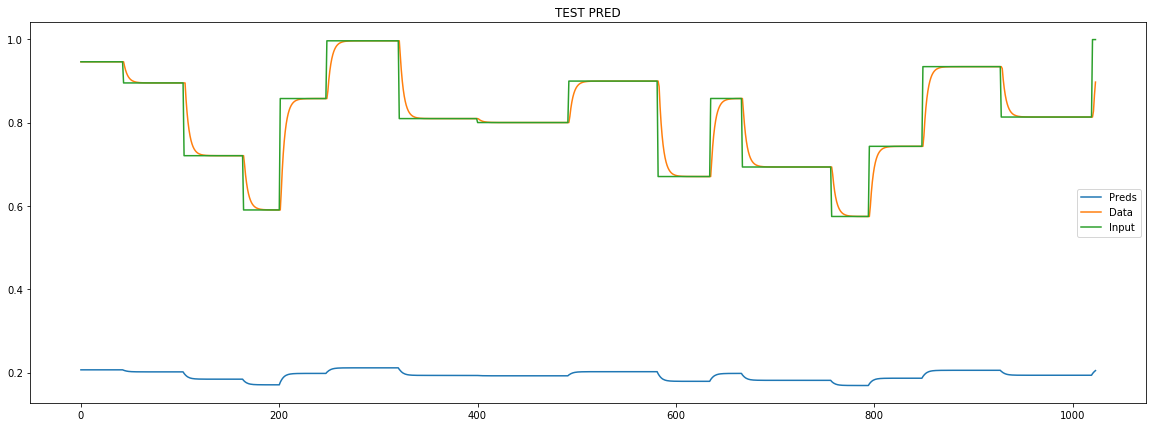

loss rate [0.002996433471852078]
Epoch [31] 
     train_loss[18.26291573108532] 
     eval_train[18.254439630438213] 
     eval_test[14.562014284797689]



aux preds: 0.2188754379749298 0.007693018298596144
main loss 0.0
aux loss 17.983246142581965
const loss 0.2592035024785079
combined loss 18.24244964506047 


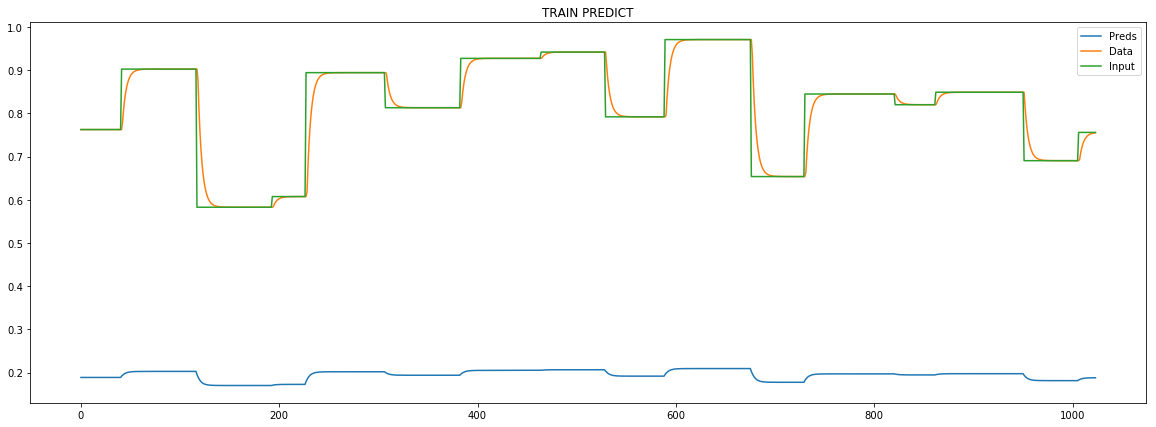

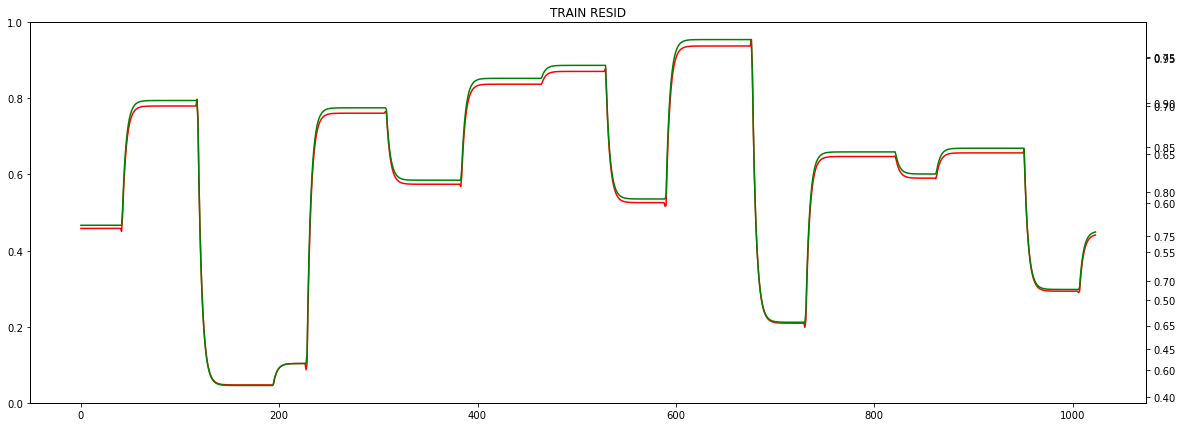

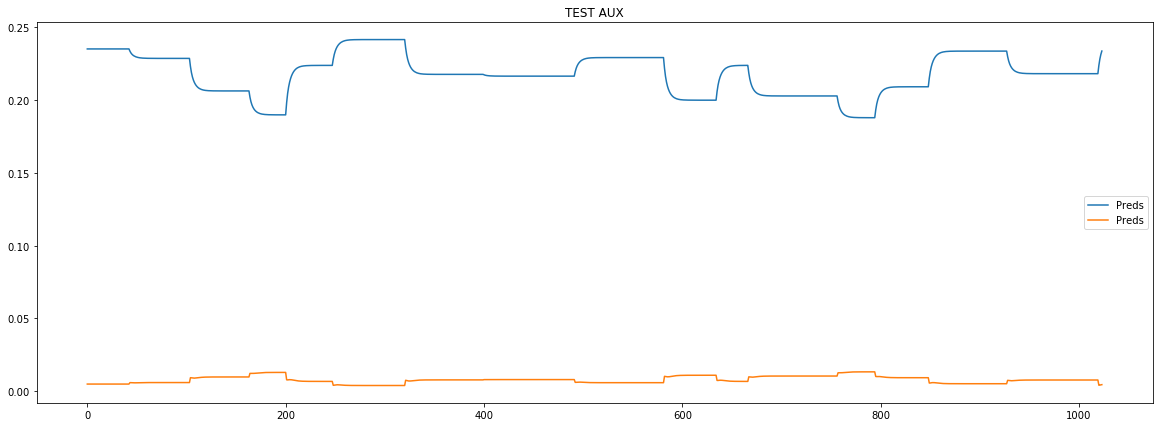

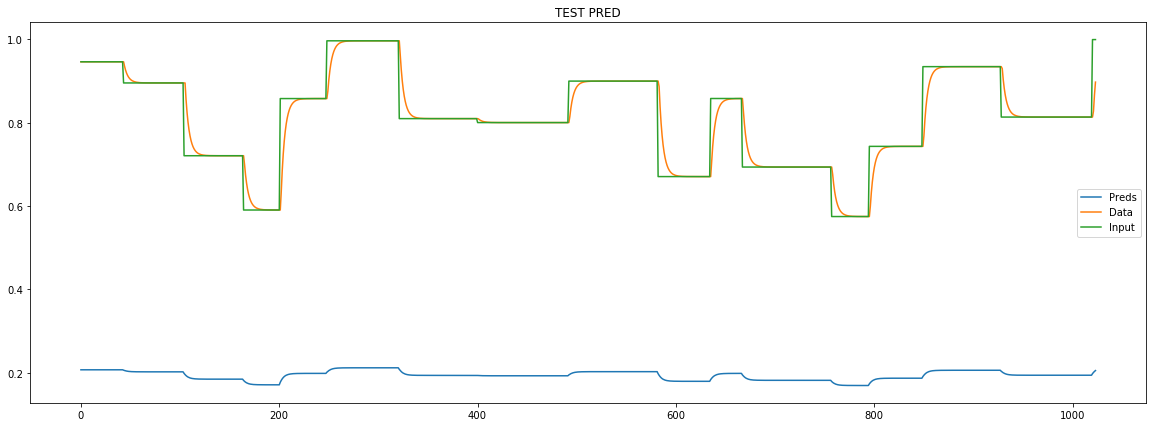

loss rate [0.0021918667012523763]
Epoch [32] 
     train_loss[18.24244964506047] 
     eval_train[12.228162965558182] 
     eval_test[14.546777325767009]



aux preds: 0.21908392012119293 0.007835176773369312
main loss 0.0
aux loss 11.960539888411473
const loss 0.2599357942549082
combined loss 12.22047568266638 


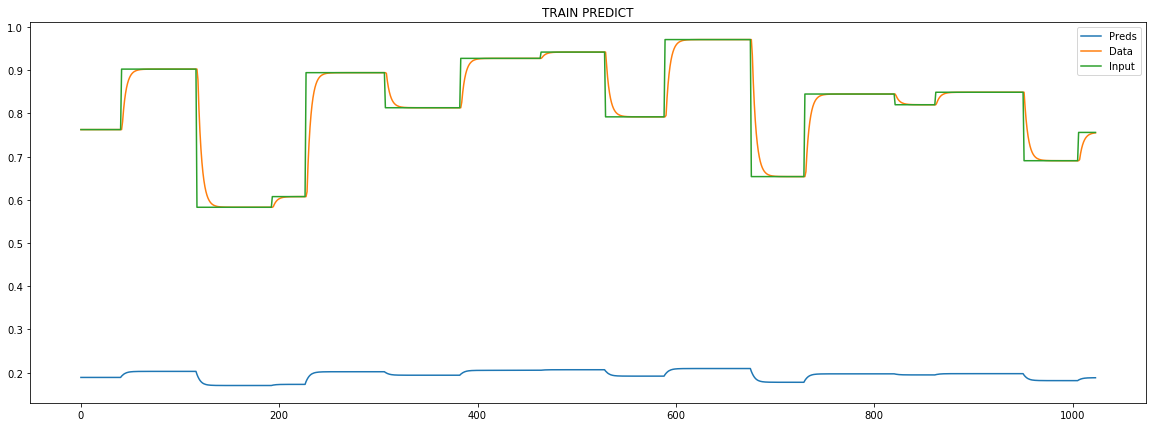

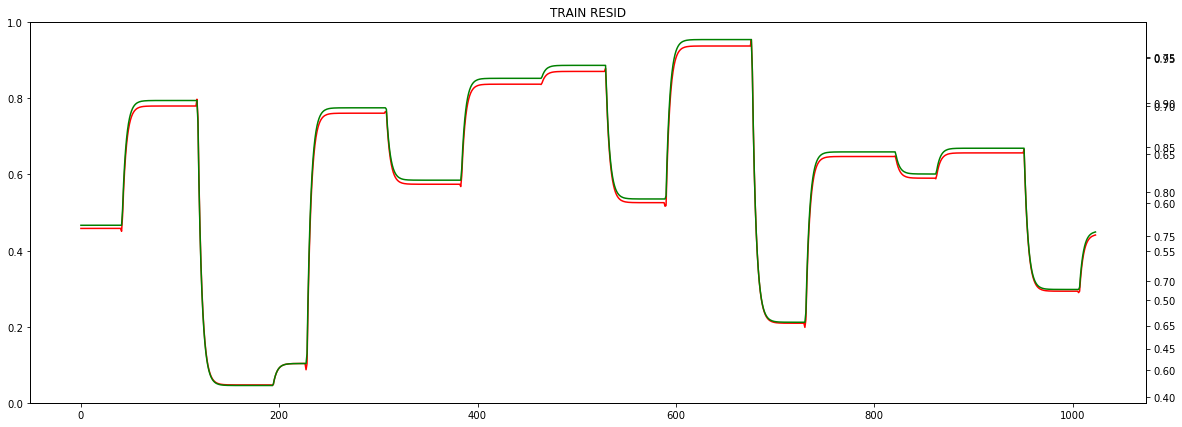

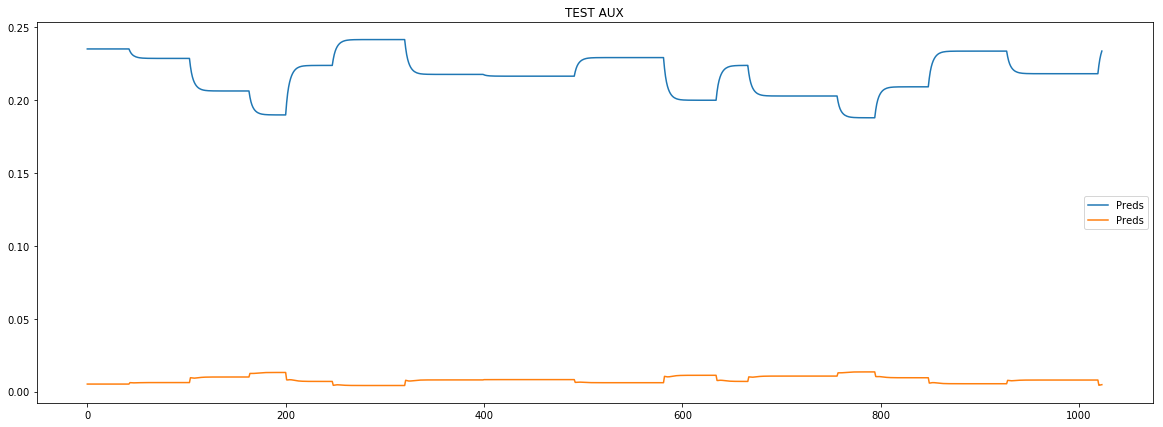

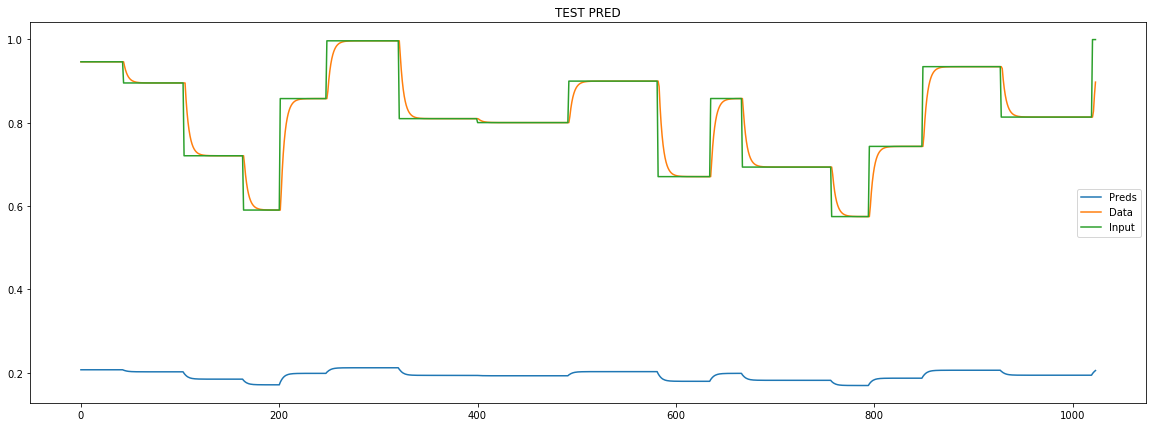

loss rate [0.0023880895824149873]
Epoch [33] 
     train_loss[12.22047568266638] 
     eval_train[18.21065992822584] 
     eval_test[14.527177193456076]



aux preds: 0.21940910816192627 0.007770362310111523
main loss 0.0
aux loss 17.937265453788523
const loss 0.26055597170041156
combined loss 18.197821425488936 


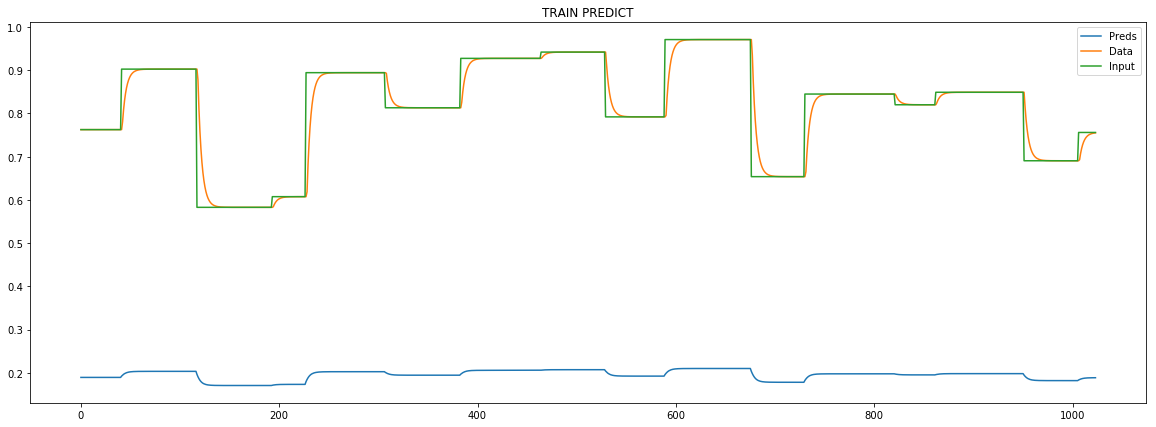

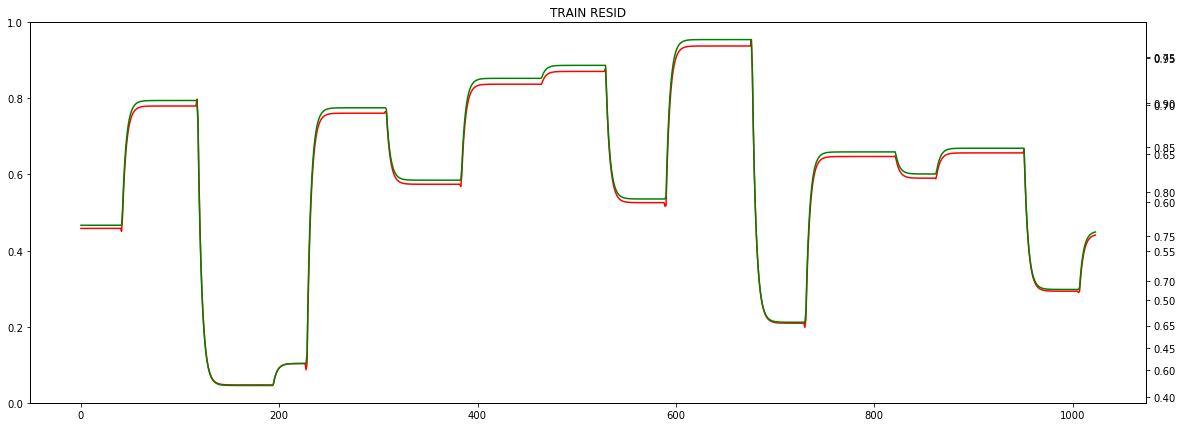

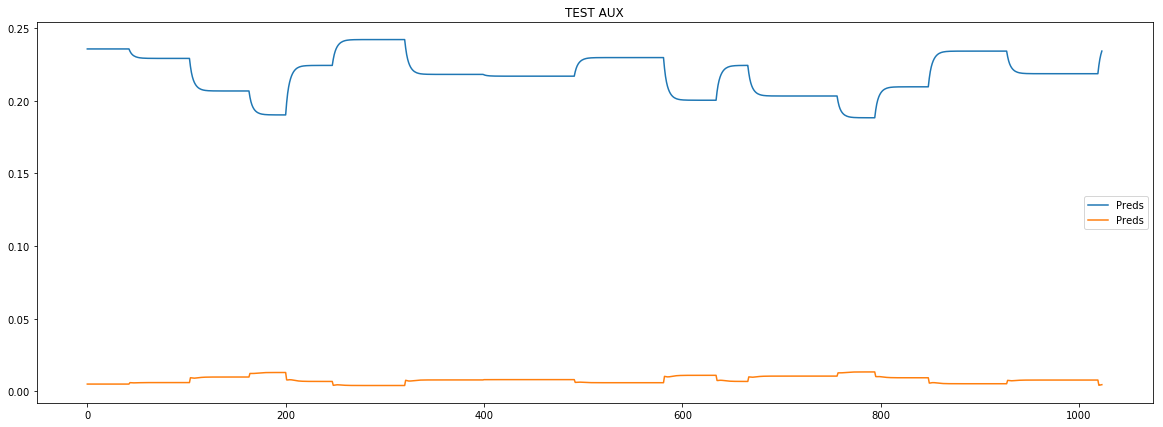

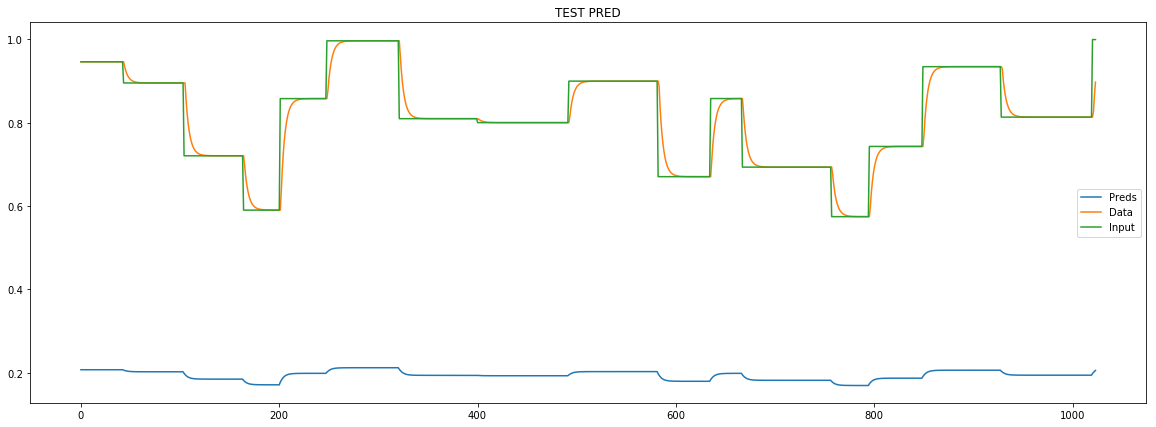

loss rate [0.0023883907688790895]
Epoch [34] 
     train_loss[18.197821425488936] 
     eval_train[18.18848526244983] 
     eval_test[14.510583019646052]



aux preds: 0.2196904867887497 0.007804663851857185
main loss 0.0
aux loss 14.960482166005441
const loss 0.2613801867342912
combined loss 15.221862352739732 


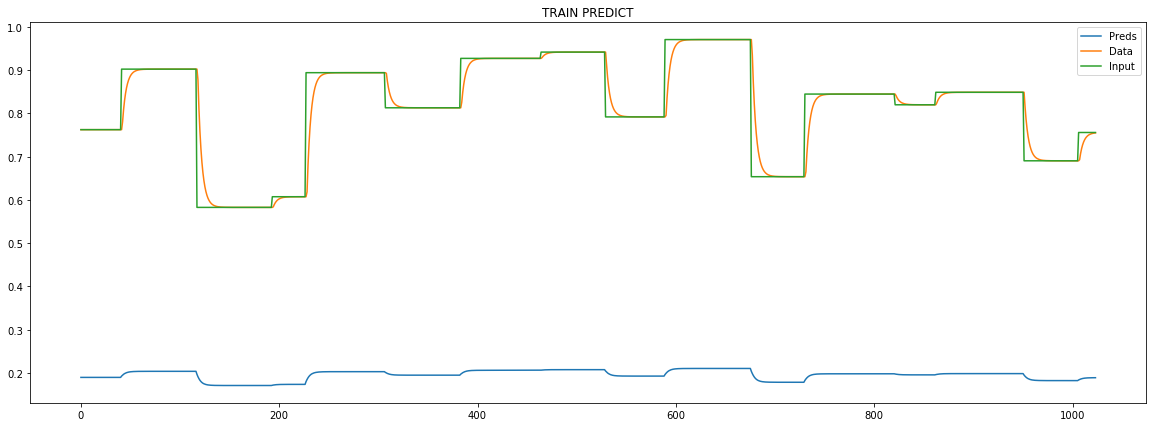

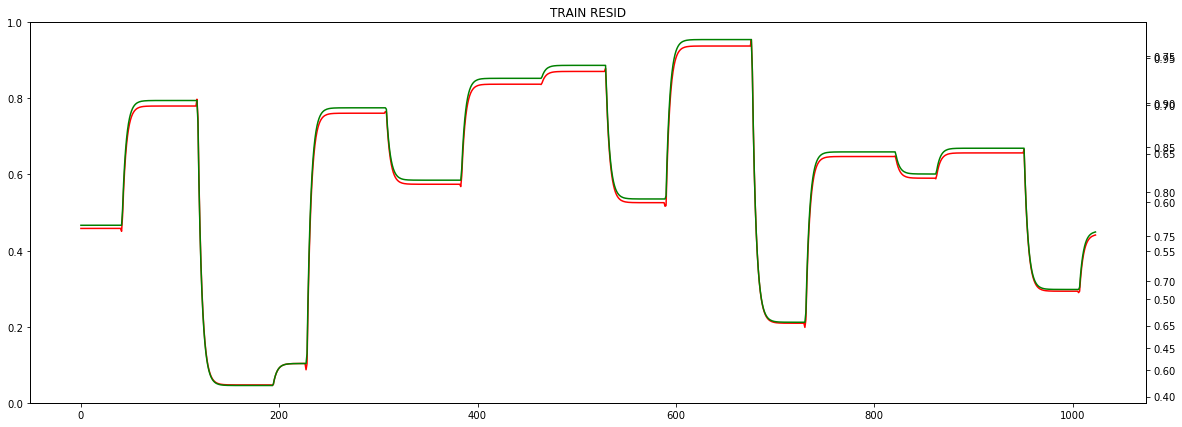

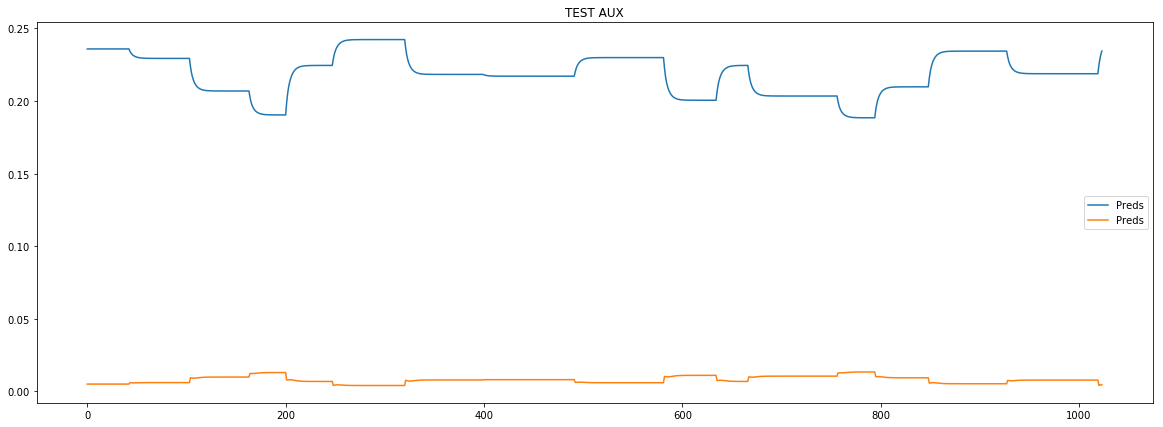

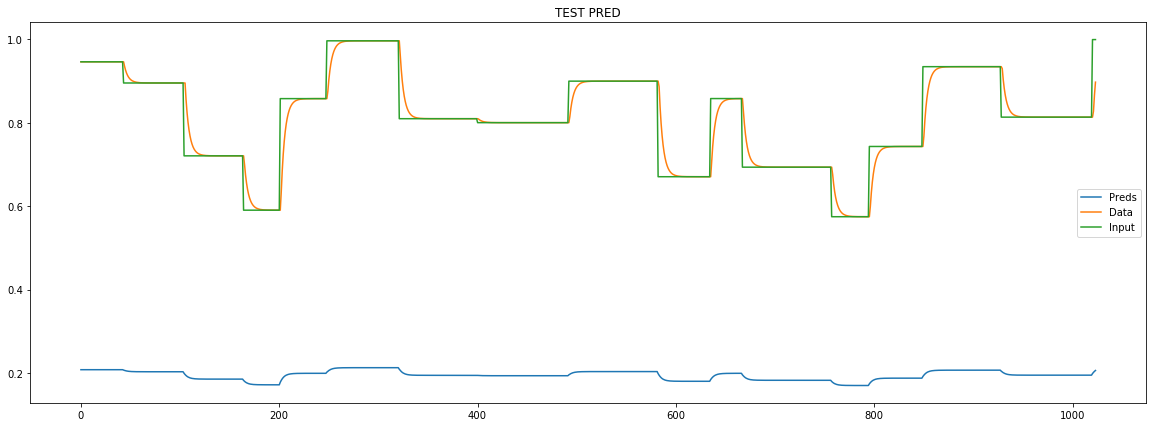

Epoch    35: reducing learning rate of group 0 to 2.4300e-06.
loss rate [0.0025022507209759848]
Epoch [35] 
     train_loss[15.221862352739732] 
     eval_train[18.164899707771838] 
     eval_test[14.491826032796366]



aux preds: 0.21980448067188263 0.007773746736347675
main loss 0.0
aux loss 17.898997086888322
const loss 0.2618594570801808
combined loss 18.160856543968503 


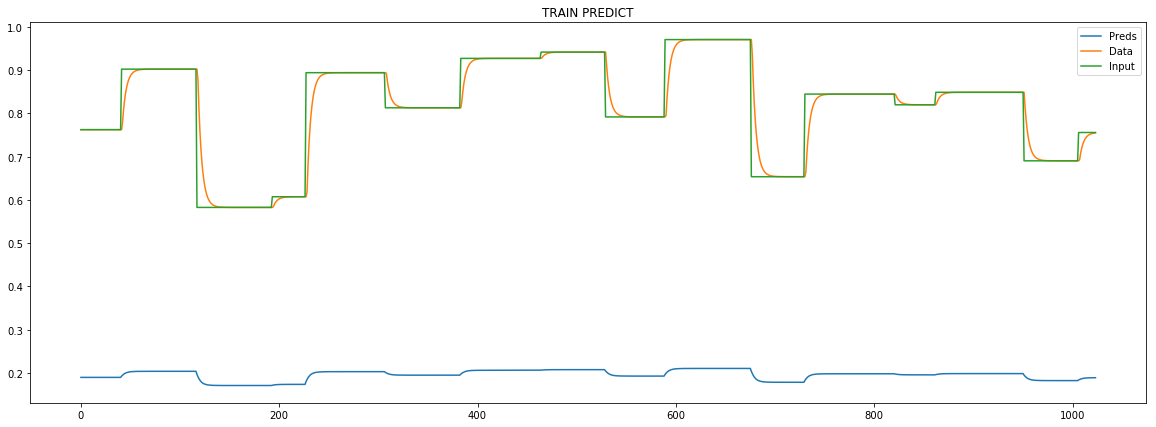

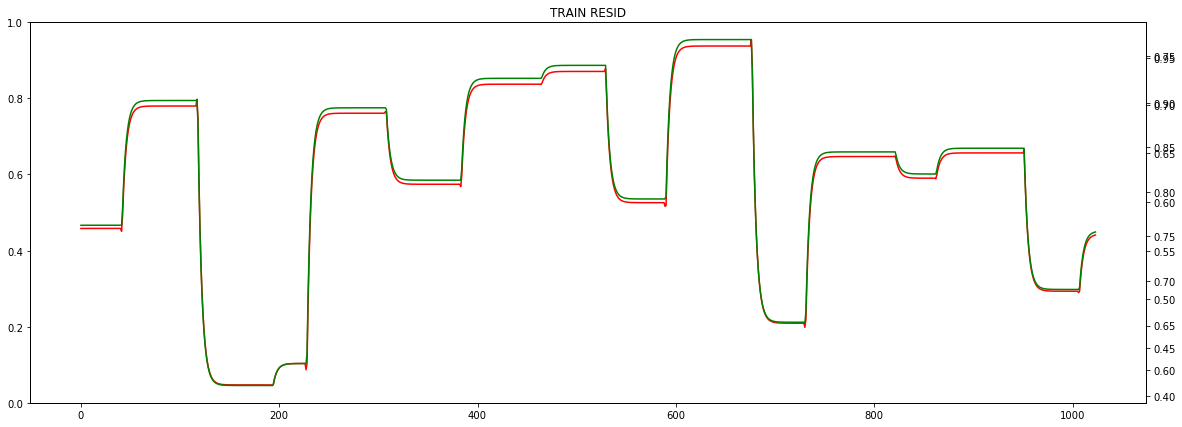

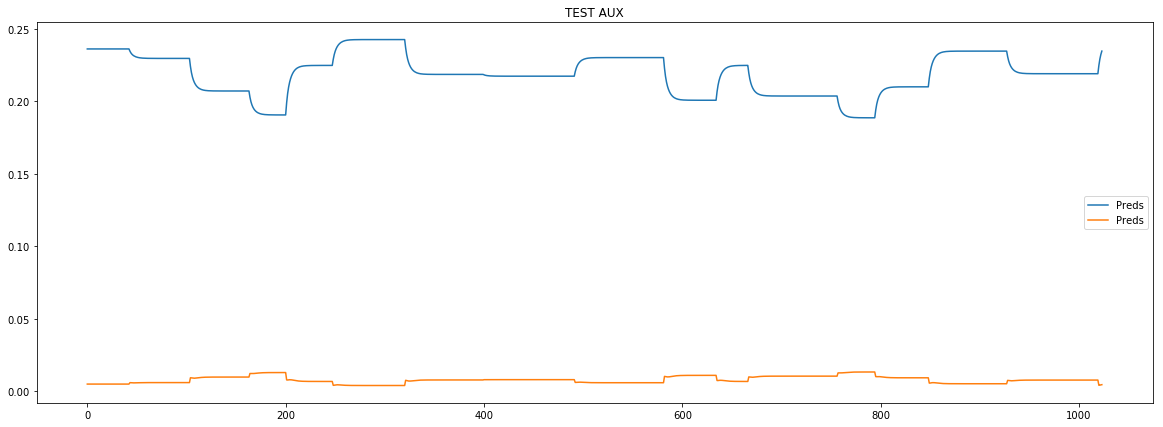

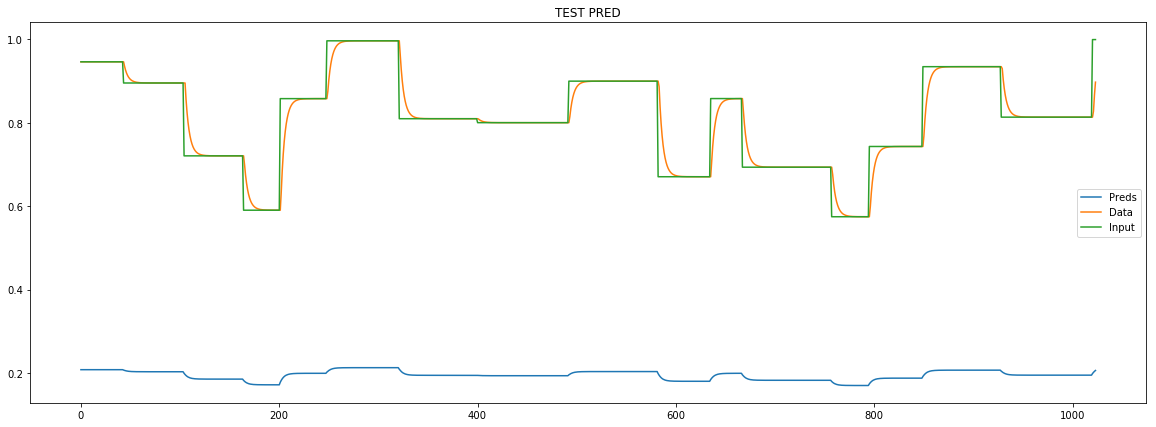

loss rate [0.0016053284514844224]
Epoch [36] 
     train_loss[18.160856543968503] 
     eval_train[18.157877165752534] 
     eval_test[14.486568987538869]



aux preds: 0.21991237998008728 0.007749802898615599
main loss 0.0
aux loss 17.891556969807986
const loss 0.26213973560012305
combined loss 18.15369670540811 


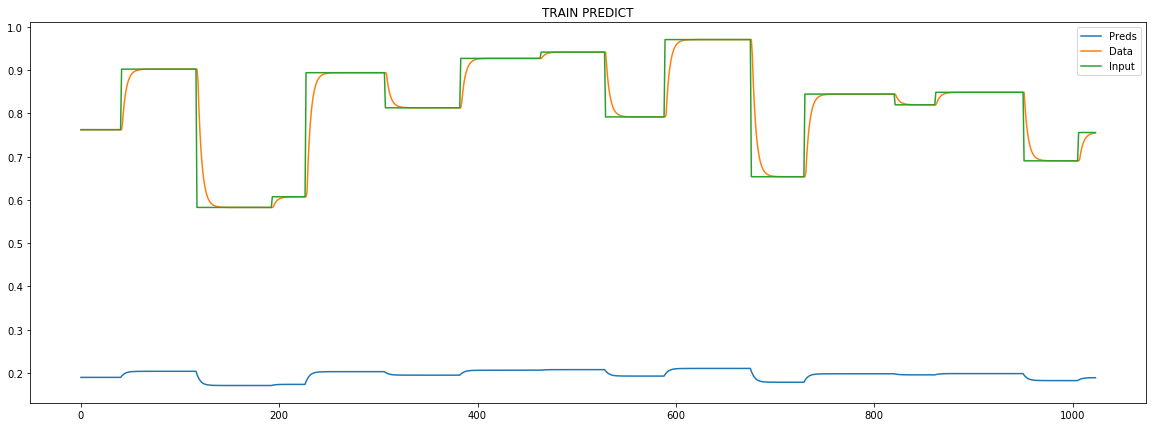

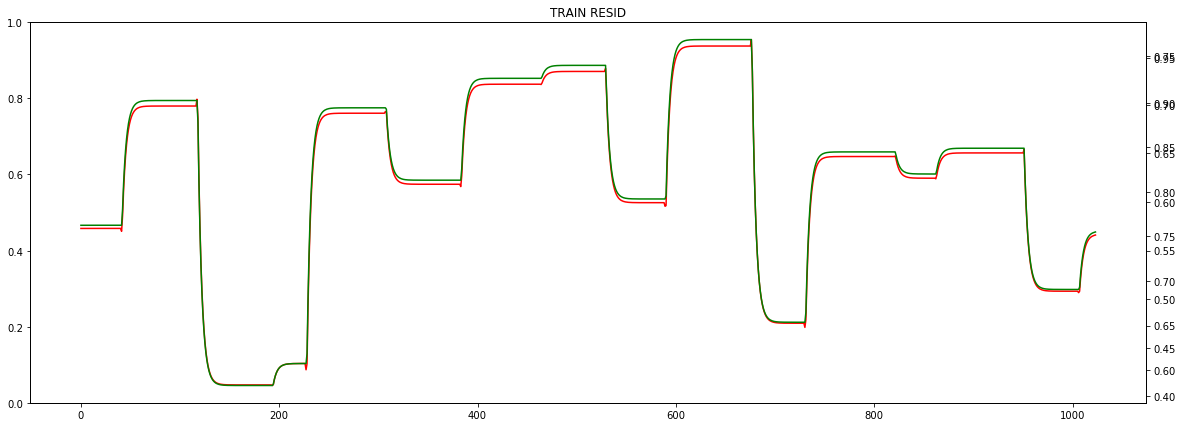

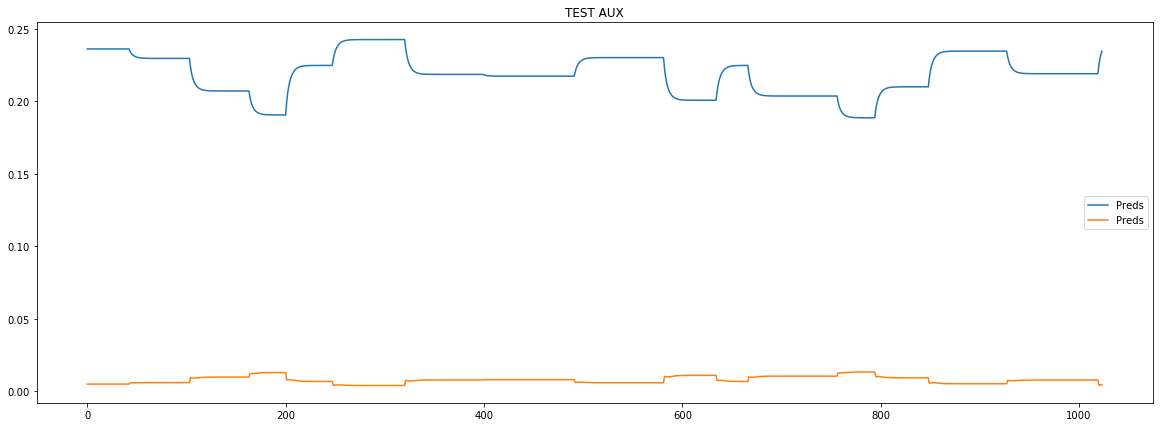

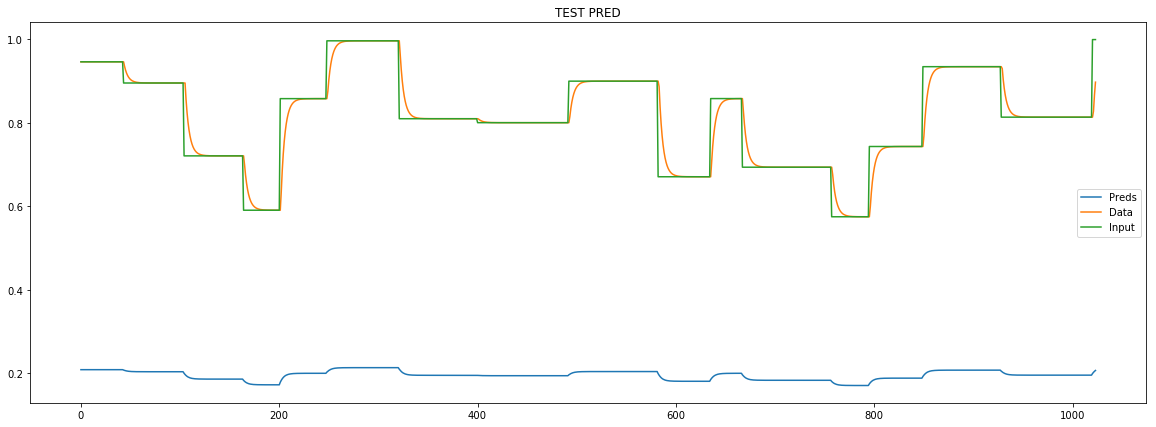

loss rate [0.0010446359225994017]
Epoch [37] 
     train_loss[18.15369670540811] 
     eval_train[18.15065548300313] 
     eval_test[14.48118263042786]



aux preds: 0.2200041562318802 0.007761470042169094
main loss 0.0
aux loss 14.935393017680886
const loss 0.26240847861537564
combined loss 15.197801496296261 


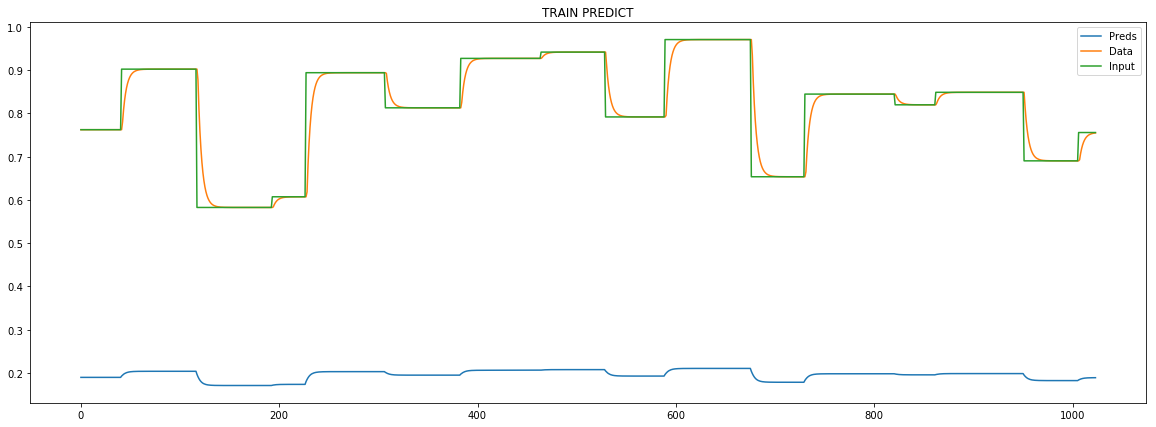

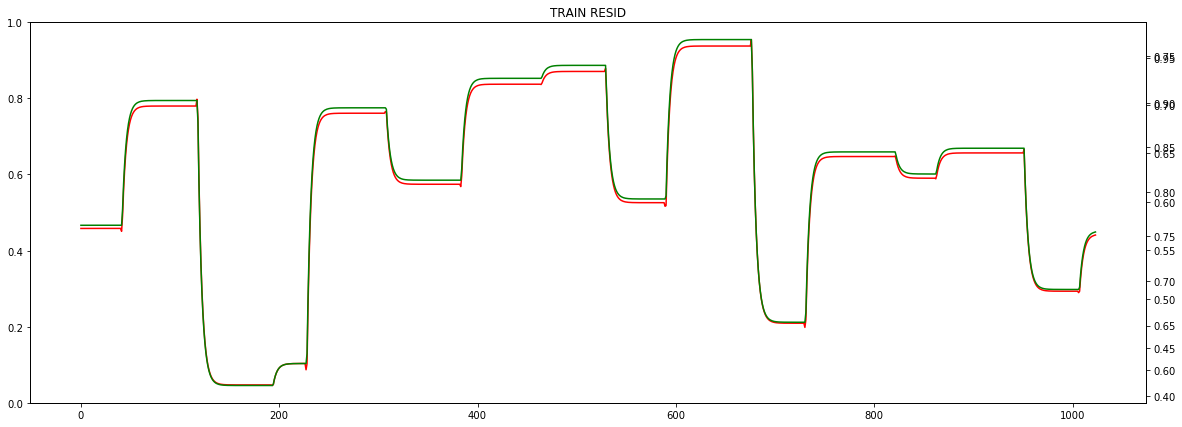

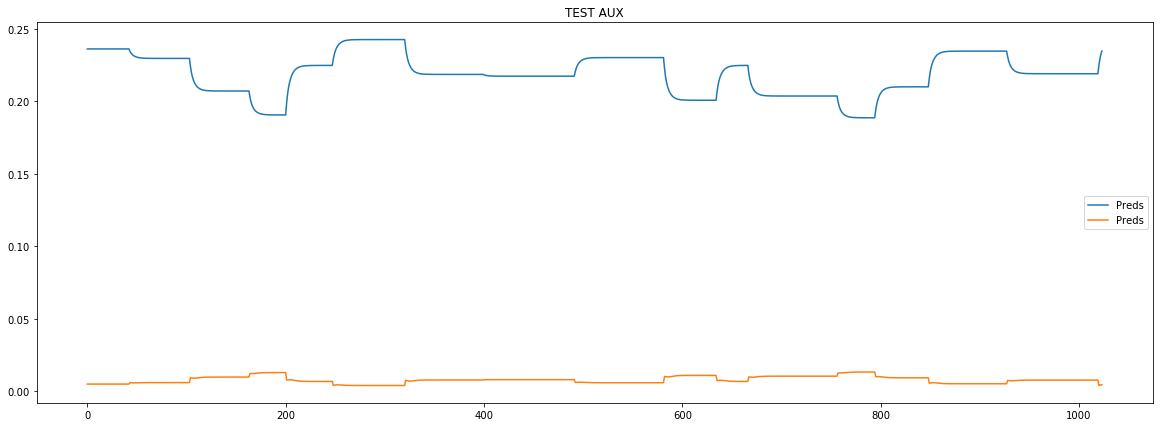

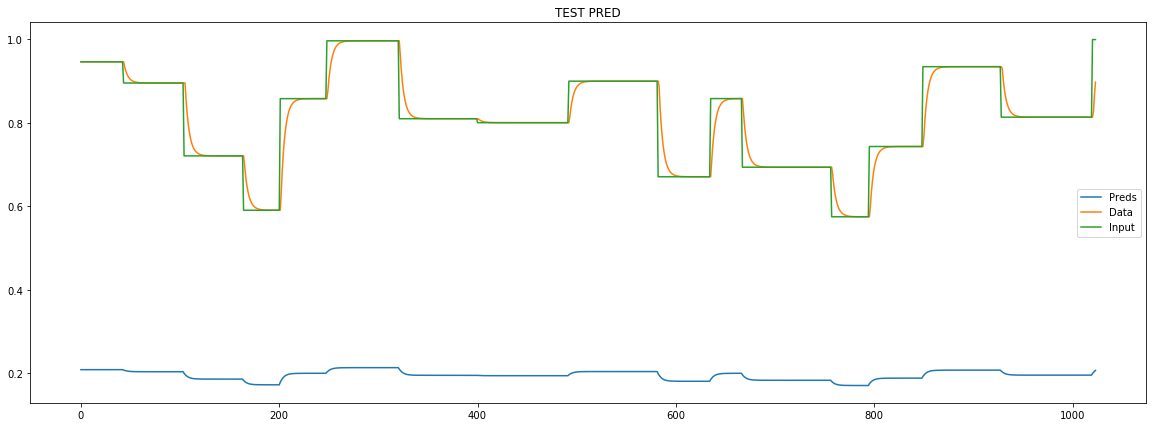

loss rate [0.000792312695023667]
Epoch [38] 
     train_loss[15.197801496296261] 
     eval_train[18.142995117088926] 
     eval_test[14.475048025223343]



aux preds: 0.22011639177799225 0.007739742286503315
main loss 0.0
aux loss 17.87585368637855
const loss 0.2626649565421618
combined loss 18.13851864292071 


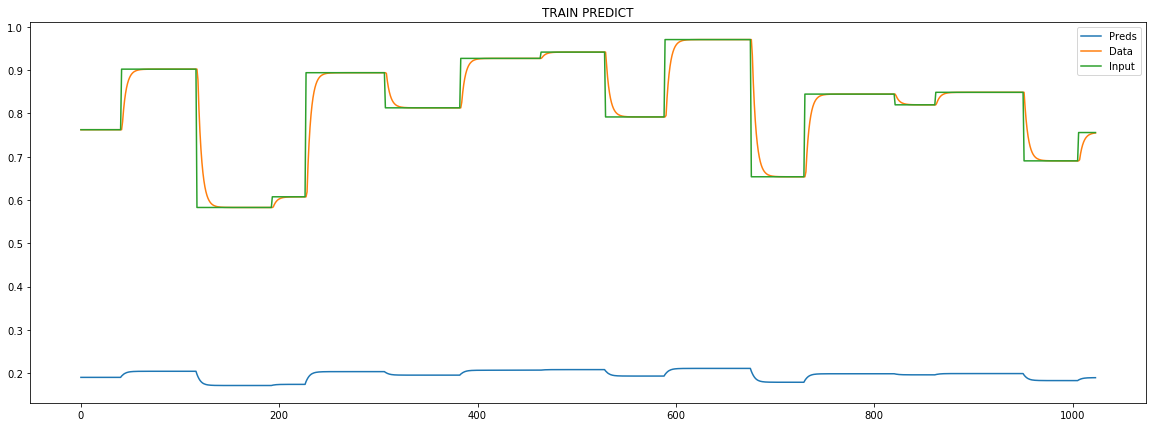

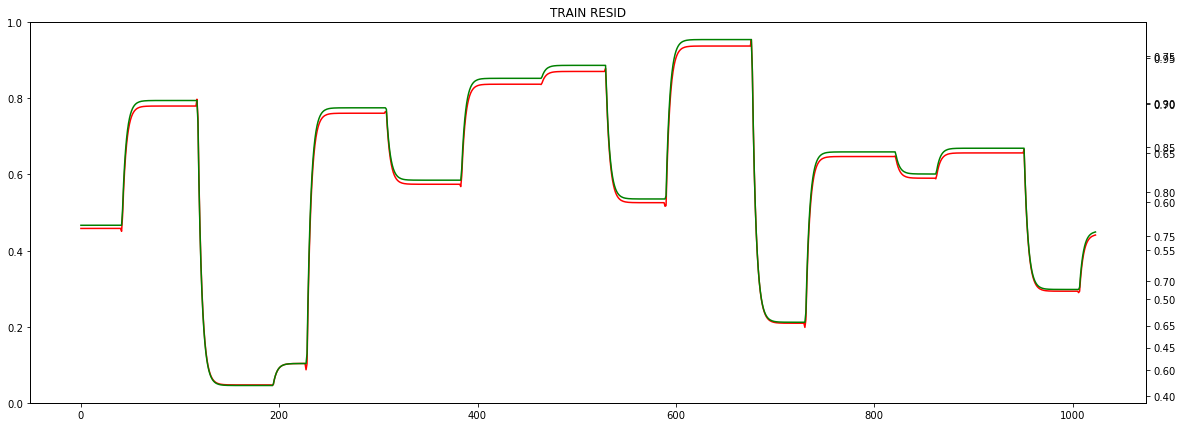

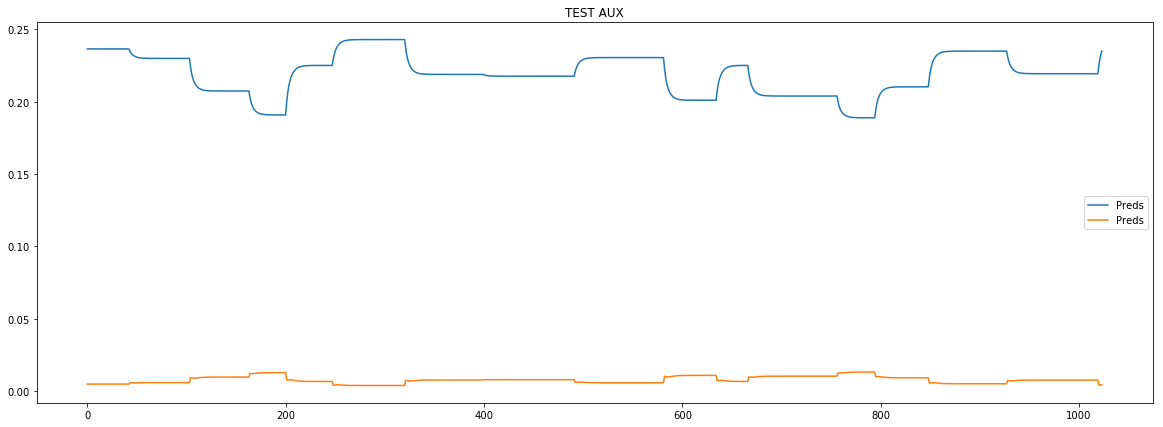

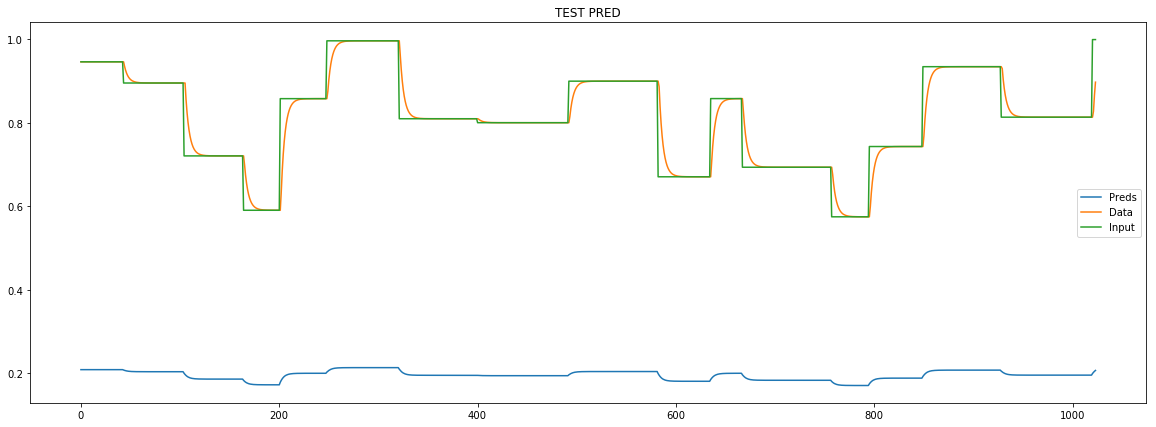

loss rate [0.0008029168564956946]
Epoch [39] 
     train_loss[18.13851864292071] 
     eval_train[15.188717441310963] 
     eval_test[14.469306229021063]



aux preds: 0.220213383436203 0.0077521828934550285
main loss 0.0
aux loss 14.92207699161596
const loss 0.26294669766838735
combined loss 15.185023689284346 


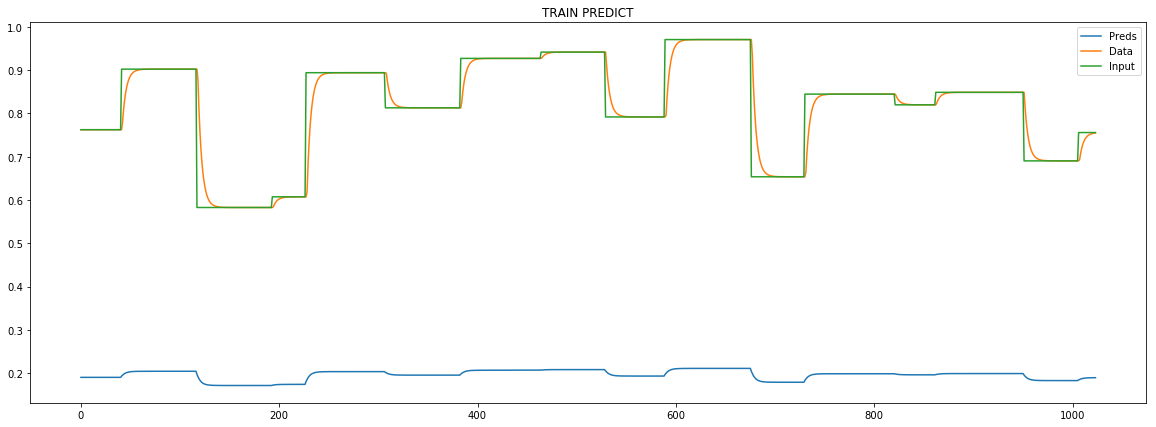

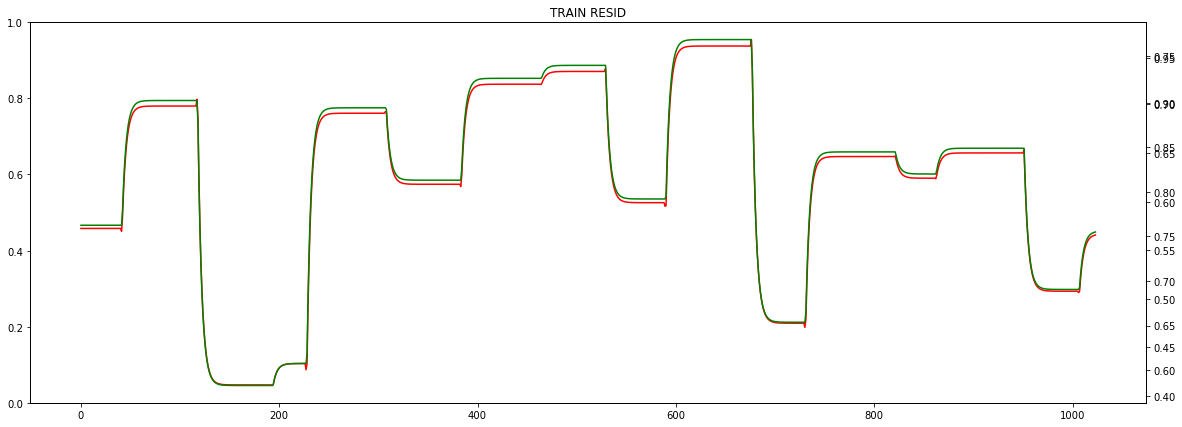

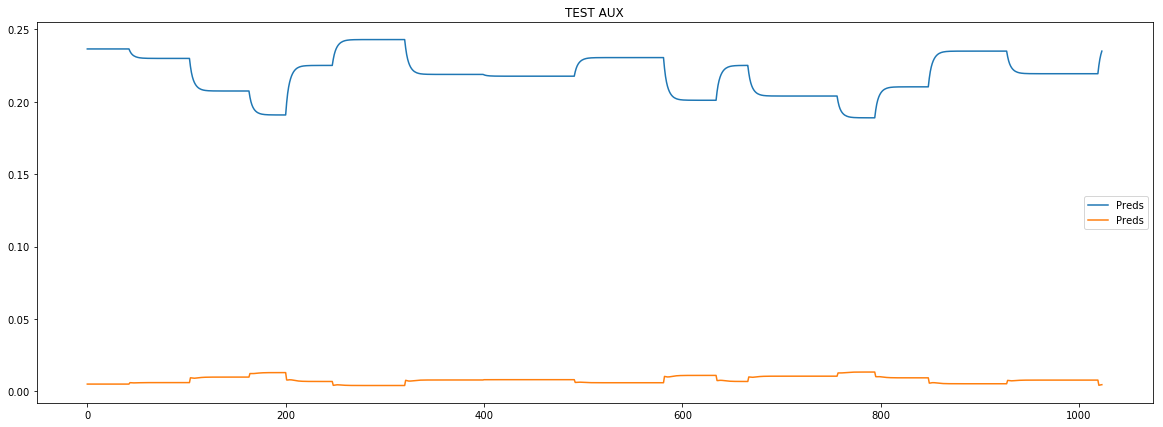

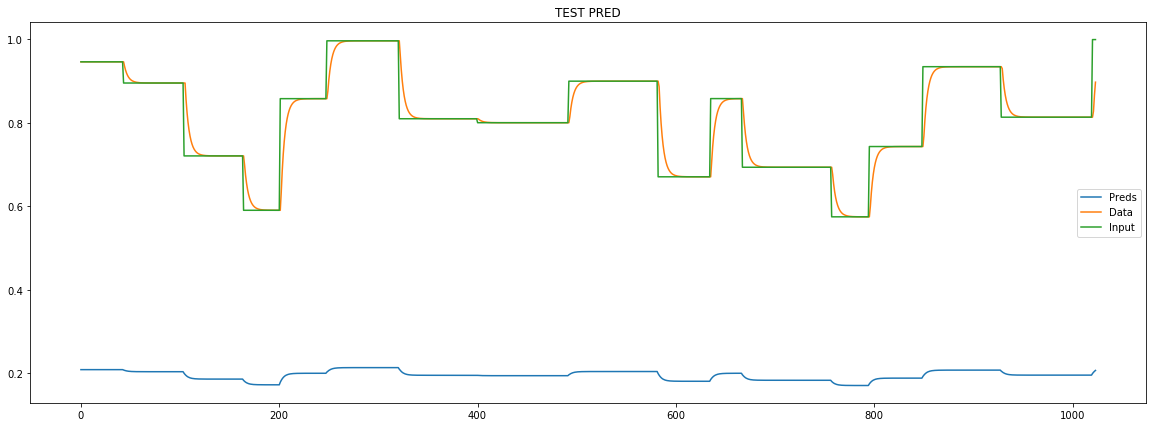

loss rate [0.0008501000047668184]
Epoch [40] 
     train_loss[15.185023689284346] 
     eval_train[18.127258582542147] 
     eval_test[14.462873611853203]



aux preds: 0.22031156718730927 0.007767357863485813
main loss 0.0
aux loss 14.914940096581212
const loss 0.2631960026919842
combined loss 15.178136099273196 


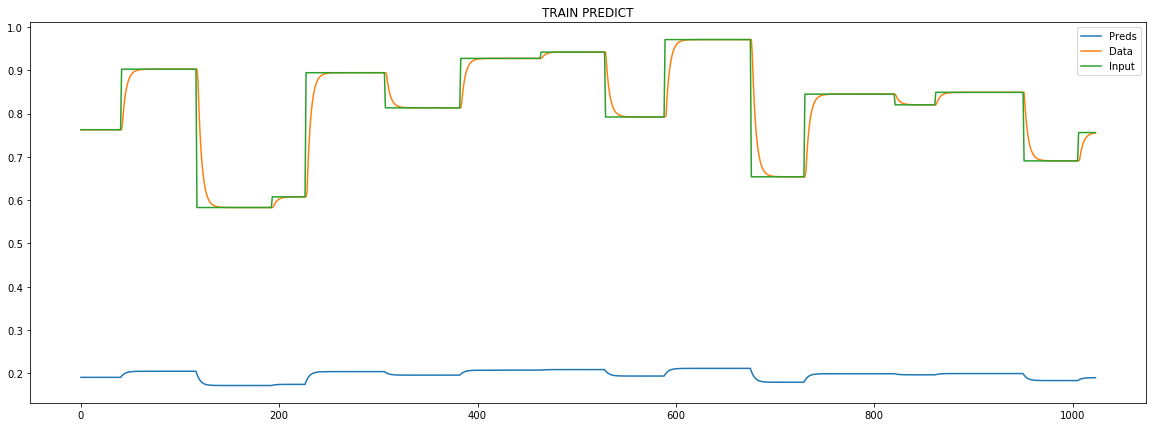

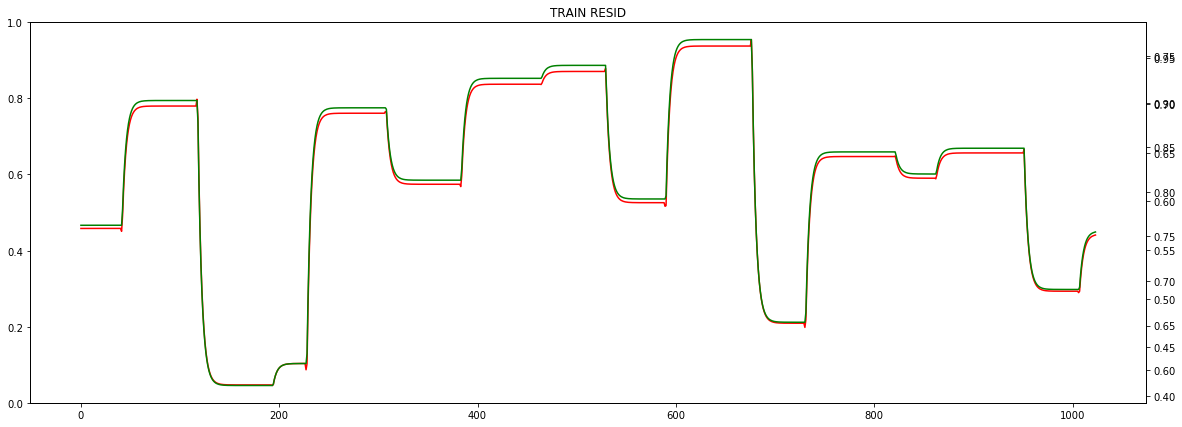

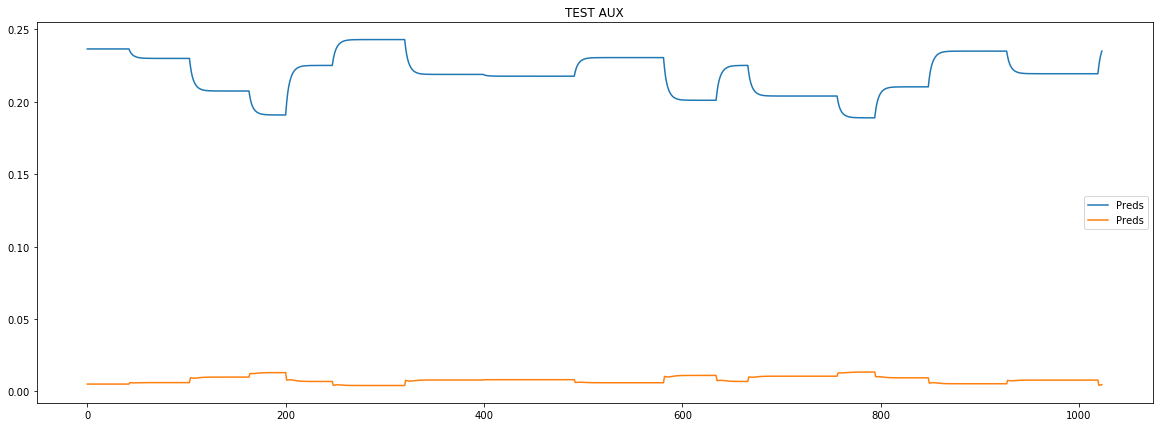

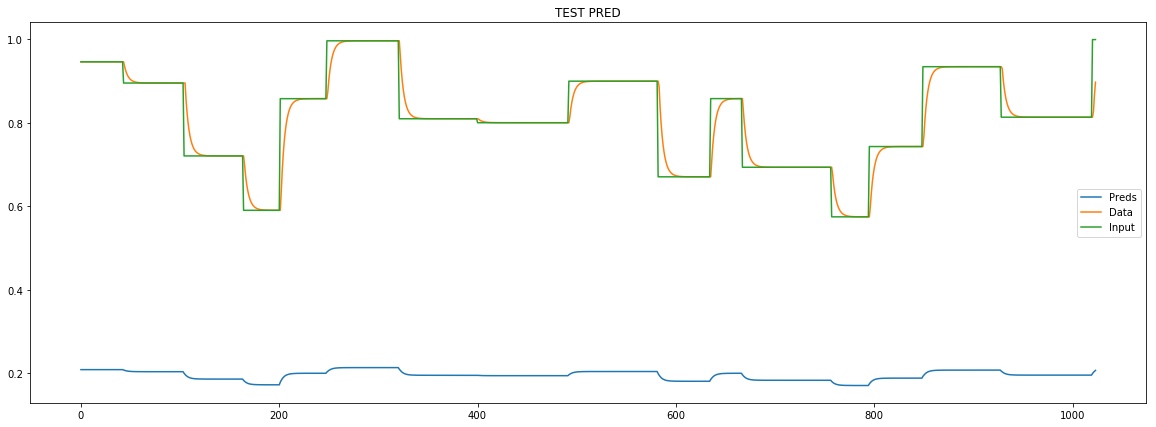

Epoch    41: reducing learning rate of group 0 to 7.2900e-07.
loss rate [0.0008855073870231989]
Epoch [41] 
     train_loss[15.178136099273196] 
     eval_train[18.118964004975098] 
     eval_test[14.456263481723992]



aux preds: 0.2203502655029297 0.007757969666272402
main loss 0.0
aux loss 17.85414387113773
const loss 0.26336331550891584
combined loss 18.117507186646645 


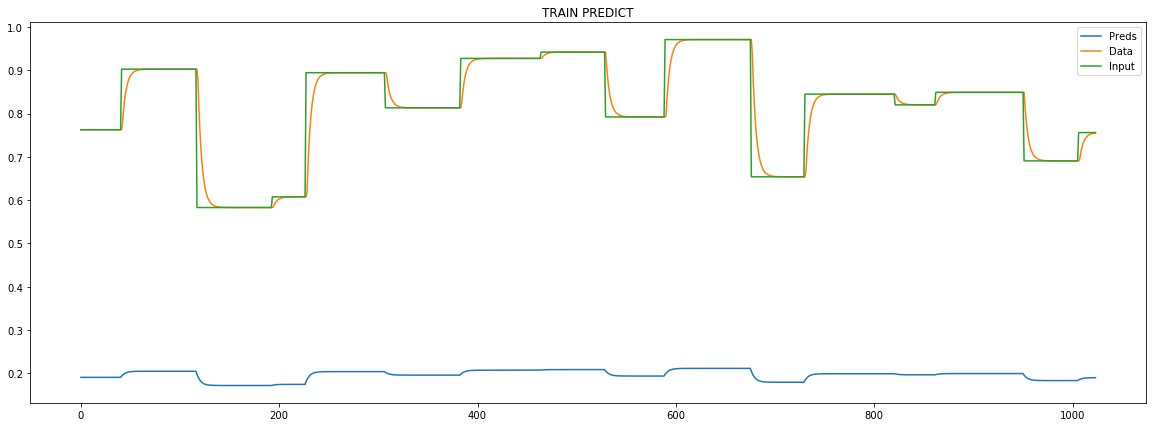

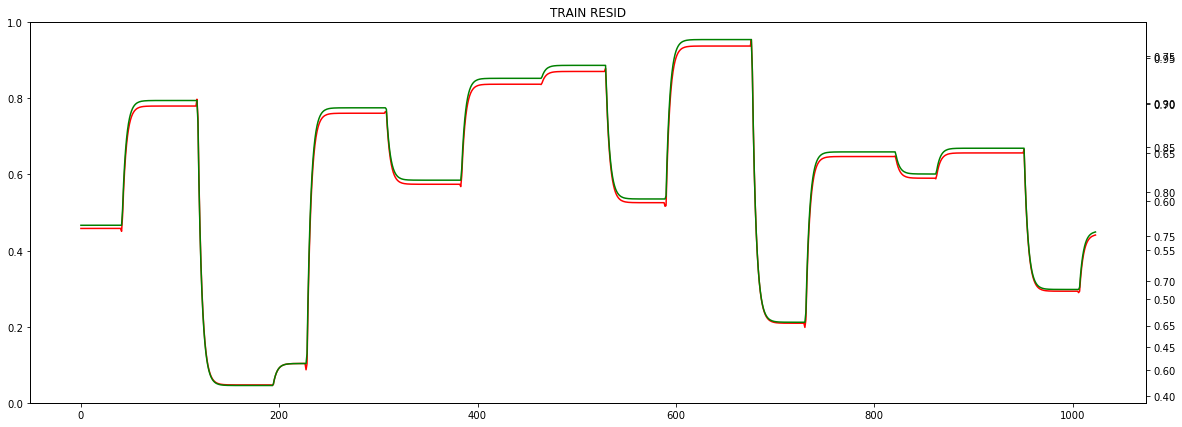

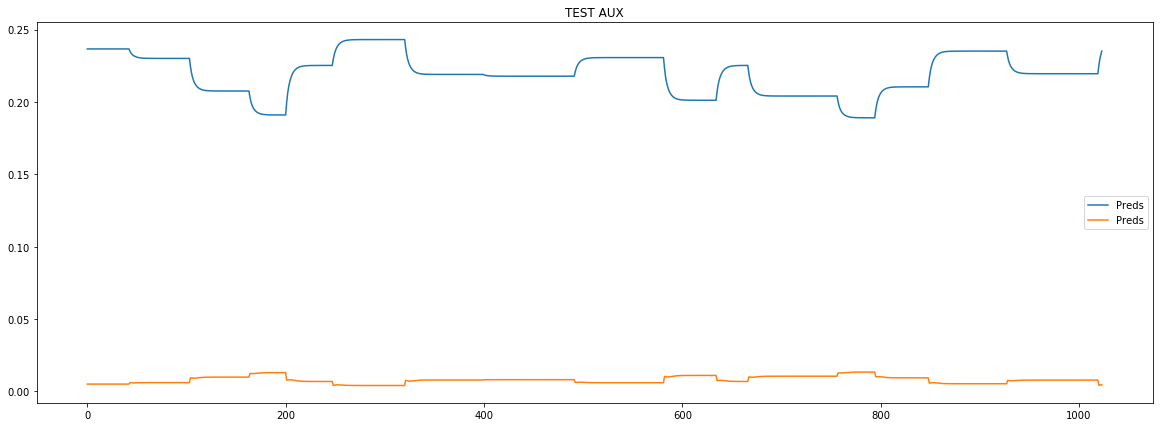

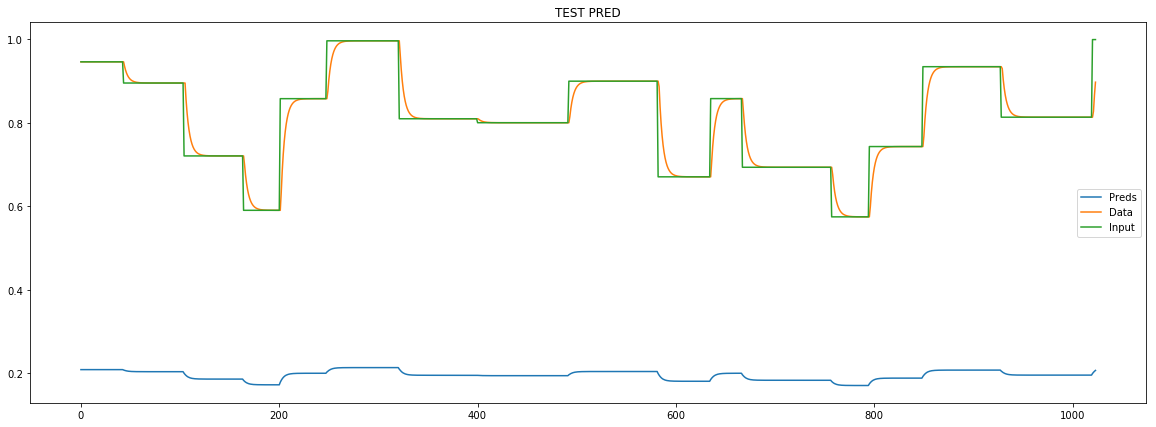

loss rate [0.0005832127451054214]
Epoch [42] 
     train_loss[18.117507186646645] 
     eval_train[18.116469210694326] 
     eval_test[14.454379543154078]



aux preds: 0.22038893401622772 0.007750833407044411
main loss 0.0
aux loss 17.851518089130806
const loss 0.2634603220682878
combined loss 18.114978411199093 


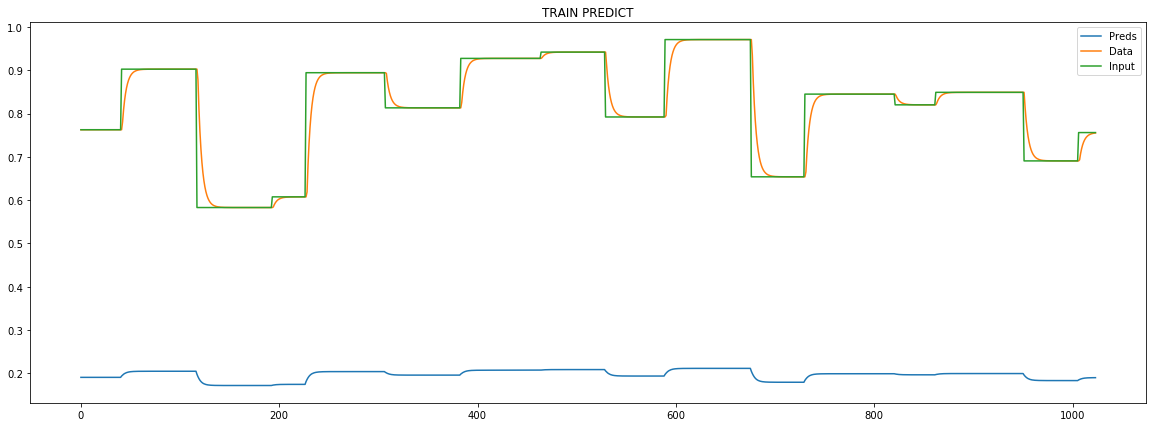

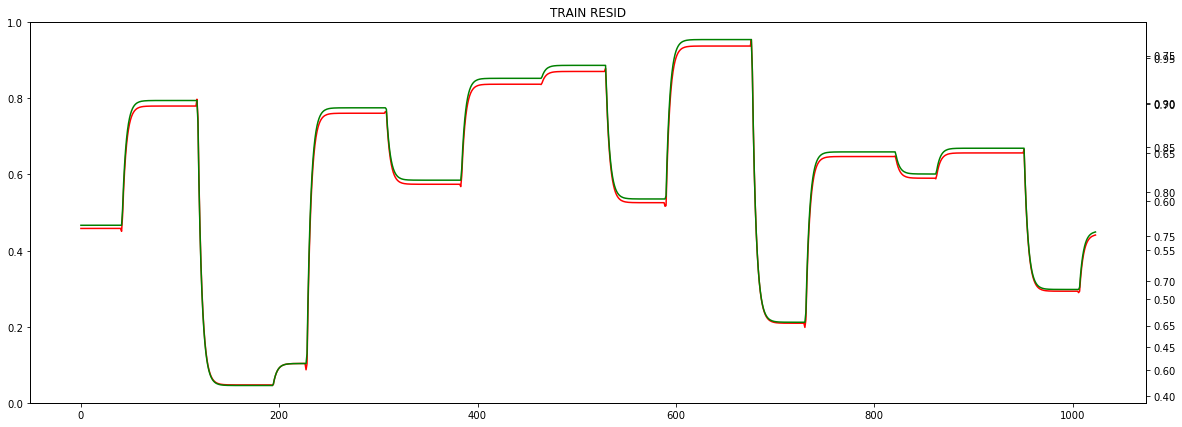

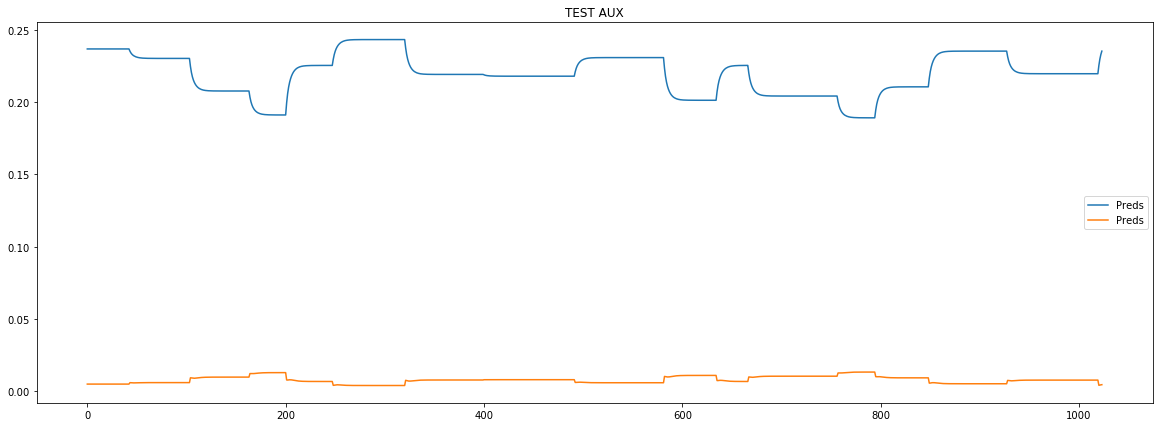

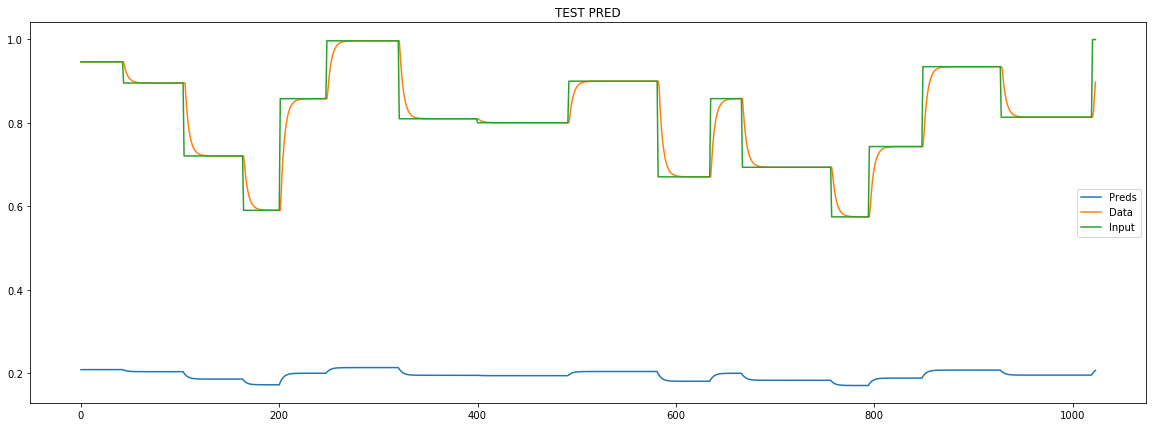

loss rate [0.00037181760448035117]
Epoch [43] 
     train_loss[18.114978411199093] 
     eval_train[18.113913400958367] 
     eval_test[14.452463199892504]



aux preds: 0.2204257845878601 0.007743691094219685
main loss 0.0
aux loss 17.84880943119956
const loss 0.26355981167692405
combined loss 18.112369242876483 


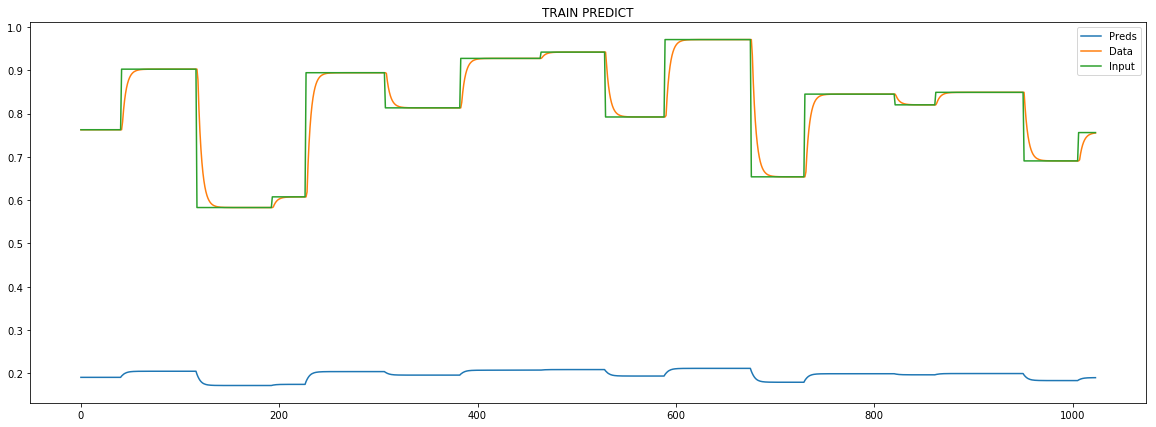

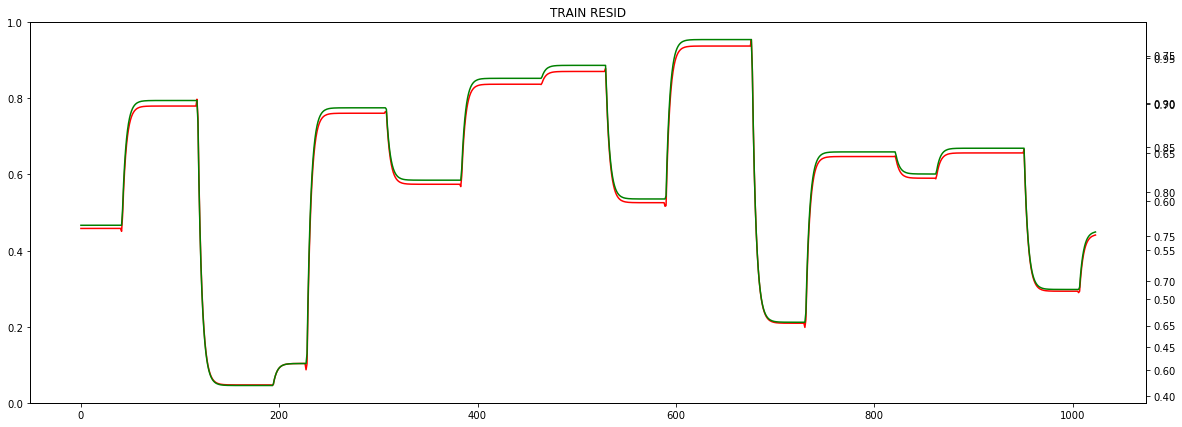

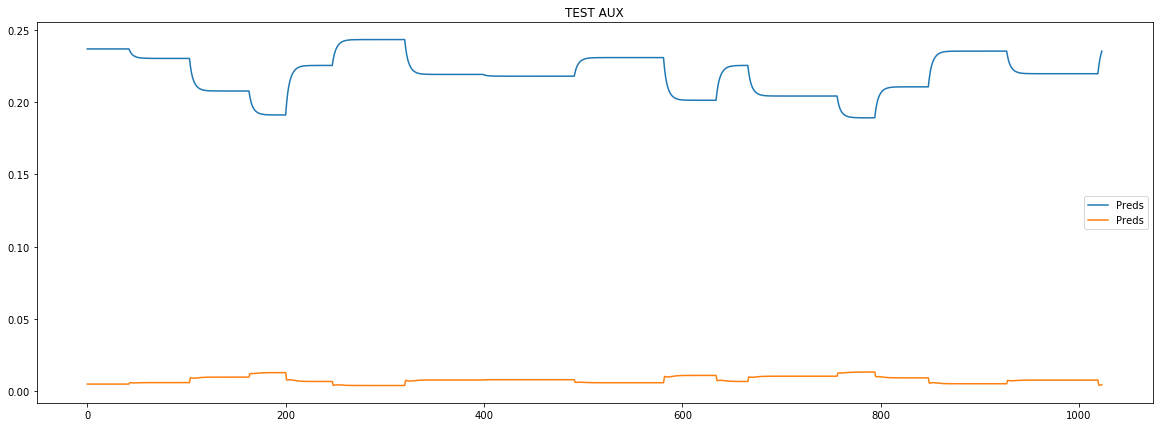

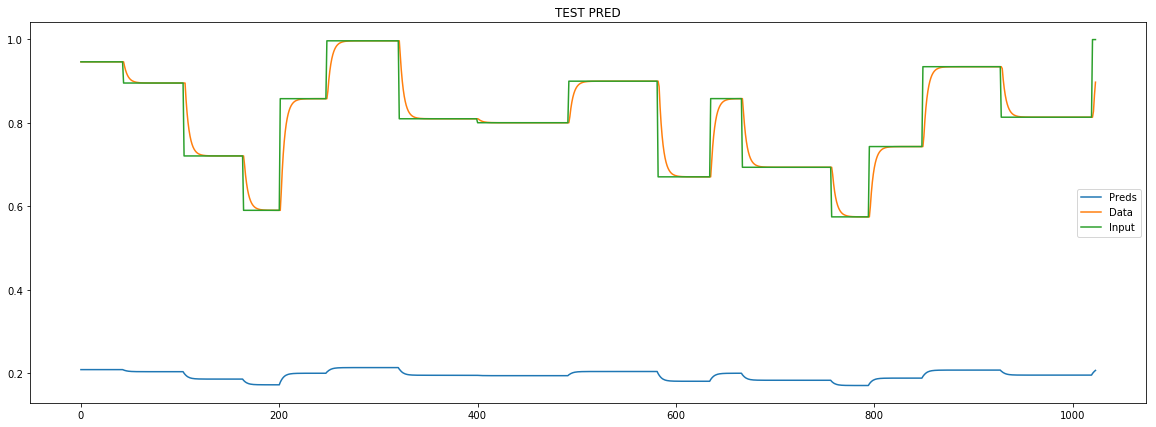

loss rate [0.00027027929496292735]
Epoch [44] 
     train_loss[18.112369242876483] 
     eval_train[15.168731157238094] 
     eval_test[14.45046202499758]



aux preds: 0.22045934200286865 0.007747996132820845
main loss 0.0
aux loss 14.90380050546418
const loss 0.2636549143263927
combined loss 15.167455419790572 


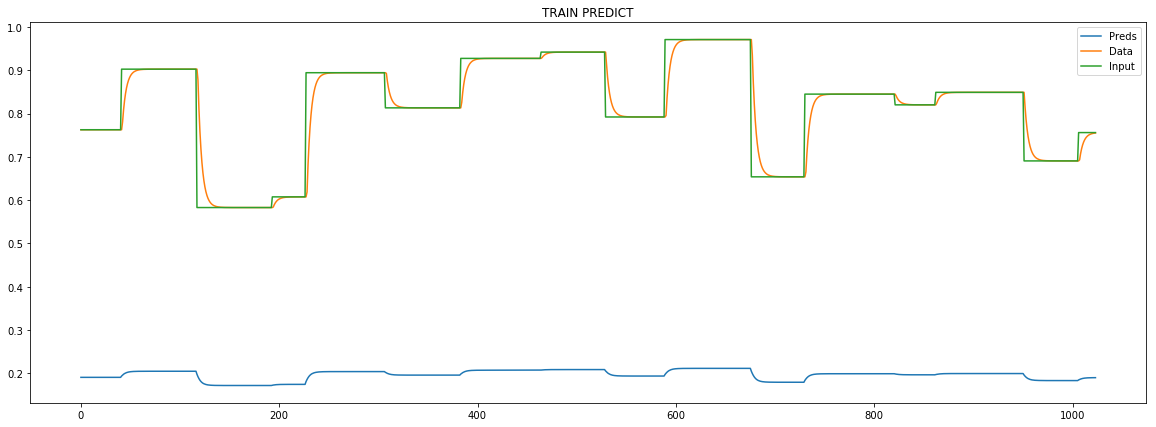

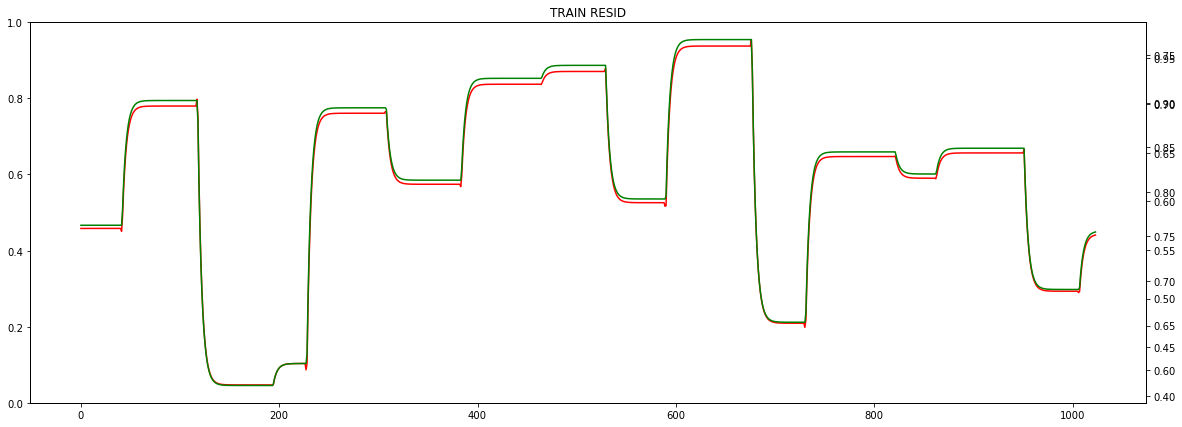

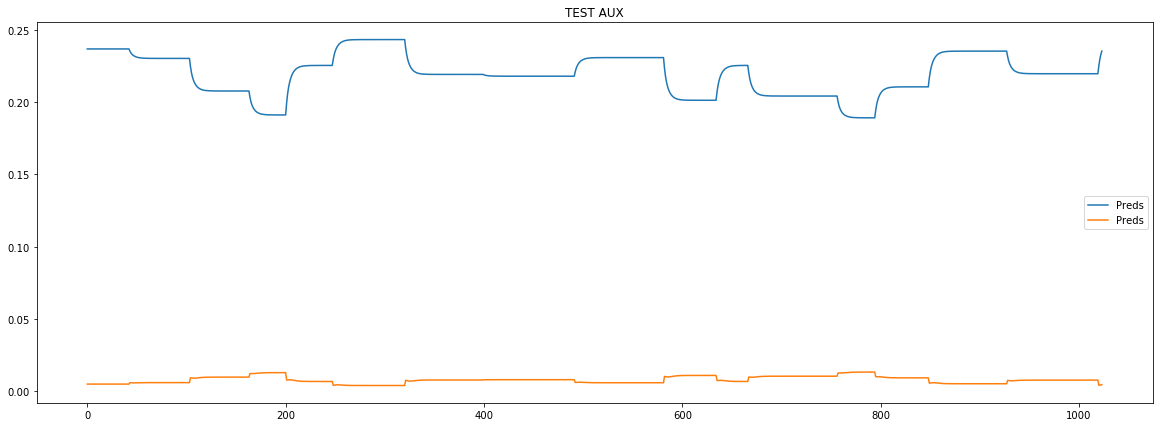

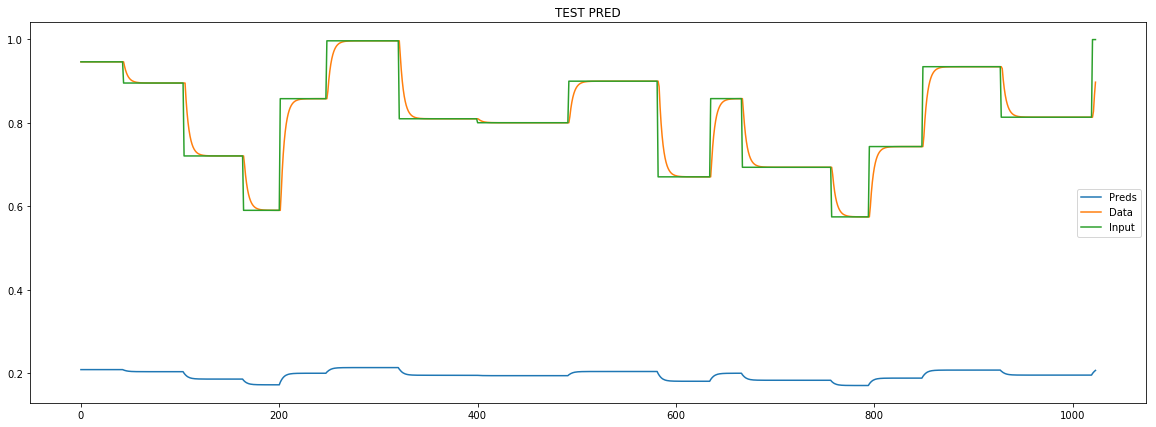

loss rate [0.00028894391284539633]
Epoch [45] 
     train_loss[15.167455419790572] 
     eval_train[18.10851976261116] 
     eval_test[14.448258979584683]



aux preds: 0.22049356997013092 0.007753157056868076
main loss 0.0
aux loss 14.901377083268017
const loss 0.2637390766579371
combined loss 15.165116159925955 


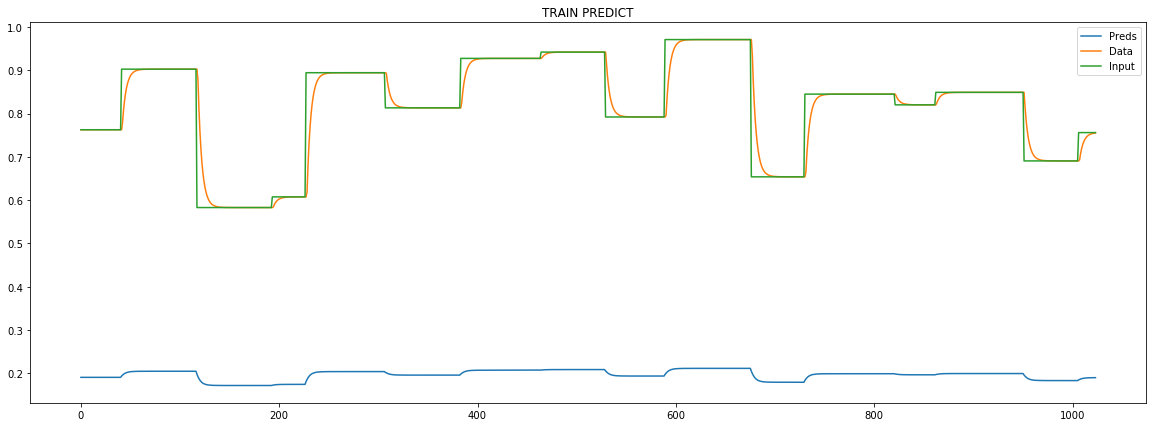

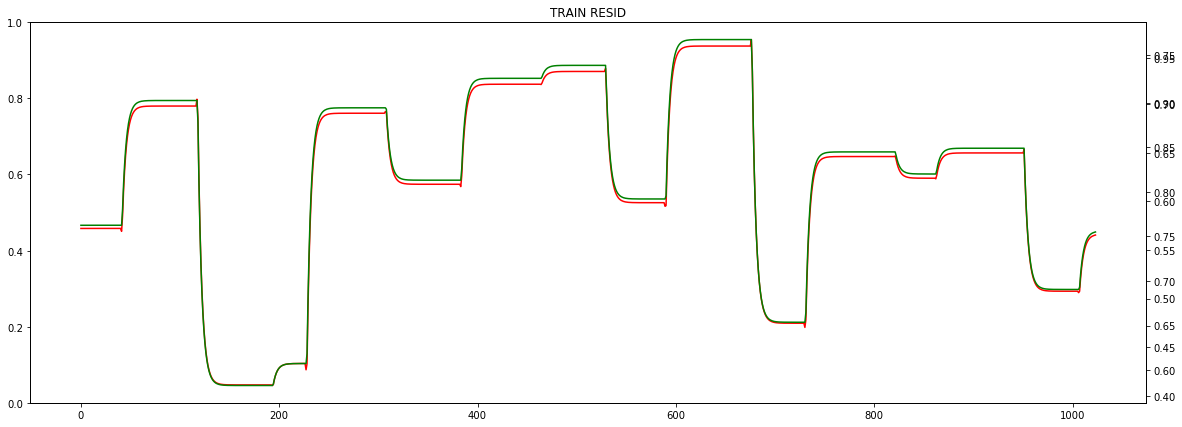

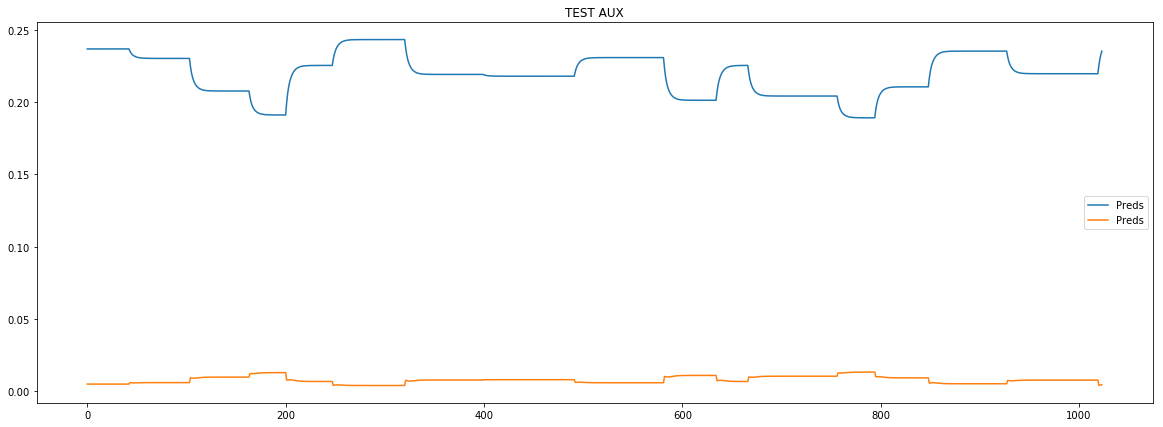

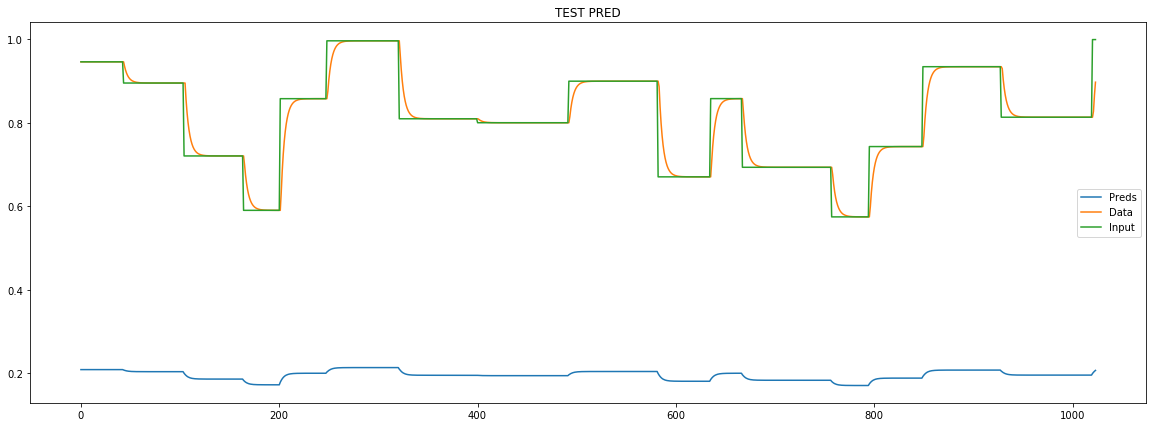

loss rate [0.0003026391211247148]
Epoch [46] 
     train_loss[15.165116159925955] 
     eval_train[18.105702998224075] 
     eval_test[14.446021480062468]



aux preds: 0.22053270041942596 0.007746660150587559
main loss 0.0
aux loss 17.84022252347607
const loss 0.2638317426809898
combined loss 18.104054266157057 


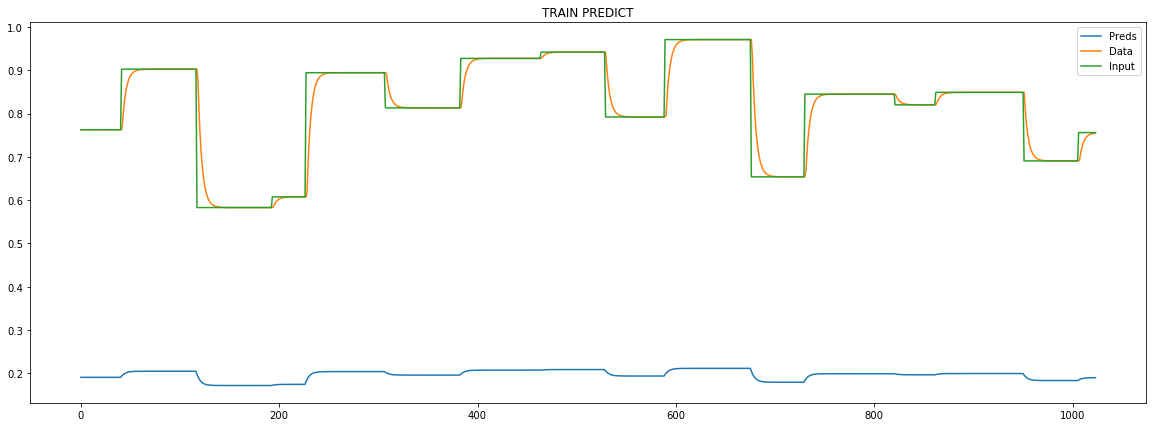

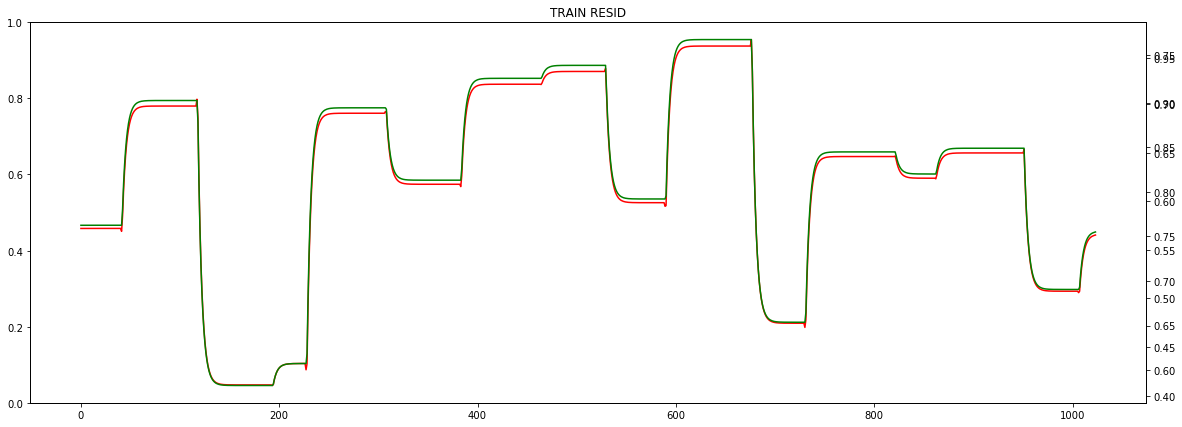

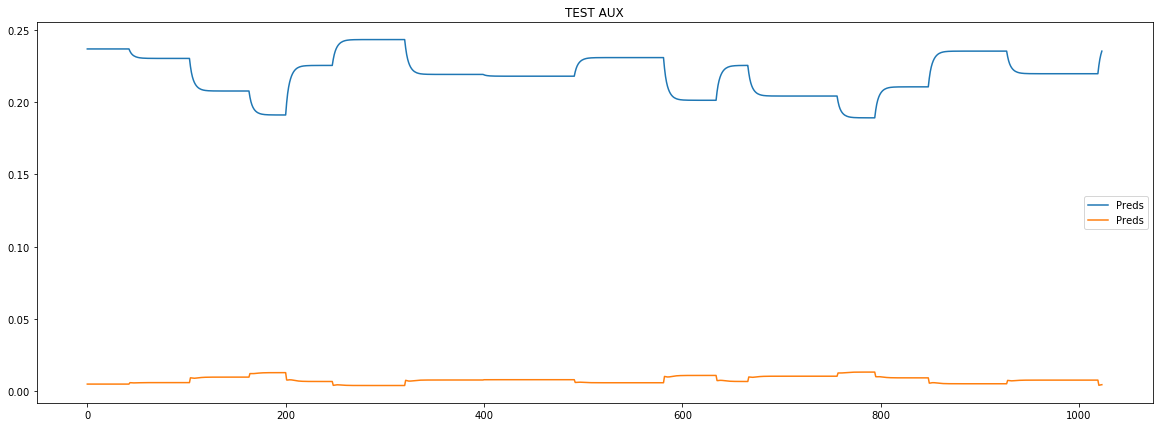

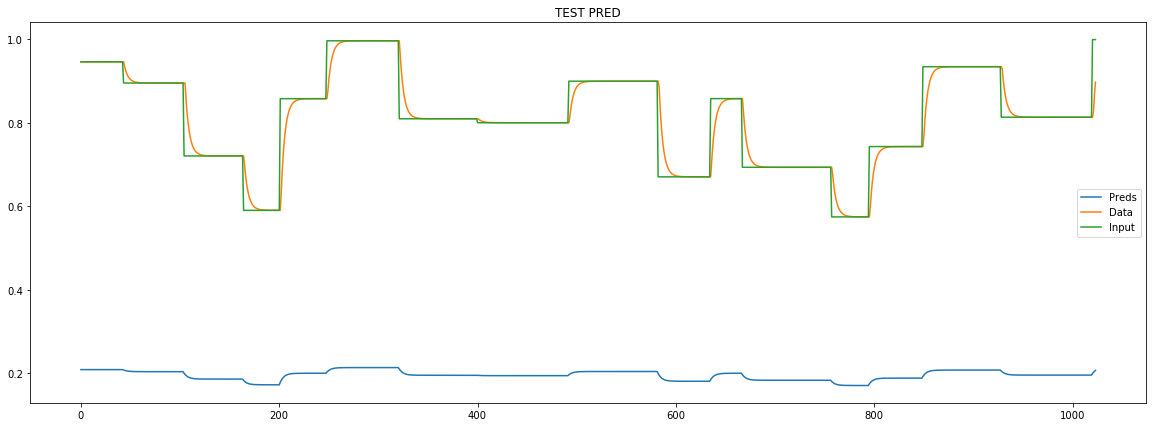

Epoch    47: reducing learning rate of group 0 to 2.1870e-07.
loss rate [0.0003018868920456885]
Epoch [47] 
     train_loss[18.104054266157057] 
     eval_train[15.16174266182889] 
     eval_test[14.443885758349841]



aux preds: 0.22054538130760193 0.007747037801891565
main loss 0.0
aux loss 14.897452571751693
const loss 0.263900218388209
combined loss 15.161352790139901 


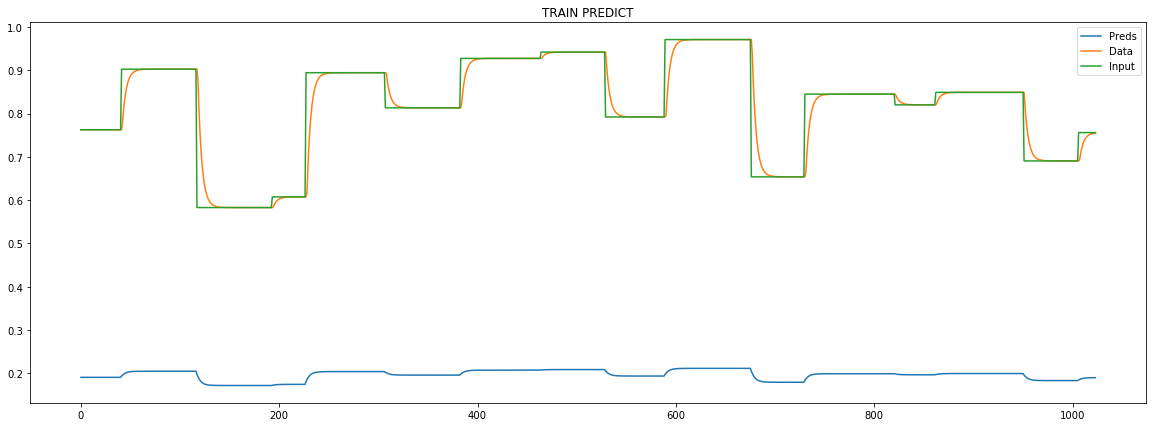

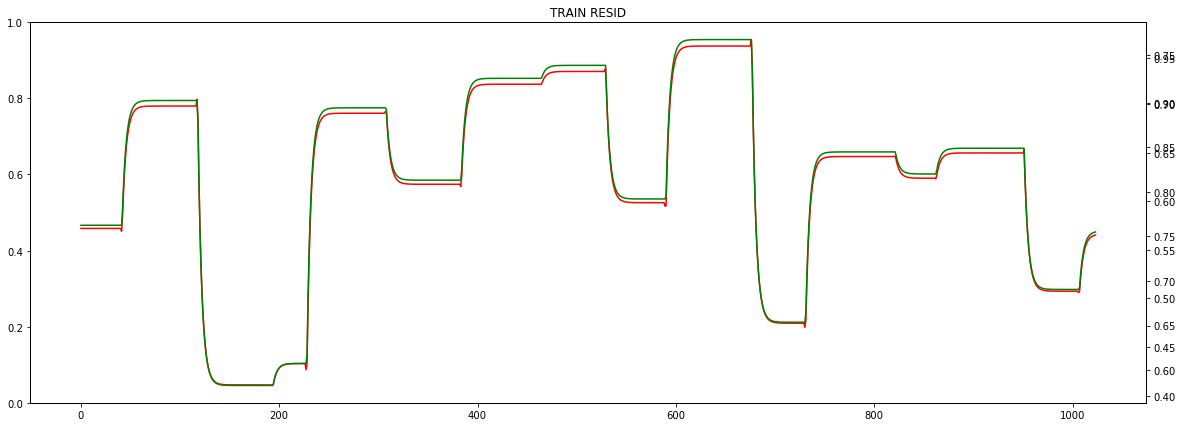

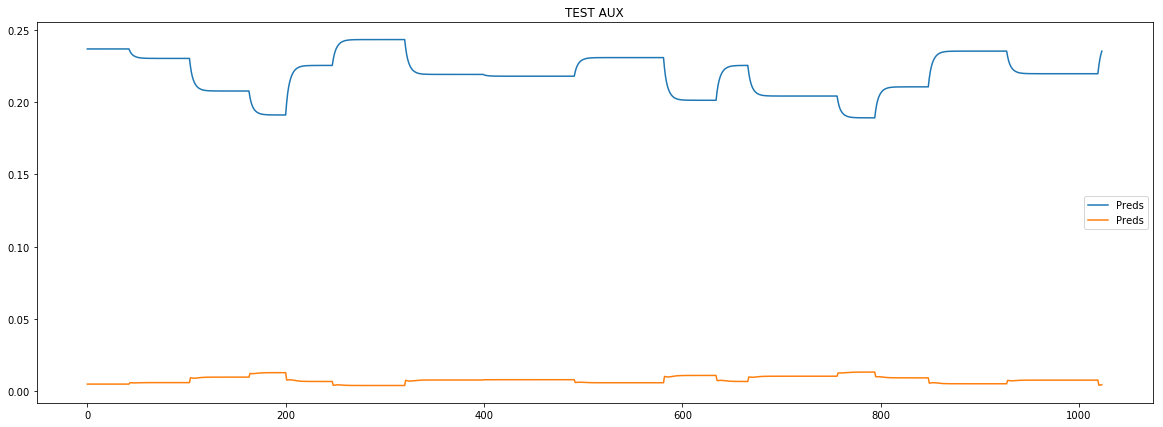

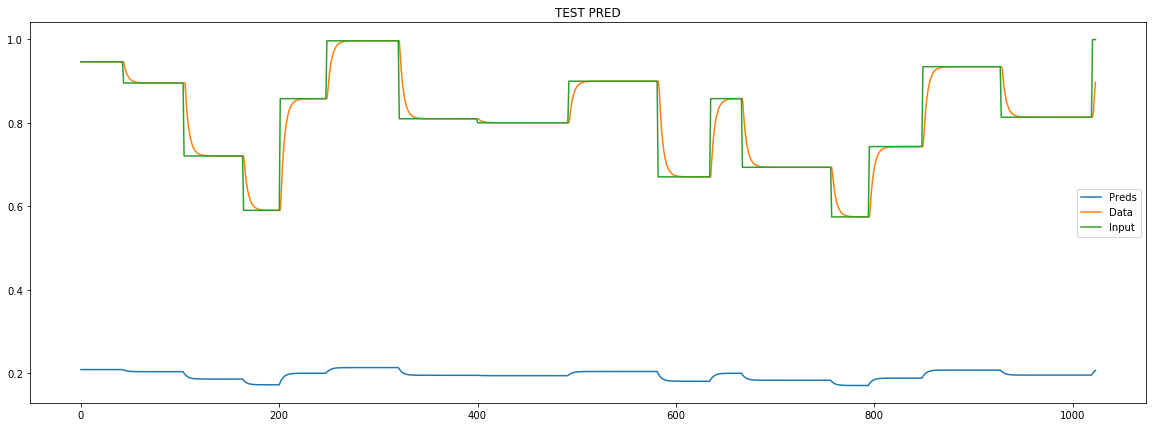

loss rate [0.00020024065176083017]
Epoch [48] 
     train_loss[15.161352790139901] 
     eval_train[18.101967121008784] 
     eval_test[14.443162718449127]



aux preds: 0.22055630385875702 0.007748628035187721
main loss 0.0
aux loss 14.896677592124503
const loss 0.2639268865952125
combined loss 15.160604478719716 


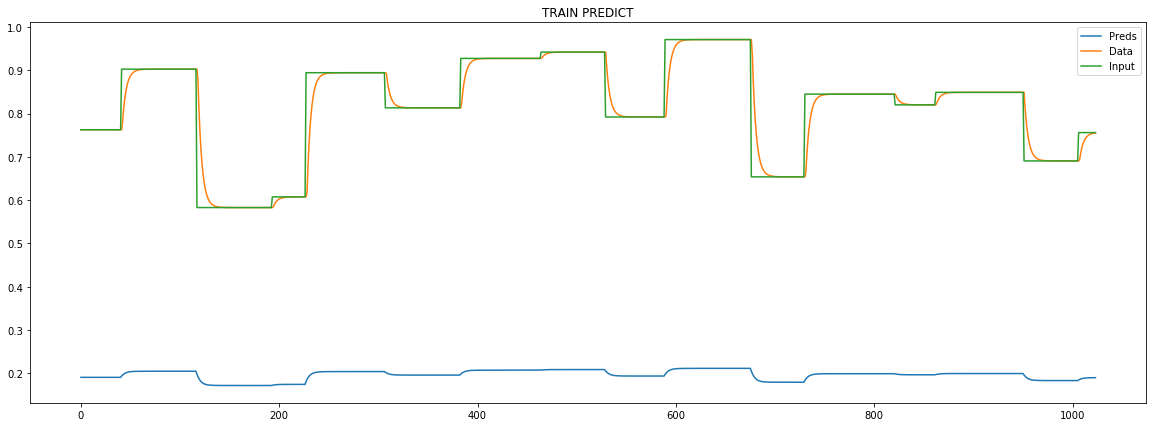

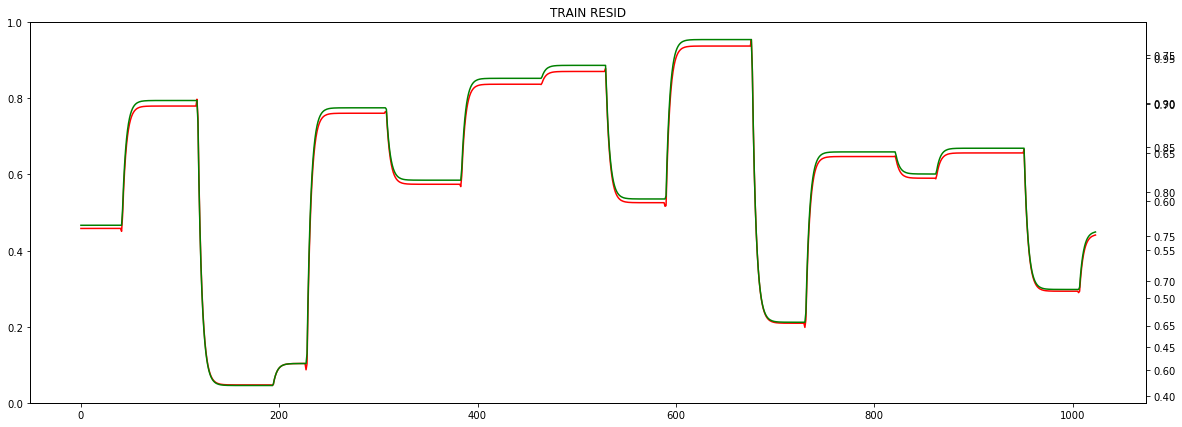

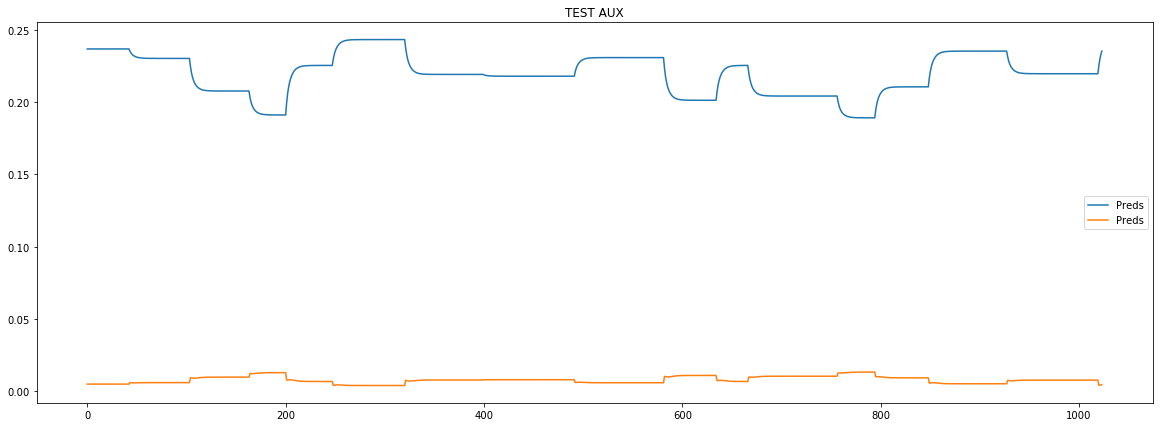

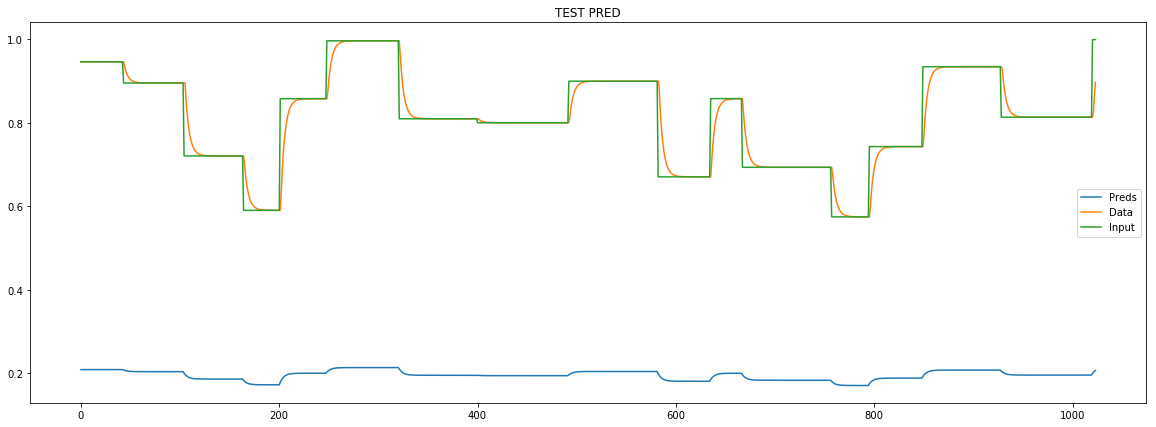

loss rate [0.00013158532979695714]
Epoch [49] 
     train_loss[15.160604478719716] 
     eval_train[18.101053826654187] 
     eval_test[14.44245598685335]



aux preds: 0.22056944668293 0.007746585179120302
main loss 0.0
aux loss 17.836591785487073
const loss 0.26395638115130937
combined loss 18.100548166638383 


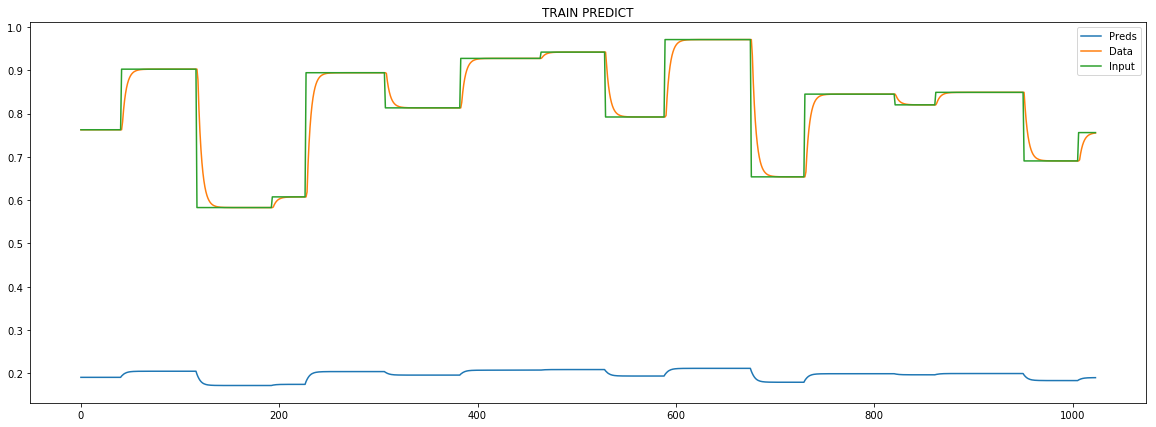

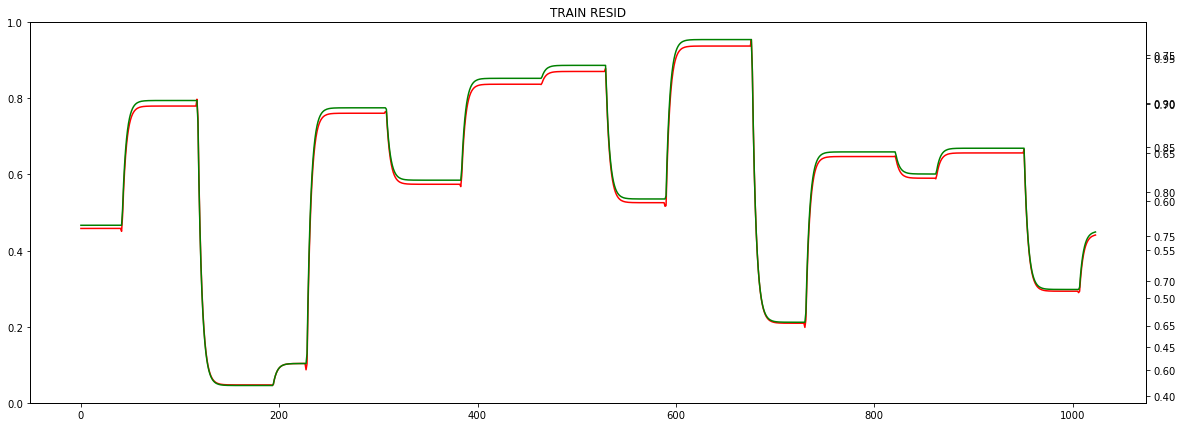

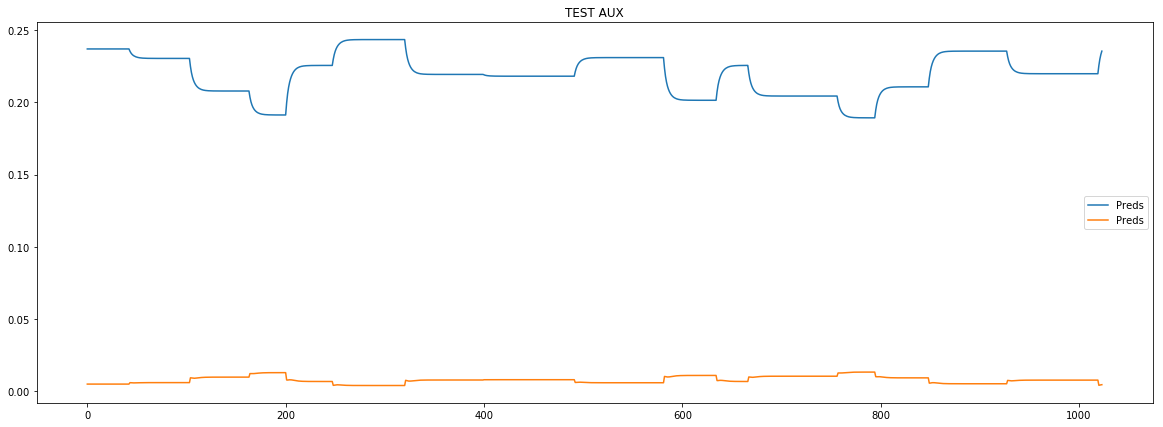

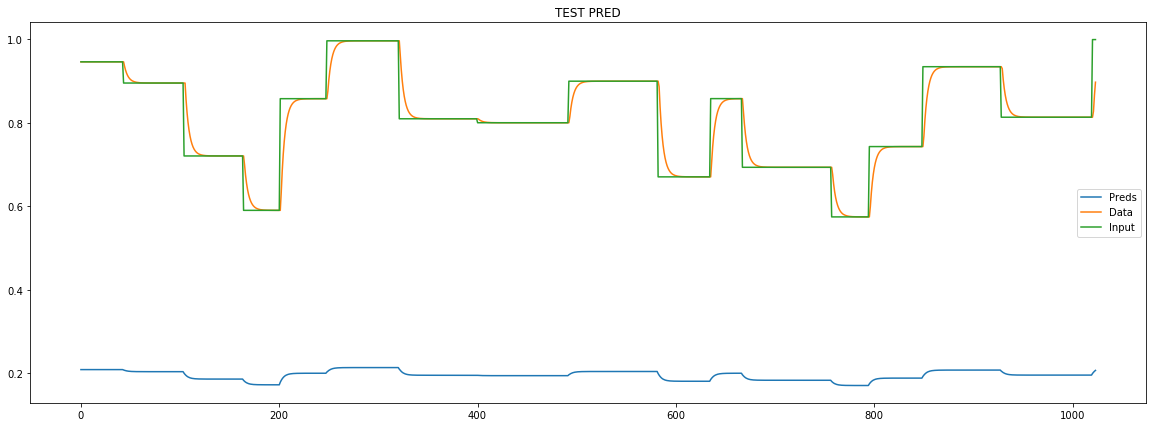

loss rate [9.681322114729607e-05]
Epoch [50] 
     train_loss[18.100548166638383] 
     eval_train[15.159534551883834] 
     eval_test[14.441769864918156]



aux preds: 0.22058086097240448 0.007748100906610489
main loss 0.0
aux loss 14.895085122113905
const loss 0.2639887467599832
combined loss 15.159073868873888 


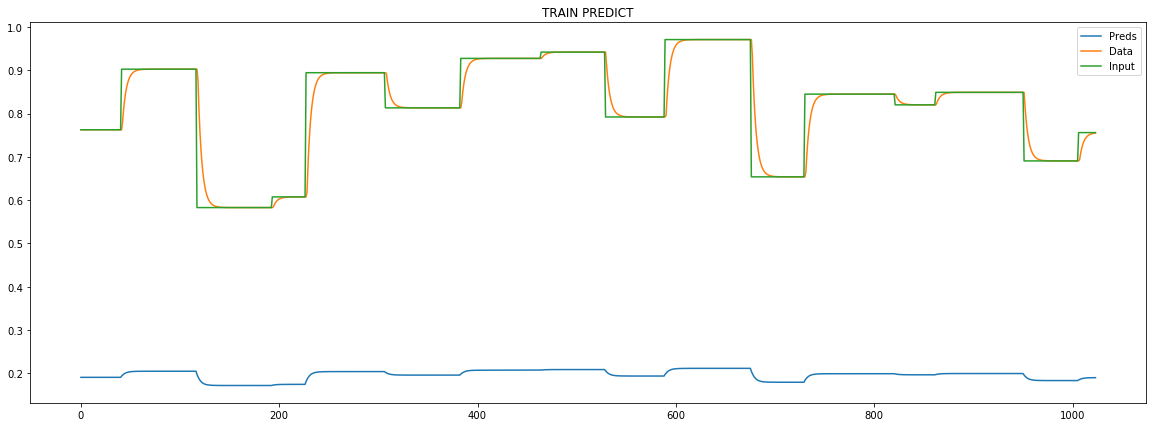

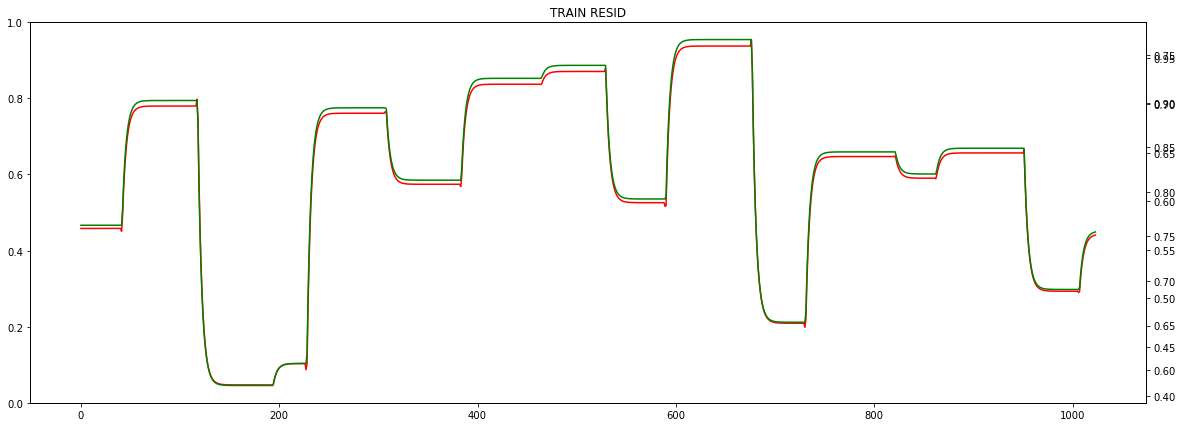

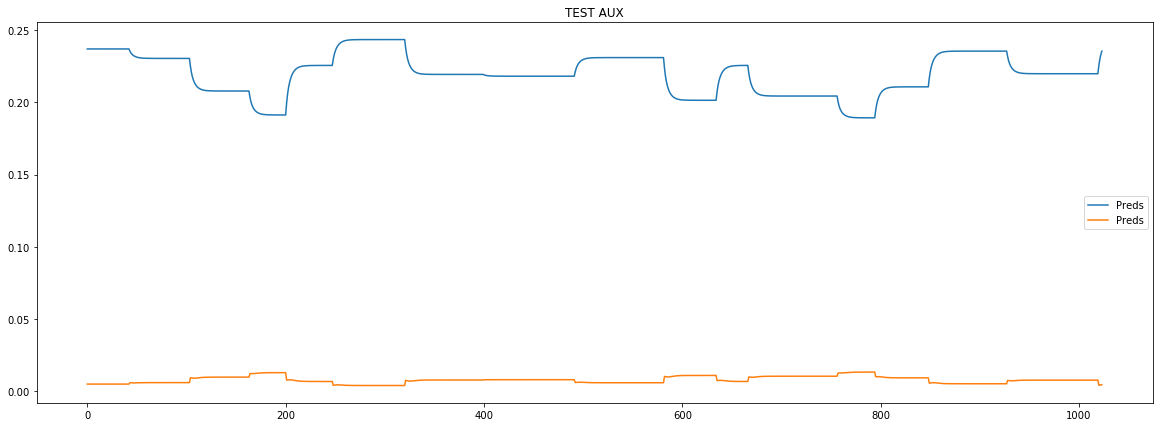

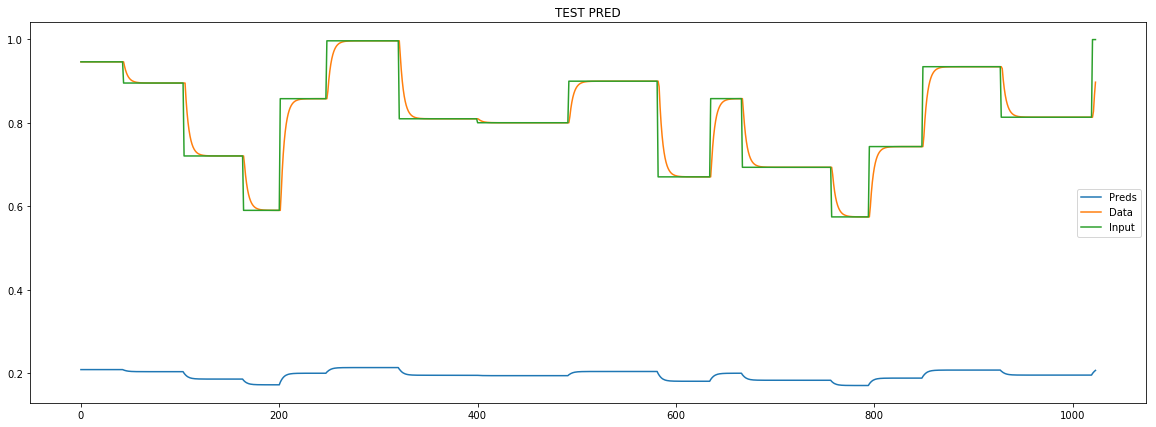

loss rate [9.922862005928845e-05]
Epoch [51] 
     train_loss[15.159073868873888] 
     eval_train[18.099247500372048] 
     eval_test[14.44102975108068]



aux preds: 0.2205929458141327 0.0077461376786231995
main loss 0.0
aux loss 17.834671356536163
const loss 0.2640197007701947
combined loss 18.098691057306358 


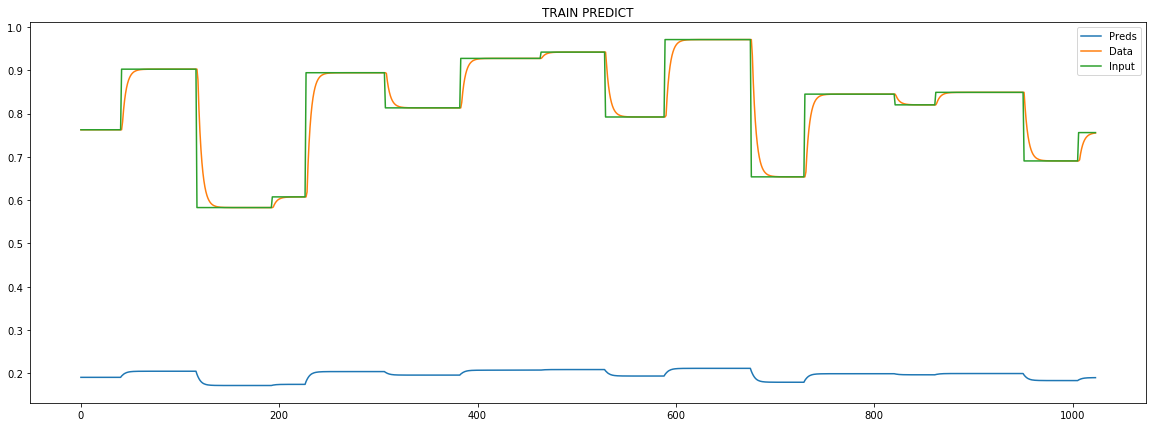

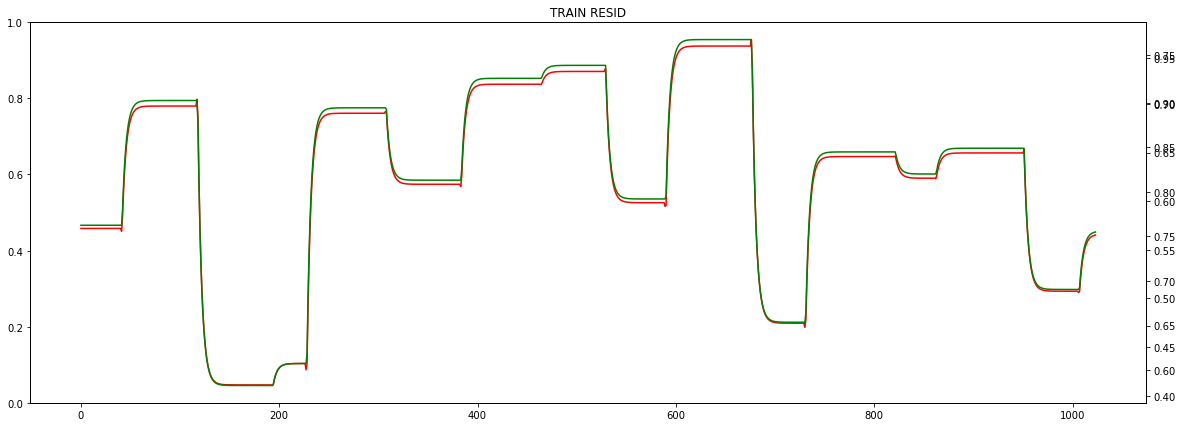

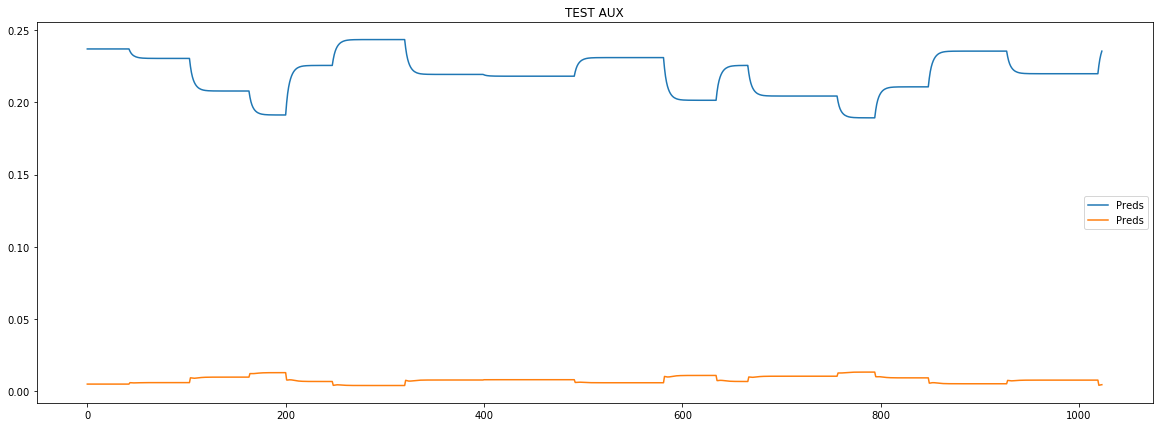

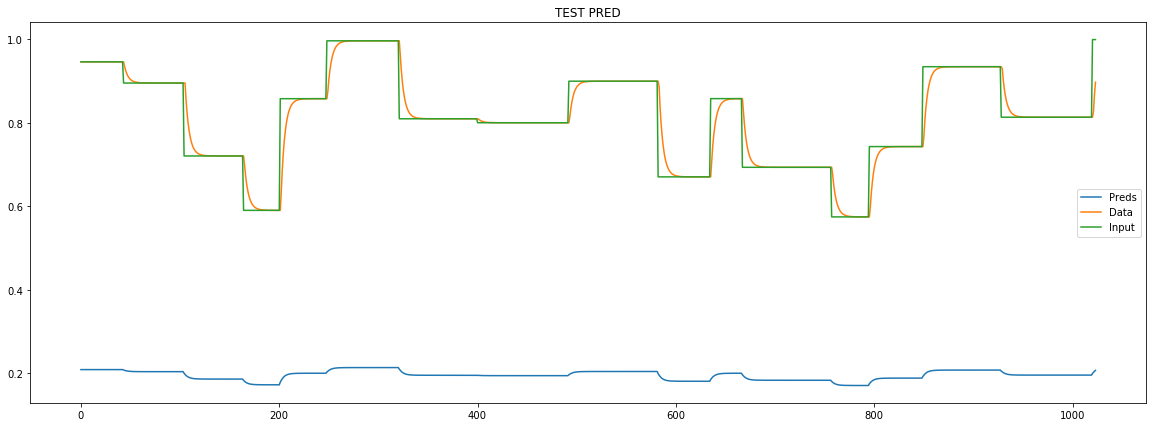

loss rate [9.965628791430703e-05]
Epoch [52] 
     train_loss[18.098691057306358] 
     eval_train[15.157963890259941] 
     eval_test[14.440312656235287]



aux preds: 0.22060512006282806 0.007747687865048647
main loss 0.0
aux loss 14.893447878018309
const loss 0.2640534175130037
combined loss 15.157501295531313 


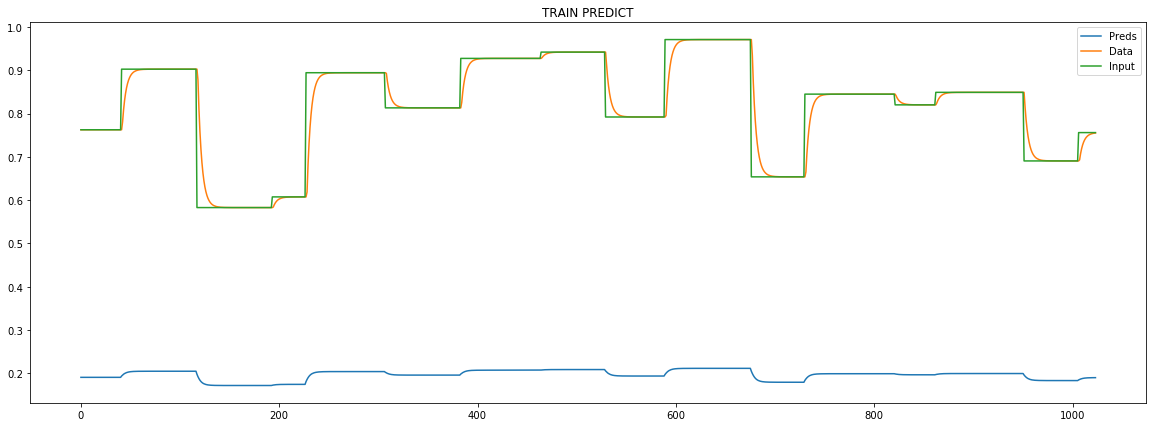

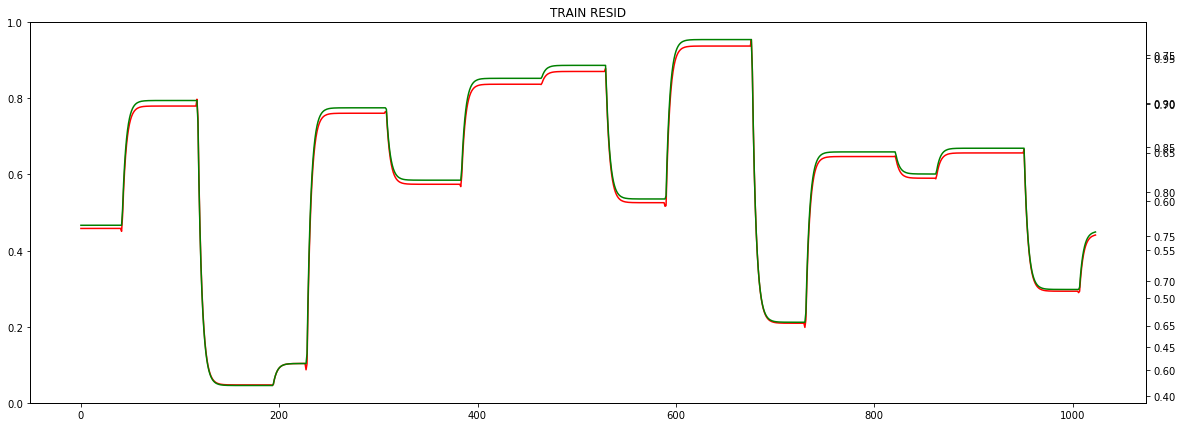

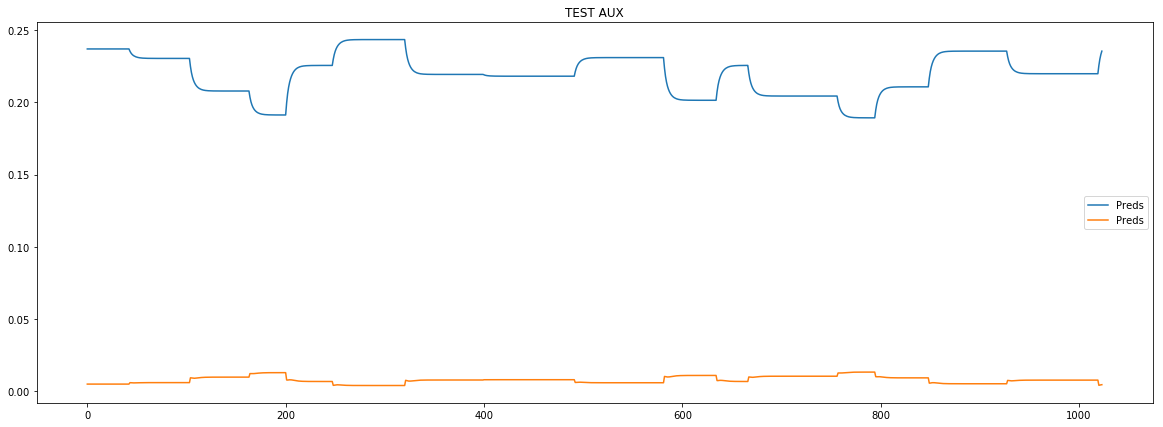

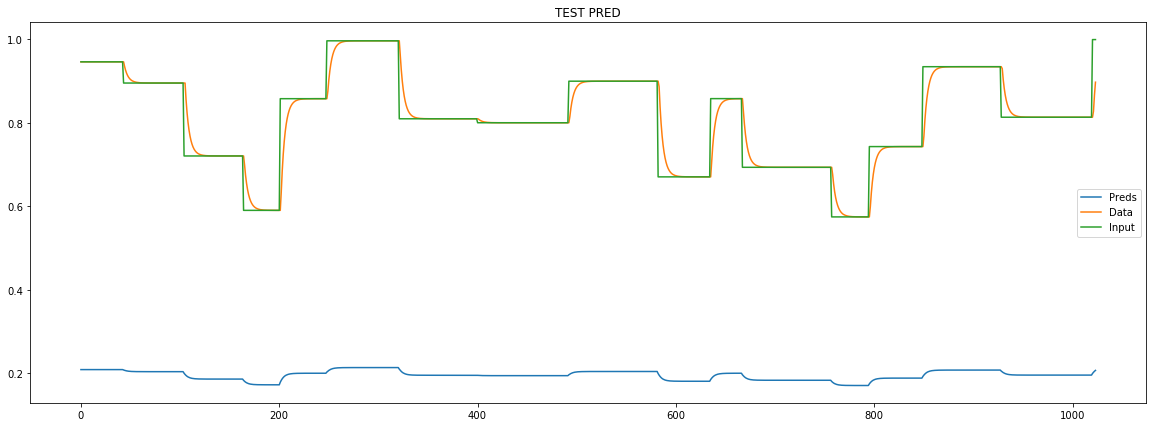

Epoch    53: reducing learning rate of group 0 to 1.0000e-07.
Loss critically low, EARLY STOPPING


In [14]:
logging.info("Training process STARTED")

model.hidden = model.init_hidden()
# todo try init hidden each batch
    

for t in range(num_epochs):
            
    
    batch_local_hist = hist["train"]["batches"]
    long_term_hist = hist["train"]["epochs"]
    
    for i, data in enumerate(tqdm(train_dl)):
        y_pred = batch_iteration(
            iter_index=i,
            model=model,
            optimizer=optimizer,
            batch_data=data,
            backprop=True,
            hist_part=batch_local_hist
        )
        
    hist['mean_params_sample']['1'][t] = y_pred[:, 1].mean()
    hist['mean_params_sample']['2'][t] = y_pred[:, 2].mean()
    
    print(f"aux preds: {hist['mean_params_sample']['1'][t]} {hist['mean_params_sample']['2'][t]}")
    
    mean_losses = update_long_term_hist(batches_hist=batch_local_hist,
                                                            long_term_hist=long_term_hist)
    mean_main, mean_aux, mean_const = mean_losses
    # TODO add w8 decay
    print(f"main loss {mean_main}")
    print(f"aux loss {mean_aux}")
    print(f"const loss {mean_const}")
    print(f"combined loss {mean_main + mean_aux + mean_const} ")
    
    # VISUALISE TRAINING PROGRESS
    x_batch, y_batch, indexes = data
    plot_shared_scale([
        (y_pred[:, 0].detach().numpy(),"Preds" ),
         (y_batch[:, 0].detach().numpy(), "Data"),
         (x_batch[-1].detach().numpy(), "Input")
        ],
        title="TRAIN PREDICT")
          
    residuals = y_batch[:, 0] - y_pred[:, 0]
    plot_multiscale([
        (residuals.detach().numpy(), "Red"),
        (y_batch[:, 0].detach().numpy(), "Green")
    ],
        title="TRAIN RESID"
    ) 
    # /VISUALISE TRAINING PROGRESS

    # EVAL
    with torch.no_grad():
          
          model = model.eval()
          
          for i, data in enumerate(tqdm(train_dl)):
              batch_local_hist = hist['eval_train']['batches']
              long_term_hist=hist["eval_train"]["epochs"]
              y_pred = batch_iteration(
                iter_index=i,
                model=model,
                optimizer=optimizer,
                batch_data=data,
                backprop=False,
                hist_part=batch_local_hist
              )
          
          update_long_term_hist(batches_hist=batch_local_hist,
                                long_term_hist=long_term_hist)
          
          
          for i, data in enumerate(tqdm(test_dl)):
              batch_local_hist = hist['eval_test']['batches']
              long_term_hist=hist["eval_test"]["epochs"]
          
              y_pred_test = batch_iteration(
                iter_index=i,
                model=model,
                optimizer=optimizer,
                batch_data=data,
                backprop=False,
                hist_part=batch_local_hist
              )
          
          update_long_term_hist(batches_hist=batch_local_hist,
                                long_term_hist=long_term_hist)
          
          model = model.train()
    # /EVAL
          
    # VISUALISE ITERATION PRED
    x_batch_test, y_batch_test, indexes = data
    plot_shared_scale([
            (y_pred_test[:, 1].detach().numpy(),"Preds" ),
            (y_pred_test[:, 2].detach().numpy(),"Preds" ),
    ],
        title = 'TEST AUX'
    )
          
    plot_shared_scale([
            (y_pred_test[:, 0].detach().numpy(),"Preds" ),
             (y_batch_test[:, 0].detach().numpy(), "Data"),
             (x_batch_test[-1].detach().numpy(), "Input")
    ],
        title = 'TEST PRED'
    )
    # /VISUALISE ITERATION PRED
    
    visualise_resid = False
    if visualise_resid:
        residuals = y_batch_test[:, 0] - y_pred_test[:, 0]
        plot_multiscale(
                [
                 (residuals.detach().numpy(), "Red"), 
                 (y_batch_test[:, 0].detach().numpy(),"Green")
                ],
            title = 'TEST RESID'
        )
    
    
    # UPDATE LR
    val_loss = slice_loss_sum(hist['eval_test']['epochs'], t)
    scheduler.step(val_loss)
    hist['weights_sum'][t] = torch.as_tensor([p.sum() for p in model.parameters(recurse=True)]).sum().item()
    hist['weights_var'][t] = torch.as_tensor([p.var() for p in model.parameters(recurse=True)]).sum().item()
    
    hist['lr'][t] = scheduler.optimizer.param_groups[0]['lr']
    if hist['lr'][t] <= 10**p_sched['early_stop_order'] * 1.0001: # 1+eps 
          print("Loss critically low, EARLY STOPPING")
          break
    if t > 3:
          h = hist["eval_test"]["epochs"]
          loss_rate = 1 - slice_loss_sum(h, t) / np.mean([slice_loss_sum(h, k) for k in range(t-3,t)])          
          hist['loss_rate'][t] = loss_rate              
          print(f"loss rate [{loss_rate}]")

    # /UPDATE LR
                       
    # FINAL PROGRESS LOGGING
    msg = "Epoch [{t}] \n \
    train_loss[{train_loss}] \n \
    eval_train[{eval_train}] \n \
    eval_test[{eval_test}]".format(t=t,
                                train_loss=sum([val[t] for val in hist['train']['epochs'].values()]), 
                                eval_train=sum([val[t] for val in hist['eval_train']['epochs'].values()]),
                                eval_test=sum([val[t] for val in hist['eval_test']['epochs'].values()])
                               )
    print(msg)
    logging.info(msg)
                       
    # /FINAL PROGRESS LOGGING

In [15]:
hist['lr'][t-1] <= 10**p_sched['early_stop_order'] * 1.0001

False

In [16]:
hist['lr'][t-1] 

2.1869999999999994e-07

In [17]:
s, e = 0, t

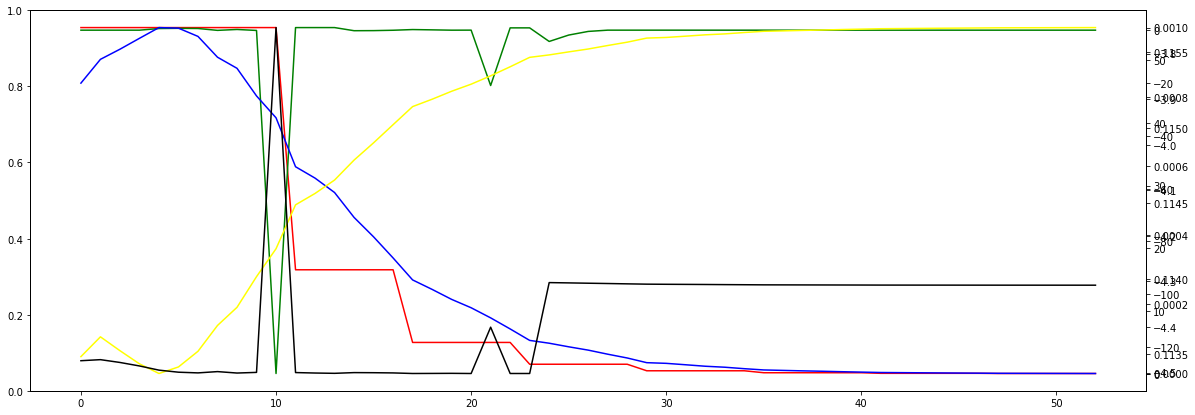

In [18]:
plot_multiscale([
    (hist['lr'][s:e],"Red" ),
    (hist['loss_rate'][s:e], "Green"),
    (hist['weights_sum'][s:e], "Blue"),
    (hist['weights_var'][s:e], "Yellow"),
    (hist['eval_test']["epochs"]['aux'][s:e], "Black")
])

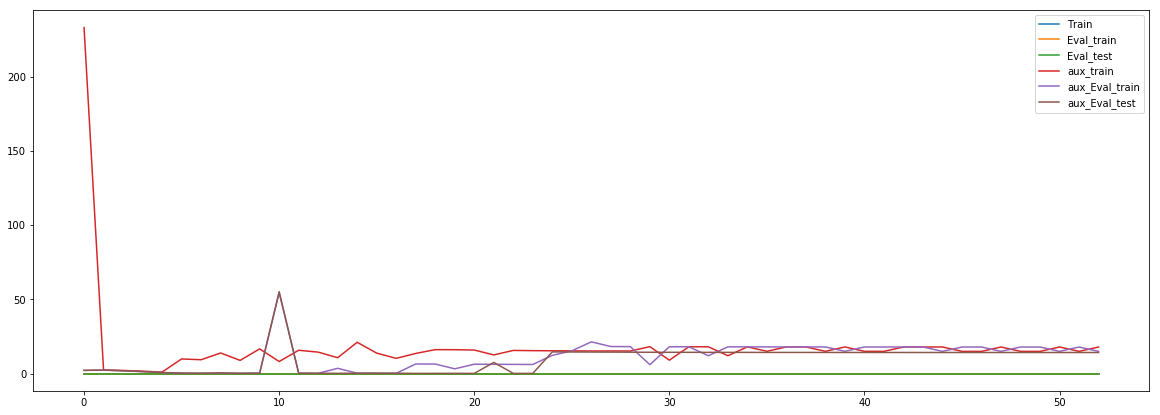

In [19]:
plot_shared_scale([
    (hist['train']["epochs"]['main'][s:e],"Train" ),
    (hist['eval_train']["epochs"]['main'][s:e], "Eval_train"),
    (hist['eval_test']["epochs"]['main'][s:e], "Eval_test"),
    (hist['train']["epochs"]['aux'][s:e], "aux_train"),
    (hist['eval_train']['epochs']['aux'][s:e], "aux_Eval_train"),
    (hist['eval_test']['epochs']['aux'][s:e], "aux_Eval_test")
])

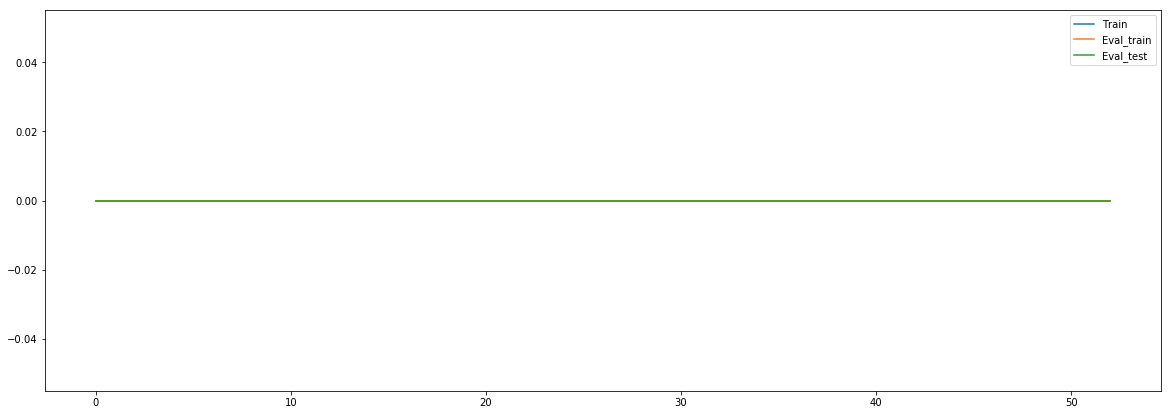

In [20]:
plot_shared_scale([
    (hist['train']["epochs"]['main'][s:e],"Train" ),
    (hist['eval_train']["epochs"]['main'][s:e], "Eval_train"),
    (hist['eval_test']["epochs"]['main'][s:e], "Eval_test"),
#     (hist['train']["epochs"]['aux'][s:e], "aux_train"),
#     (hist['eval_train']['epochs']['aux'][s:e], "aux_Eval_train"),
#     (hist['eval_test']['epochs']['aux'][s:e], "aux_Eval_test")
])

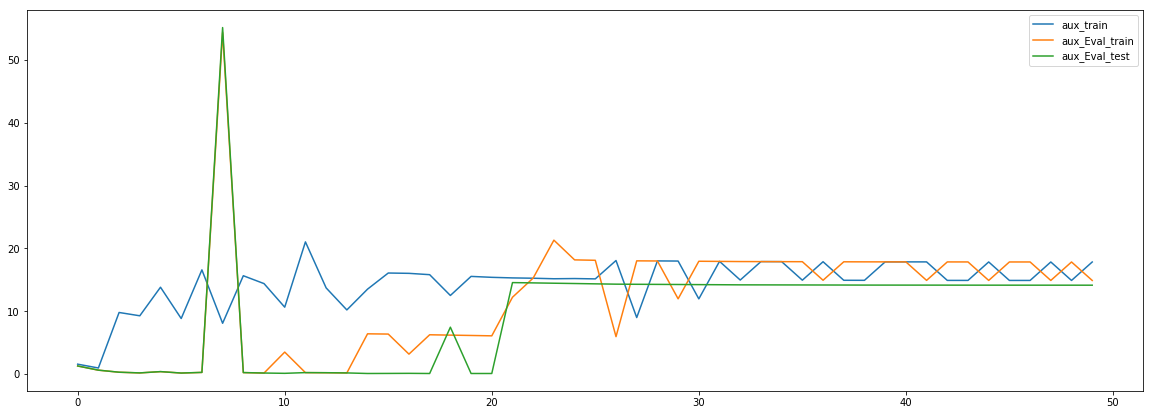

In [21]:
s = 3
plot_shared_scale([
#     (hist['train']["epochs"]['main'][s:e],"Train" ),
#     (hist['eval_train']["epochs"]['main'][s:e], "Eval_train"),
#     (hist['eval_test']["epochs"]['main'][s:e], "Eval_test"),
    (hist['train']["epochs"]['aux'][s:e], "aux_train"),
    (hist['eval_train']['epochs']['aux'][s:e], "aux_Eval_train"),
    (hist['eval_test']['epochs']['aux'][s:e], "aux_Eval_test")
])
s=0

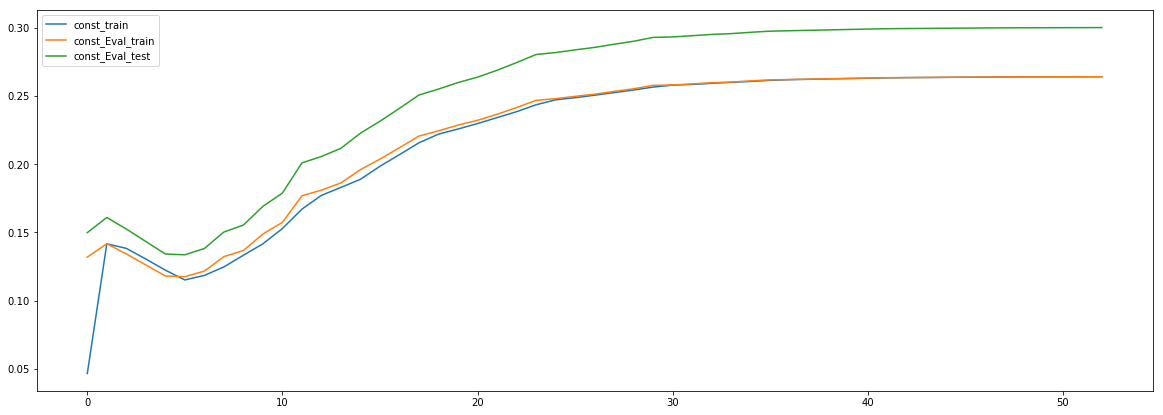

In [22]:
plot_shared_scale([
    (hist['train']["epochs"]['const'][s:e], "const_train"),
    (hist['eval_train']['epochs']['const'][s:e], "const_Eval_train"),
    (hist['eval_test']['epochs']['const'][s:e], "const_Eval_test")
])

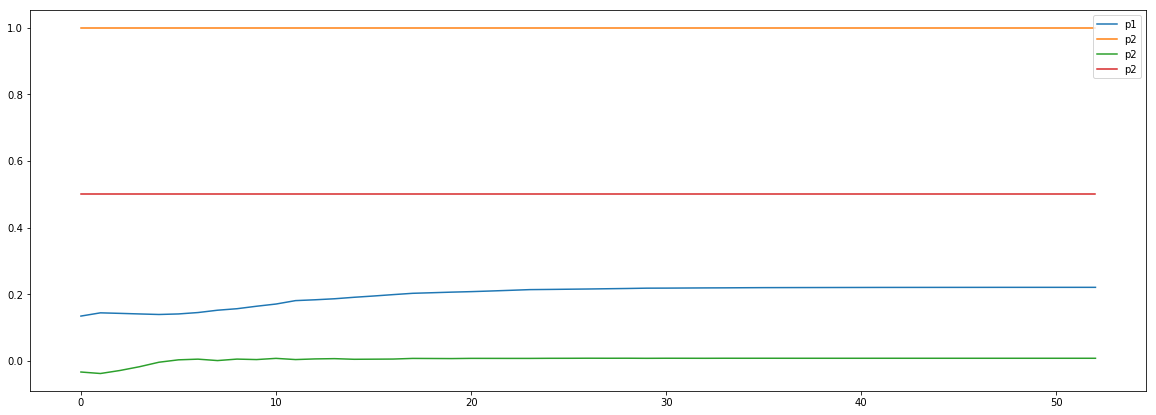

In [23]:

plot_shared_scale([
                  (hist['mean_params_sample']['1'][s:e], "p1"),
                  ((hist['mean_params_sample']['2']*0 + 1)[s:e], "p2"),
                  (hist['mean_params_sample']['2'][s:e], "p2"),
                  ((hist['mean_params_sample']['2']*0 + 0.5)[s:e], "p2"),
])

In [24]:
model.buffers

<bound method Module.buffers of LSTM(
  (lstm): LSTM(1, 16)
  (linear): Linear(in_features=16, out_features=3, bias=True)
)>

In [25]:
logging.info("Training process END")